In [1]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

In [2]:
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 16
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None, yticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is not None:
      plt.xticks([])
    else:
      plt.xticks(fontsize = font['size'], fontname = "serif")
    if yticks is not None:
      plt.yticks([])
    else:
      plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")

In [3]:
import torch
import seaborn as sns
from torch.autograd import grad as torchgrad

In [4]:

def HMCwithAccept(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept

def HMC(*args,**kwargs):
    x, _ = HMCwithAccept(*args,**kwargs)
    return x

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        # print("offset", offset)
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        assert len(x.shape) == 2
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))

    def lnZ(self,x):
        e = self.energy(x)
        Z = (torch.exp(-e)).sum()
        return torch.log(Z)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True).to(torch.float32)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()



# Diffusion

In [17]:

def DiffusionwithDrift(energy,lnZ,x,D,length,epsilon,decay=0.9):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]
    epsilon = torch.tensor(epsilon)
    epsilon.requires_grad_(False)

    g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]

    g = g.detach()
    x = x.detach()
    x_t = []
    x_t.append(x)
    '''
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
    plt.colorbar()
    plt.subplot(132)
    _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
    _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
    plt.legend()
    plt.subplot(133)
    _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
    plt.xlabel("x")
    plt.ylabel("$Grad_x(P)$")
    '''

    for l in range(1, length+1):
        z = torch.normal(0,1,size=x.size())
        x = x + 0.5 * epsilon * g * D + epsilon.sqrt() * z
        # x = x + 0.5 * epsilon * g
        g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]
        x = x.detach()
        g = g.detach()
        epsilon*=decay
        

        if l %100 == 0:
            plt.figure(figsize=(17,5))
            plt.subplot(131)
            _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
            plt.colorbar()
            plt.subplot(132)
            _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
            _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
            plt.legend()
            plt.subplot(133)
            _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
            plt.xlabel("x")
            plt.ylabel("$Grad_x(P)$")

        x_t.append(x)
    return x_t


- Start distribution: N(0,1)
- End distribution: $k_BT=2.5J$
- Diffusion coeffient = 
    [0.00087473 0.00089455 0.00101424 0.00095392 0.00078433 0.00082617
     0.00078793 0.00121703 0.0008083  0.00076017 0.00064152 0.00078268
     0.00080268 0.00104615 0.0007548  0.00079117 0.00098635 0.00104748
     0.00099374 0.00086931 0.00081431 0.00067292 0.00089971 0.001025
     0.00094306 0.00090339 0.00100088 0.00083922 0.00086348 0.00085764
     0.00102415 0.000671   0.00067592 0.00078063 0.00068504 0.00080133]

In [ ]:
ising = Ising(6,2,0.4)
initial = torch.randn([10000]+ising.nvars,requires_grad=True)
thermolength = 1000
epsilon = 0.1
D = np.array([0.00087473, 0.00089455, 0.00101424, 0.00095392, 0.00078433, 0.00082617,
              0.00078793, 0.00121703, 0.0008083 , 0.00076017, 0.00064152, 0.00078268,
              0.00080268, 0.00104615, 0.0007548 , 0.00079117, 0.00098635, 0.00104748,
              0.00099374, 0.00086931, 0.00081431, 0.00067292, 0.00089971, 0.001025,
              0.00094306, 0.00090339, 0.00100088, 0.00083922, 0.00086348, 0.00085764,
              0.00102415, 0.000671  , 0.00067592, 0.00078063, 0.00068504, 0.00080133])
x_t = DiffusionwithDrift(ising.energy, ising.lnZ, initial, torch.from_numpy(D).to(torch.float32), thermolength, epsilon)

line_color = [plt.colormaps["gnuplot"](float(i)/float(thermolength+1)) for i in range(thermolength+1)]
plt.figure()
epsilon = 0.01
t=0
for i in range(0, len(x_t), 100):
    plt.hist(x_t[i].reshape(-1,36).sum(-1), bins=200, edgecolor=line_color[i], histtype='step', label="Time=%f, $\epsilon$=%f"%(t,epsilon))
    t+=epsilon
    epsilon*=0.9
plt.legend()

xx = x_t[-1]
plt.figure(figsize=(17, 5))
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)


# Implicit score matching

In [ ]:
# \psi(x), x is 2D
import torch
import torch.nn as nn
import torch.optim as optim
model_psi = nn.Sequential(
    nn.Linear(36, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

In [ ]:
# Implicit score matching loss: L_{ISM}(\psi) = tr(\nabla_x \psi(x)) + \frac{1}{2}||\psi(x)||^2
def ism_loss(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    norm_loss = torch.norm(logp, dim=-1) ** 2/2
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

In [ ]:
dataset = xx3
def sample_batch_torch(size):
    idx = torch.randint(0, len(dataset), (size,))
    return dataset[idx]

In [ ]:
l_curve = []
print('[Training step, loss value]')
for training_step in range(5000):
    dataset = torch.tensor(sample_batch(3*10**2)).float()
    # Compute the loss.
    loss = ism_loss(model_psi, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((training_step % 10) == 0):
        l_curve.append([training_step, loss.item()])
    if ((training_step % 500) == 0):
        print([training_step, loss.item()])

In [ ]:
n_steps=9
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,36))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,:],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2])
plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues')

plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[ii,:,:].sum(-1),bins=100)

plt.show()

# Flow matching with Gaussian probability path

In [ ]:
dataset = xx3.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)))
    return dataset[idx]

In [ ]:
sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 10
NS = 1000
NS_xxtilde = 1000
xx_t = np.zeros((NT+1, NS, 36))
xx_t[0,:,:] = np.random.normal(size=(NS,36))

p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = np.zeros((NT, NS, 36))

for tt in range(NT):
    print('Step: ' + str(tt))
    sigma_tt = 1 - (1-sigma_min) * tt / NT
    xxtilde = sample_batch(NS_xxtilde)
    for ii in range(NS):
        p_t_xx_xxtilde[tt,ii,:] = np.exp(-np.sum((xx_t[tt,ii,:].reshape(-1, 36)-xxtilde*tt/NT)**2,axis=1)/(2*sigma_tt**2))/((2*np.pi)**18*sigma_tt**36)
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt
    p_t_xx[tt, :] = np.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 0.1

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7


/tmp/ipykernel_1873410/3291082697.py:27: RuntimeWarning: invalid value encountered in divide
  u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])


Step: 8
Step: 9


In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(xx_t[(ii+1)*1,:,0], xx_t[ii+1,:,1],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2]) 
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[(ii+1)*1,:,:].sum(-1),bins=100)
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlim((-50,50))
plt.show()

# CFM by Gaussian probability path

In [11]:
def cfm_loss(model, samples, u_t_label, train=False):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [8]:
dataset = xx2.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

In [9]:
dataset_prior = xx0.detach().numpy()
def sample_batch_prior(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_prior)), size=size)
    return dataset_prior[idx]

## Trainning OT model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim


model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)



optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001


l_curve = []
l_curve_score = []
ising_tilde = Ising(6,2,0.4)
sample_size = 10**3
print('[Time step, loss value]')
for training_step in range(10000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    u_t_xx = (sample_x_tilde - (1 - sigma_min)*sample_x) / sigma_t
    u_t_label = torch.tensor(u_t_xx).float()

    loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    
    if ((training_step % 20) == 0):
        l_curve.append([training_step,loss.item()])
    if ((training_step % 200) == 0):
        print([training_step,loss.item()])

[Time step, loss value]
[0, 77.45973205566406]
[200, 51.08787536621094]
[400, 53.44320297241211]
[600, 49.53846740722656]
[800, 49.71266555786133]
[1000, 49.144813537597656]
[1200, 48.80458068847656]
[1400, 48.85736846923828]
[1600, 48.04904556274414]
[1800, 47.093257904052734]
[2000, 48.24522018432617]
[2200, 46.05447006225586]
[2400, 46.70978927612305]
[2600, 46.08371353149414]
[2800, 47.075653076171875]
[3000, 47.305789947509766]
[3200, 48.265811920166016]
[3400, 47.23932647705078]
[3600, 46.17805099487305]
[3800, 46.72538375854492]
[4000, 47.44575119018555]
[4200, 47.028133392333984]
[4400, 45.759010314941406]
[4600, 47.513484954833984]
[4800, 46.721988677978516]
[5000, 48.167884826660156]
[5200, 46.82341003417969]
[5400, 45.22835922241211]
[5600, 46.52702331542969]
[5800, 47.33144760131836]
[6000, 46.55326843261719]
[6200, 46.97969436645508]
[6400, 47.327083587646484]
[6600, 47.8384895324707]
[6800, 47.38787078857422]
[7000, 46.95287322998047]
[7200, 48.14508056640625]
[7400, 45.9

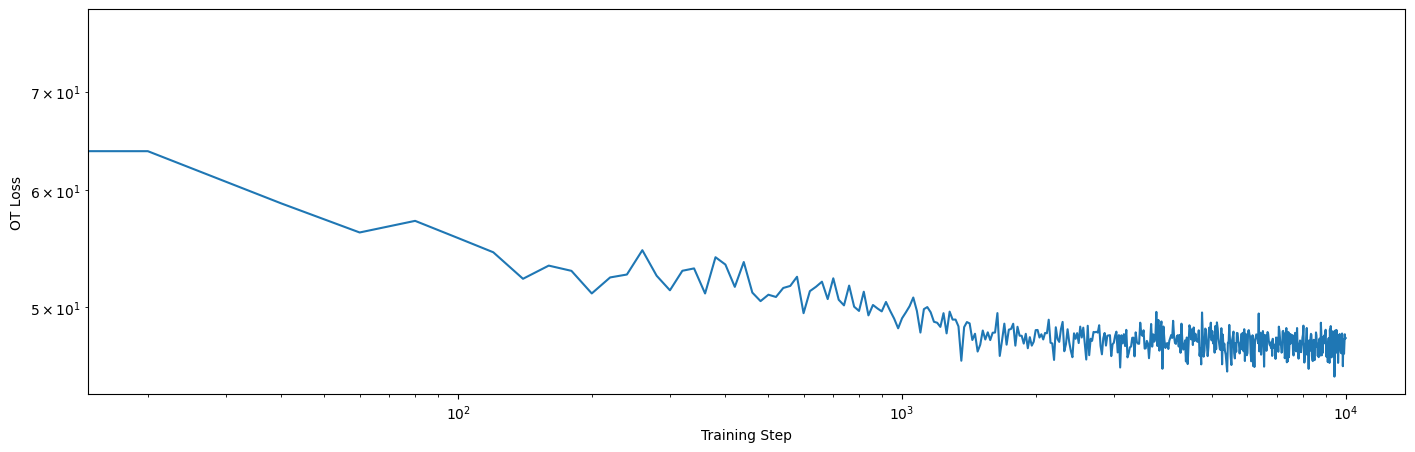

In [13]:
l_curve_fm = np.array(l_curve)
plt.loglog(l_curve_fm[:,0],l_curve_fm[:,1])
plt.xlabel('Training Step')
plt.ylabel('OT Loss')
plt.show()

## Trainning score model by $\nabla lnp$

In [32]:
from torch.autograd.functional import jacobian
def batch_jacobian(func, x):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return jacobian(_func_sum, x)

In [35]:


model_s_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer_s = optim.Adam(model_s_t.parameters(), lr=3e-3)

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001


l_curve_score = []
ising_tilde = Ising(6,2,0.4)
sample_size = 10**3
print('[Time step, loss value]')
for training_step in range(10000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    # score_label = jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # score_label = torch.stack([jacobian(ising_tilde.energy, torch.from_numpy(x).reshape(1,36)).ravel() for x in sample_x], axis=0)
    score_label = batch_jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # plt.figure(figsize=(23,5))
    # plt.subplot(141)
    # plt.hist(sample_x.sum(-1), bins=100)
    # plt.subplot(142)
    # plt.hist2d(sample_x[:,0], sample_x[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.subplot(143)
    # plt.hist(score_label.sum(-1), bins=100)
    # plt.subplot(144)
    # plt.hist2d(score_label[:,0], score_label[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.show()

    # loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    score_loss = cfm_loss(model_s_t, torch.tensor(samples).float(), score_label)
    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 20) == 0):
        l_curve_score.append([training_step,score_loss.item()])
    if ((training_step % 200) == 0):
        print([training_step, score_loss.item()])

[Time step, loss value]
[0, 11.575148582458496]
[200, 1.5401755571365356]
[400, 1.3245893716812134]
[600, 1.1412018537521362]
[800, 1.0780655145645142]
[1000, 0.9713603258132935]
[1200, 0.8961968421936035]
[1400, 0.8736280798912048]
[1600, 0.797215461730957]
[1800, 0.8060128688812256]
[2000, 0.8332050442695618]
[2200, 0.7090574502944946]
[2400, 0.6852381825447083]
[2600, 0.6312187314033508]
[2800, 0.6132118701934814]
[3000, 0.5747621655464172]
[3200, 0.5574451088905334]
[3400, 0.5093859434127808]
[3600, 0.5088063478469849]
[3800, 0.46933820843696594]
[4000, 0.4453522264957428]
[4200, 0.4288051724433899]
[4400, 0.410024493932724]
[4600, 0.3910832405090332]
[4800, 0.33924686908721924]
[5000, 0.3664292097091675]
[5200, 0.28730151057243347]
[5400, 0.32938334345817566]
[5600, 0.2626804709434509]
[5800, 0.25385910272598267]
[6000, 0.2526218295097351]
[6200, 0.207828089594841]
[6400, 0.17732788622379303]
[6600, 0.17571516335010529]
[6800, 0.14545907080173492]
[7000, 0.13535559177398682]
[7200

In [38]:
print('[Time step, loss value]')
l_curve_score = list(l_curve_score)
for training_step in range(10000, 15000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    # score_label = jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # score_label = torch.stack([jacobian(ising_tilde.energy, torch.from_numpy(x).reshape(1,36)).ravel() for x in sample_x], axis=0)
    score_label = batch_jacobian(ising_tilde.energy, torch.from_numpy(sample_x))
    # plt.figure(figsize=(23,5))
    # plt.subplot(141)
    # plt.hist(sample_x.sum(-1), bins=100)
    # plt.subplot(142)
    # plt.hist2d(sample_x[:,0], sample_x[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.subplot(143)
    # plt.hist(score_label.sum(-1), bins=100)
    # plt.subplot(144)
    # plt.hist2d(score_label[:,0], score_label[:,1], cmap="Blues", bins=100, range=[[-5,5], [-5,5]])
    # plt.show()

    # loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    score_loss = cfm_loss(model_s_t, torch.tensor(samples).float(), score_label)
    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 20) == 0):
        l_curve_score.append([training_step,score_loss.item()])
    if ((training_step % 200) == 0):
        print([training_step, score_loss.item()])

[Time step, loss value]
[10000, 0.0659019872546196]
[10200, 0.09053083509206772]
[10400, 0.04566692188382149]
[10600, 0.04403812810778618]
[10800, 0.12081831693649292]
[11000, 0.034545354545116425]
[11200, 0.06902024894952774]
[11400, 0.06072520837187767]
[11600, 0.035977549850940704]
[11800, 0.10682042688131332]
[12000, 0.03048364259302616]
[12200, 0.05398136004805565]
[12400, 0.04211374744772911]
[12600, 0.07049286365509033]
[12800, 0.036643922328948975]
[13000, 0.04107579216361046]
[13200, 0.02954147197306156]
[13400, 0.02166661061346531]
[13600, 0.06131308898329735]
[13800, 0.030691450461745262]
[14000, 0.044011738151311874]
[14200, 0.048120368272066116]
[14400, 0.02525760605931282]
[14600, 0.027530411258339882]
[14800, 0.0328558087348938]


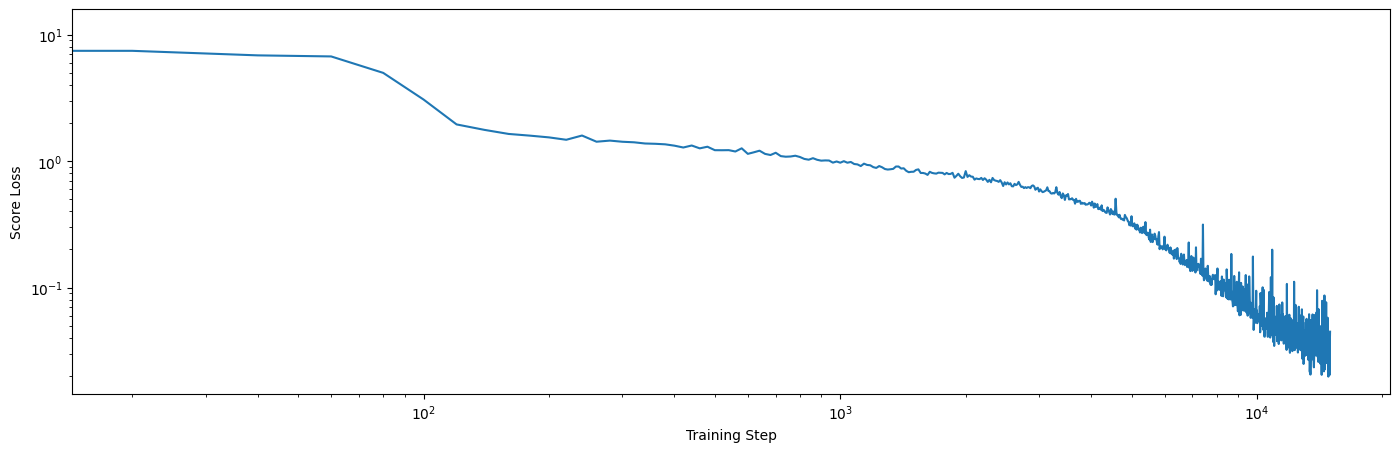

In [39]:
l_curve_score = np.array(l_curve_score)
plt.loglog(l_curve_score[:,0],l_curve_score[:,1])
plt.xlabel('Training Step')
plt.ylabel('Score Loss')
plt.show()

## Make a dataset of Boltzmann path with score: $s=\nabla lnp$

In [32]:
sigma_min=0.0001
def sample_path(size, samplesize_per_beta=100):
    t = 1.-np.linspace(0,1,size//samplesize_per_beta)**2
    print("idx_t, t, beta")
    for idx_t in range(len(t)):
        sigma_t =  1 - (1-sigma_min) * t[idx_t]
        sample_x_tilde = sample_batch(size=samplesize_per_beta).reshape([-1,36])
        sample_x_ot_t = sample_batch_prior(size=samplesize_per_beta).reshape([-1,36])
        sample_x_ot_t *= sigma_t
        sample_x_ot_t += t[idx_t] * sample_x_tilde
        if idx_t == 0:
            sample_x_ot = sample_x_ot_t
        else:
            sample_x_ot = np.concatenate([sample_x_ot, sample_x_ot_t], axis=0)
        beta = 1./(10.-6.0/(1-sigma_min)*t[idx_t])
        ising_t = Ising(6,2,beta)
        if idx_t == 0:
            sample_x_t = ising_t.sample(samplesize_per_beta, thermalSteps=1000).reshape([-1,36]).detach().numpy()
            # score_label_t = batch_jacobian(ising_t.energy, torch.from_numpy(sample_x_t))
            sample_x = sample_x_t
            sample_t = np.ones([samplesize_per_beta,1])*t[idx_t]
            # score_label = score_label_t
        else:
            sample_x_t = ising_t.sample(samplesize_per_beta, thermalSteps=100, initial=torch.from_numpy(sample_x_t)).reshape([-1,36]).detach().numpy()
            # score_label_t = batch_jacobian(ising_t.energy, torch.from_numpy(sample_x_t))
            sample_x = np.concatenate([sample_x, sample_x_t], axis=0)
            sample_t = np.concatenate([sample_t, np.ones([samplesize_per_beta,1])*t[idx_t]], axis=0)
            # score_label = torch.cat([score_label, score_label_t])

        print(idx_t, t[idx_t], beta)
    return sample_t, sample_x, sample_x_ot

In [33]:
dataset_t, dataset_path, dataset_ot = sample_path(100000)
print(dataset_t.shape, dataset_path.shape, dataset_ot.shape)

idx_t, t, beta
0 1.0 0.2500375093773443
1 0.999998997996996 0.2500371334764308
2 0.999995991987984 0.2500360057804717
3 0.999990981972964 0.250034126309811
4 0.9999839679519359 0.25003149509835415
5 0.9999749499248999 0.250028112193567
6 0.9999639278918558 0.2500239776564731
7 0.9999509018528038 0.25001909156165136
8 0.9999358718077437 0.2500134539972324
9 0.9999188377566756 0.2500070650648948
10 0.9998997996995995 0.24999992487986036
11 0.9998787576365153 0.24999203357088903
12 0.9998557115674233 0.24998339128027297
13 0.9998306614923231 0.24997399816383034
14 0.999803607411215 0.24996385439089794
15 0.9997745493240989 0.24995296014432408
16 0.9997434872309747 0.24994131562045965
17 0.9997104211318426 0.24992892102915013
18 0.9996753510267024 0.24991577659372538
19 0.9996382769155542 0.24990188255099
20 0.999599198798398 0.24988723915121255
21 0.9995581166752338 0.24987184665811438
22 0.9995150305460616 0.2498557053488576
23 0.9994699404108813 0.24983881551403261
24 0.9994228462696931

In [34]:

def sample_batch_path(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_path)), size=size)
    return dataset_t[idx], dataset_path[idx], dataset_ot[idx]

In [45]:
np.save("data_t_path", dataset_t)
np.save("data_path", dataset_path)
np.save("data_ot", dataset_ot)

# Training geodesic model by distances between data and OT path

In [38]:
def g_land(x, x_dataset, sigma=0.5, epsilon=0.01):
    assert len(x.shape) == 2, len(x_dataset.shape) == 2
    batchsize = x.shape[0]
    dim = x.shape[1]
    h_x = torch.zeros(x.shape)
    for i in range(len(x_dataset)):
        h_x += (x-x_dataset[i])**2*torch.exp(-((x-x_dataset[i])**2).sum(-1)[:,None]/2/(sigma**2))
    g_x = torch.inverse(h_x[:, :, None] * torch.eye(dim) + epsilon * torch.eye(dim).repeat(batchsize, 1, 1))
    return g_x

## Geodesic metric by RBF

In [35]:
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
class RBFN(nn.Module):

    def __init__(self, hidden_shape, n_features = 36, kappa=0.5):
        """ radial basis function network
        # Arguments
            input_shape: dimension of the input data
            e.g. scalar functions have should have input_dimension = 1
            hidden_shape: the number
            hidden_shape: number of hidden radial basis functions,
            also, number of centers.
        """
        super(RBFN, self).__init__()
        self.hidden_shape = hidden_shape
        self.centers = None
        # self.weights = nn.Parameter(torch.ones([hidden_shape, n_features]))
        self.model_weights = nn.Sequential(
            nn.Linear(1, 64), nn.Softplus(),
            nn.Linear(64, 64), nn.Softplus(),
            nn.Linear(64, hidden_shape*n_features)
        )
        self.n_features = n_features
        self.kappa = torch.ones(n_features)*kappa
        self.optimizer = optim.Adam(self.parameters(), lr=3e-3)
        self.epoch = 0

    def _kernel_function(self, center, data_point, center_lambda):
        return torch.exp(-center_lambda/2.*torch.norm(center-data_point)**2)

    def _calculate_interpolation_matrix(self, X):
        """ Calculates interpolation matrix using a kernel_function
        # Arguments
            X: Training data
        # Input shape
            (num_data_samples, input_shape)
        # Returns
            G: Interpolation matrix
        """
        G = torch.zeros((len(X), self.hidden_shape, self.n_features))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(
                        center, data_point, self.cluster_lambda[center_arg])
        return G


    def _select_centers(self, X):
        # random_args = np.random.choice(len(X), self.hidden_shape)
        # centers = X[random_args]
        kmeans = KMeans(n_clusters=self.hidden_shape, random_state=0, n_init="auto").fit(X)
        assert X.shape[1] == kmeans.cluster_centers_.shape[1]
        # plt.figure(figsize=(11,5))
        # plt.subplot(121)
        # plt.hist2d(X[:,0], X[:,1], cmap="Blues", range=[[-5,5],[-5,5]], bins=100)
        # plt.subplot(122)
        # plt.hist2d(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], cmap="Blues", range=[[-5,5],[-5,5]], bins=100)
        self.cluster_lambda = torch.zeros([self.hidden_shape, self.n_features])
        for ii in range(self.hidden_shape):
            idx_X = torch.from_numpy(np.where(kmeans.labels_==ii)[0])
            self.cluster_lambda[ii] = 0.5* 1./((((torch.from_numpy(X)[idx_X]-torch.from_numpy(kmeans.cluster_centers_)[ii])**2).sum(-1).sum(0)/len(idx_X)*self.kappa)**2 )
        return torch.from_numpy(kmeans.cluster_centers_)

    def fit(self, X, Y, t, lr=3e-3):
        # scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.35)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr 
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        print(">>> Optimizing $\omega$ parameters of RBF")
        print("    step loss          LR")
        for training_step in range(50):
            loss = self.forward(X,Y,t)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            scheduler.step(loss)
            if training_step % 10 == 0:
                print("    %d %f %f"%(training_step+self.epoch, loss.item(), scheduler.get_last_lr()[0]))
            if scheduler.get_last_lr()[0] < 1e-4:
                break
        self.epoch += training_step
        self.save_model(loss.item())
        

    def forward(self, X, Y, t):
        """ Fits weights using linear regression
        # Arguments
            X: training samples
            Y: targets
        # Input shape
            X: (num_data_samples, input_shape)
            Y: (num_data_samples, input_shape)
        """
        self.centers = self._select_centers(X)
        G = self._calculate_interpolation_matrix(torch.from_numpy(Y))
        # predictions = (G*self.weights[None, :, :]).sum(1)
        predictions = (G*self.model_weights(t).reshape(-1,self.hidden_shape,self.n_features)).sum(1)
        loss = ((1.-predictions)**2).sum(0)
        assert len(loss.shape) == 1 and loss.shape[0]==self.n_features
        return loss.sum()

    def predict(self, X, t):
        """
        # Arguments
            X: test data
        # Input shape
            (num_test_samples, input_shape)
        """
        G = self._calculate_interpolation_matrix(X)
        # predictions = (G*self.weights[None, :, :]).sum(1)
        predictions = (G*self.model_weights(t).reshape(-1,self.hidden_shape,self.n_features)).sum(1)
        return predictions

    def save_model(self, loss):
        torch.save(self.state_dict(), f'checkpoint_omegas-epoch{self.epoch}.pth')
        torch.save(self.optimizer.state_dict(), f"checkpoint_omegas_optimizer-epoch{self.epoch}.pth")
        torch.save({"epoch": self.epoch, "loss": loss}, f"checkpoint_omegas_loss-epoch{self.epoch}.pth")
        torch.save(self.state_dict(), 'checkpoint_omegas.pth')
        torch.save(self.optimizer.state_dict(), "checkpoint_omegas_optimizer.pth")
        torch.save({"epoch": self.epoch, "loss": loss}, "checkpoint_omegas_loss.pth")
    
    def load_model(self, ckpt_model_path, ckpt_optimizer_path, ckpt_loss_path):
        # Restore the model and optimizer state dictionaries
        self.load_state_dict(torch.load(ckpt_model_path))
        self.optimizer.load_state_dict(torch.load(ckpt_optimizer_path))
        # Restore other variables
        loss_dict = torch.load(ckpt_loss_path)
        self.epoch = loss_dict["epoch"]
        loss = loss_dict["loss"]
        return self.epoch, loss

In [41]:
rbfn = RBFN(100, 36)
# epoch, loss = rbfn.load_model(f'checkpoint_omegas.pth', 'checkpoint_omegas_optimizer.pth', 'checkpoint_omegas_loss.pth')
# print("epoch: %d  loss: %f"%(epoch, loss))

In [37]:

def g_land_rbf(x, x_dataset, t, epsilon=0.0001, plot_h = False):
    assert len(x.shape) == 2, len(x_dataset.shape) == 2
    batchsize = x.shape[0]
    dim = x.shape[1]
    rbfn.fit(x_dataset.detach().numpy(), x.detach().numpy(), t)
    h_x = rbfn.predict(x.detach().numpy(), t)
    if plot_h:
        plt.figure(figsize=(17,5))
        plt.subplot(131)
        plt.hist(x.detach().numpy().sum(-1), bins=100, density=True)
        # plt.hist2d(x.detach().numpy()[:,0], x.detach().numpy()[:,1], bins=100, cmap="Blues", range=[[-5,5],[-5,5]])
        plt.title("x")
        plt.subplot(132)
        # plt.hist2d(x_dataset.detach().numpy()[:,0], x.detach().numpy()[:,1], bins=100, cmap="Blues", range=[[-5,5],[-5,5]])
        plt.hist(x_dataset.sum(-1), bins=100, density=True)
        plt.title("path data")
        plt.subplot(133)
        plt.hist(h_x.detach().numpy().sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True)
        # plt.hist2d(h_x[:,0], h_x[:,1], bins=100, cmap="Blues", range=[[-1,1],[-1,1]])
        plt.title("h(x)")
    g_x = torch.inverse(h_x[:, :, None] * torch.eye(dim) + epsilon * torch.eye(dim).repeat(batchsize, 1, 1)).to(torch.float32)
    return g_x

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

'''
model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)



optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)
'''
model_s_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer_s = optim.Adam(model_s_t.parameters(), lr=3e-3)
start_epoch = 0

In [25]:
model_s_t.load_state_dict(torch.load("checkpoint_geointerpolant.pth"))
optimizer_s.load_state_dict(torch.load("checkpoint_geointerpolant_optimizer.pth"))


[Time step, score_loss, otflow_loss]
>>> Optimizing $\omega$ parameters of RBF
    step loss          LR


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


    131 18483.382812 0.003000
    141 2982.812012 0.000750
    151 965.238281 0.000375
    161 285.974396 0.000188
[0, 68705008.0]


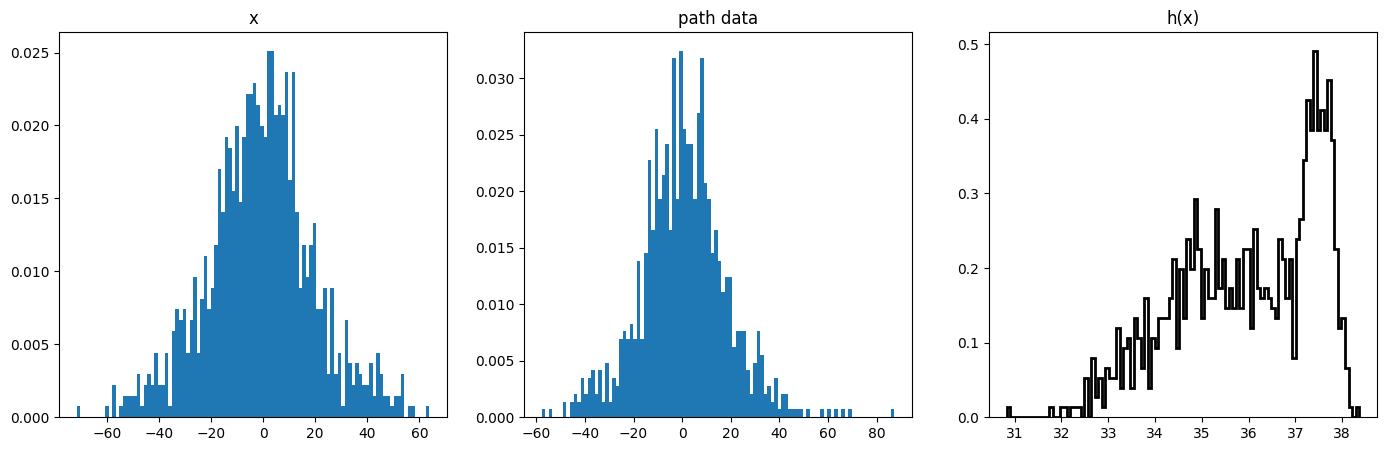

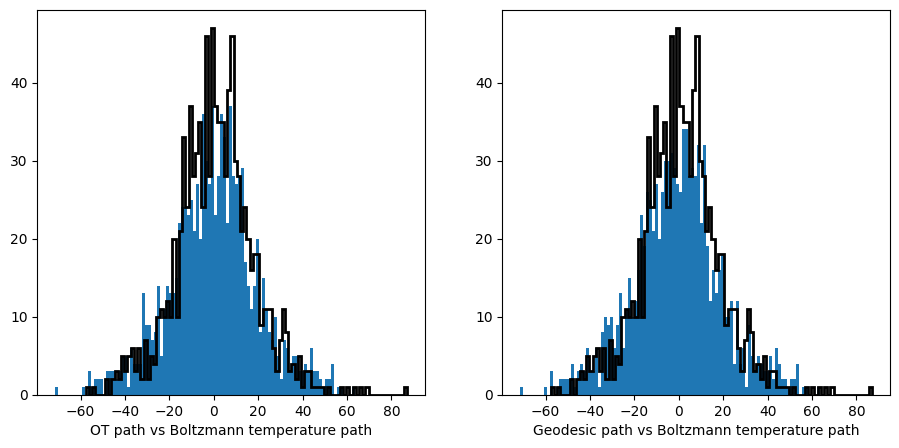

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    170 25694.660156 0.003000
    180 2653.494141 0.000750
    190 430.106903 0.000375
[1, 74671960.0]


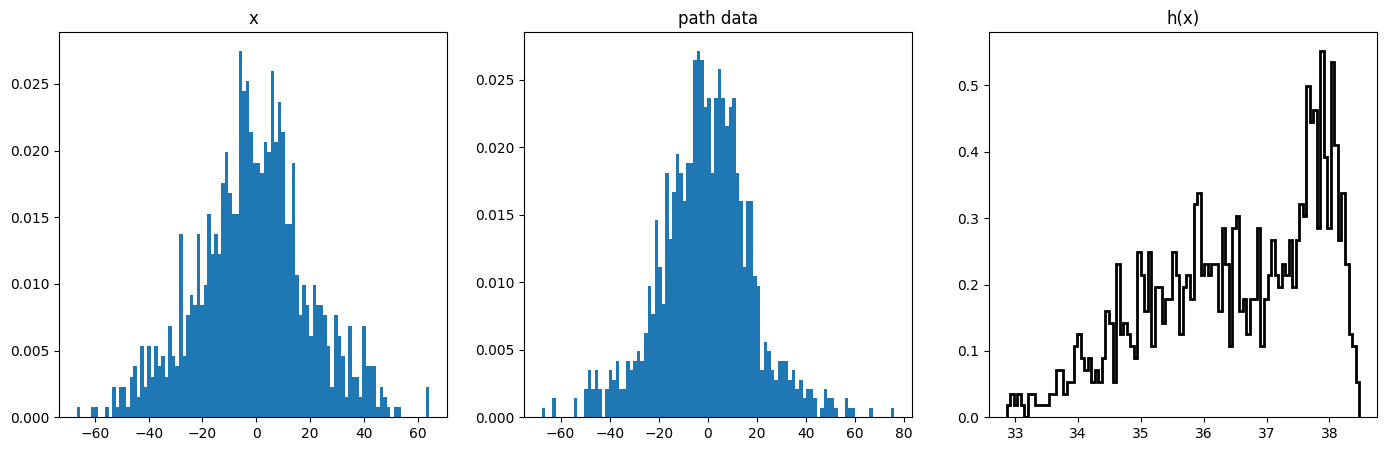

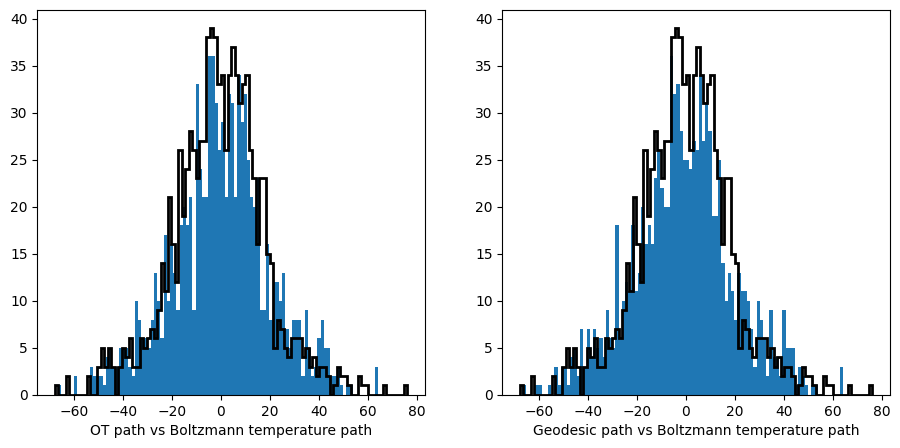

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    199 20683.412109 0.003000
    209 1131.713867 0.001500
    219 490.484802 0.000375
    229 325.352173 0.000188
[2, 136511408.0]


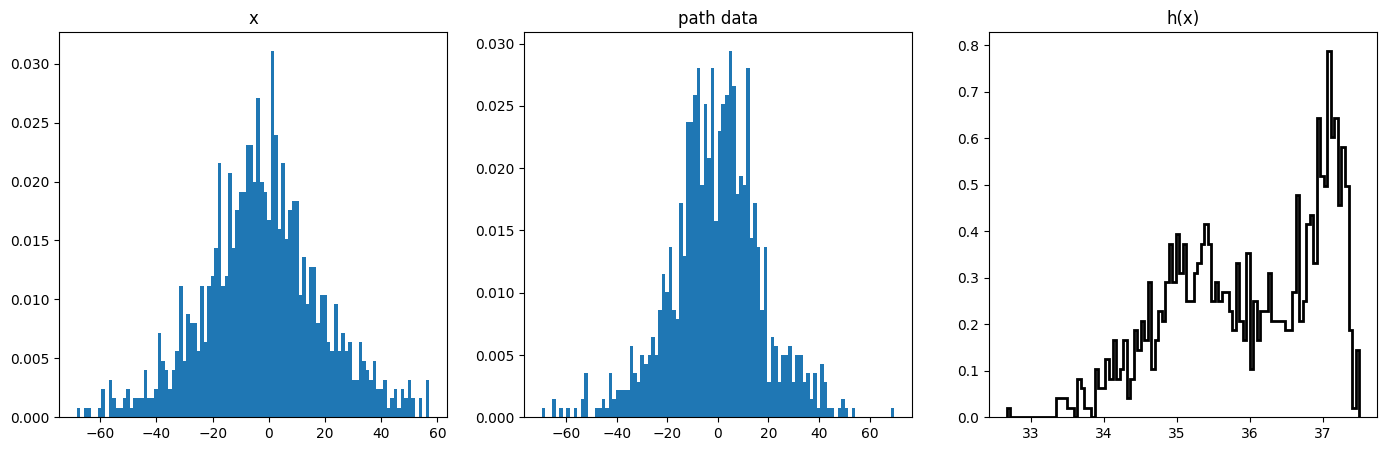

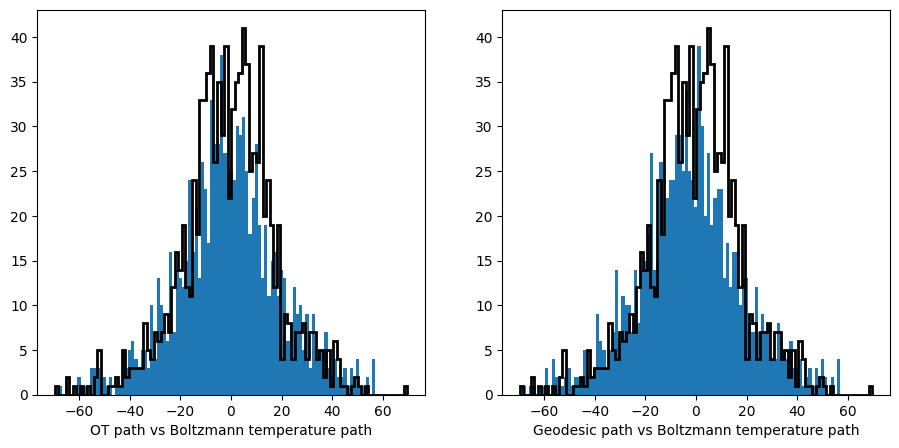

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    231 14572.750977 0.003000
    241 2258.829834 0.000750
    251 638.434326 0.000375
    261 168.612152 0.000375
[3, 65979980.0]


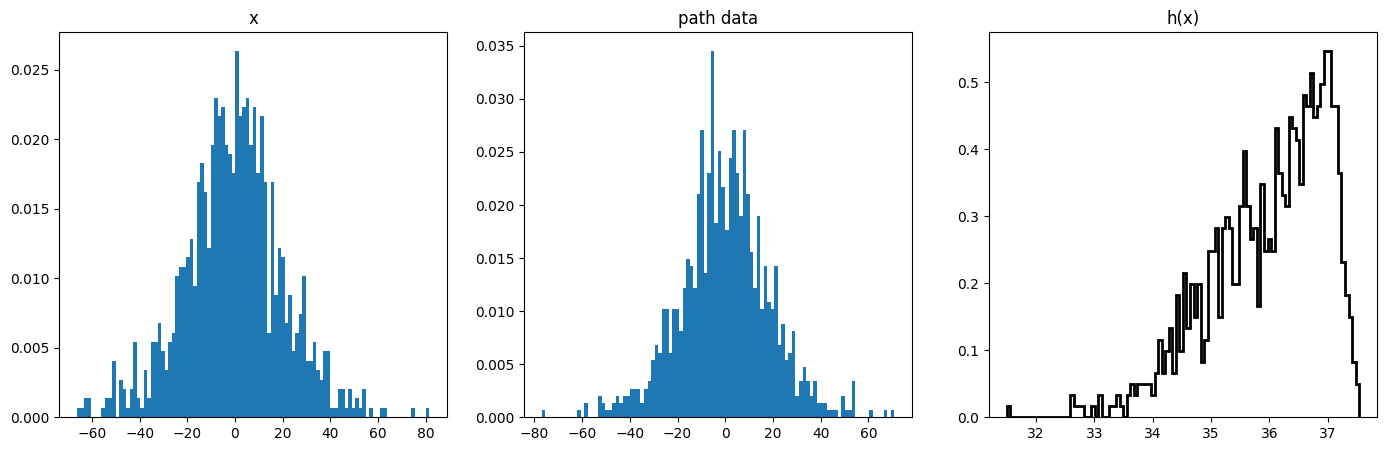

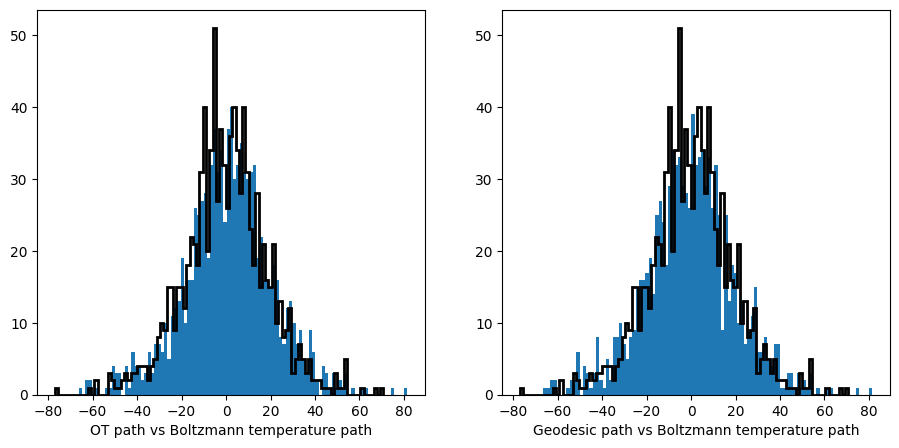

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    269 13019.798828 0.003000
    279 983.979187 0.001500
    289 321.835754 0.000750
    299 317.959778 0.000188
    309 144.810165 0.000188
[4, 114130192.0]


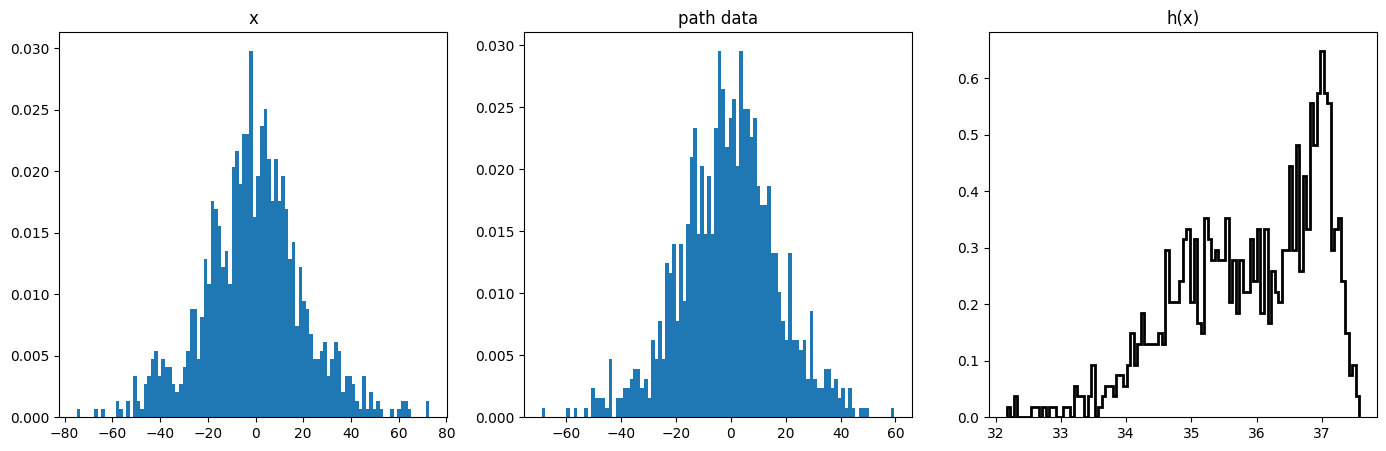

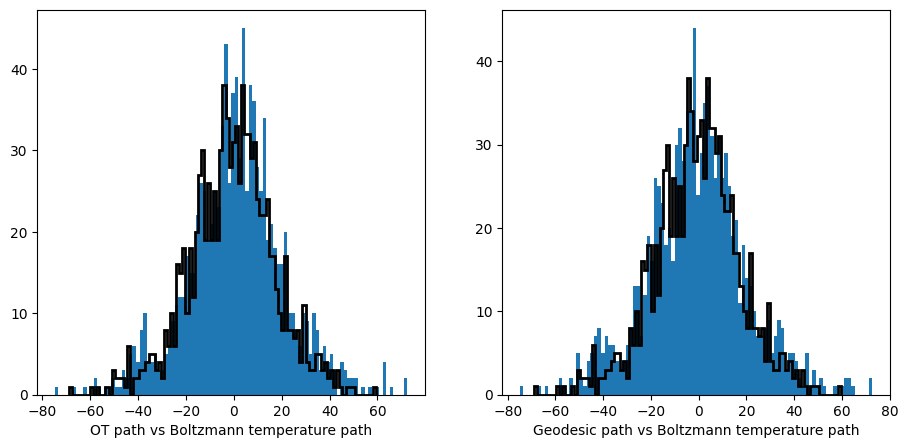

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    316 14124.435547 0.003000
    326 1642.275391 0.000750
    336 270.908844 0.000375
    346 273.240784 0.000094
[5, 103671656.0]


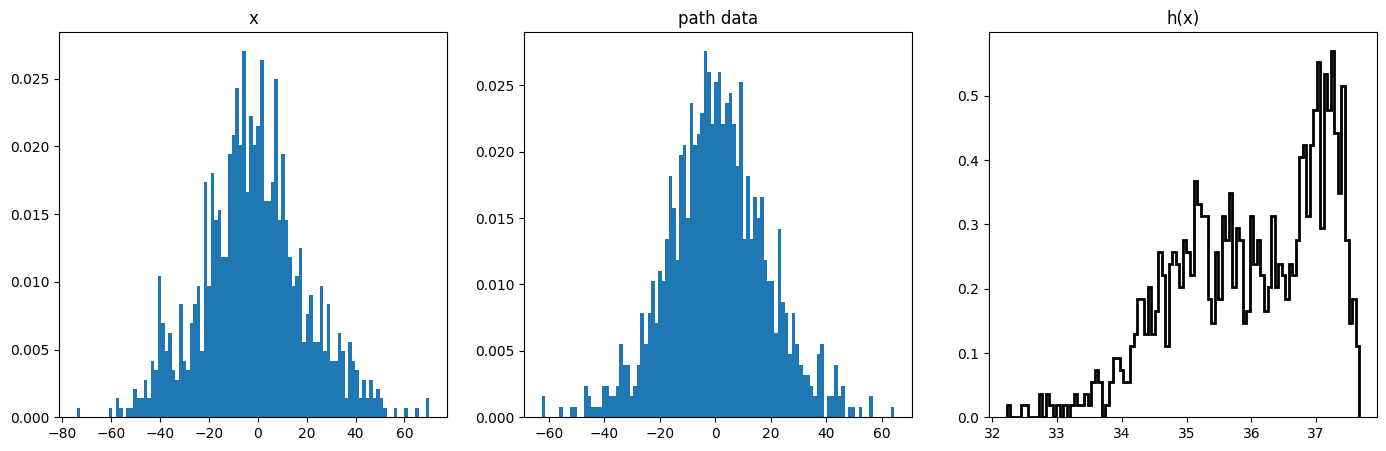

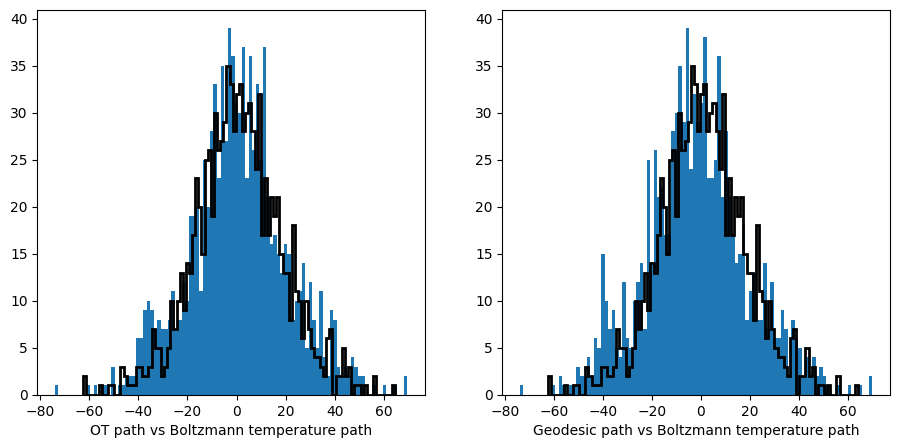

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    346 11695.714844 0.003000
    356 2094.939697 0.000750
    366 581.049805 0.000375
    376 178.570419 0.000375
[6, 138545008.0]


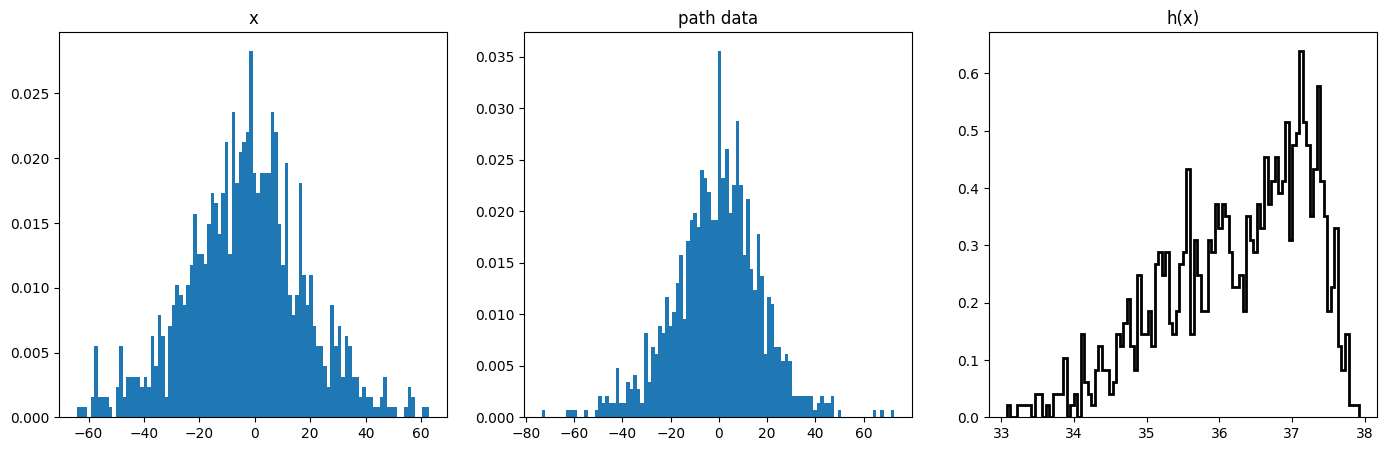

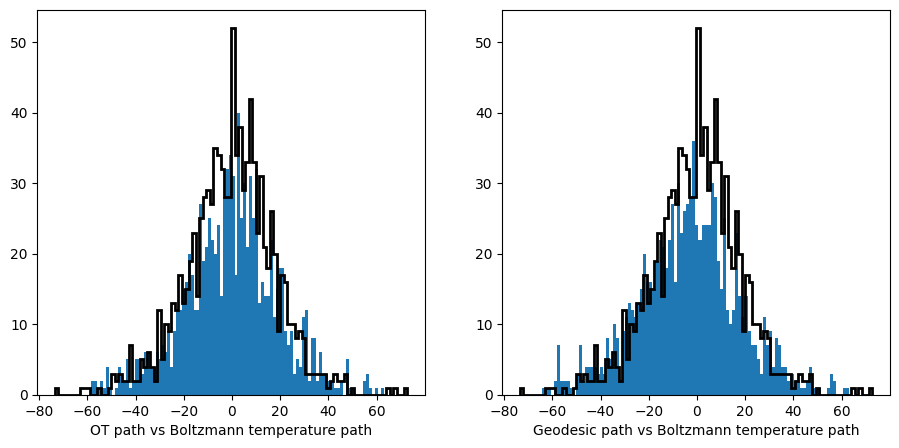

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    382 11812.159180 0.003000
    392 1507.981934 0.000750
    402 239.143646 0.000375
[7, 145901792.0]


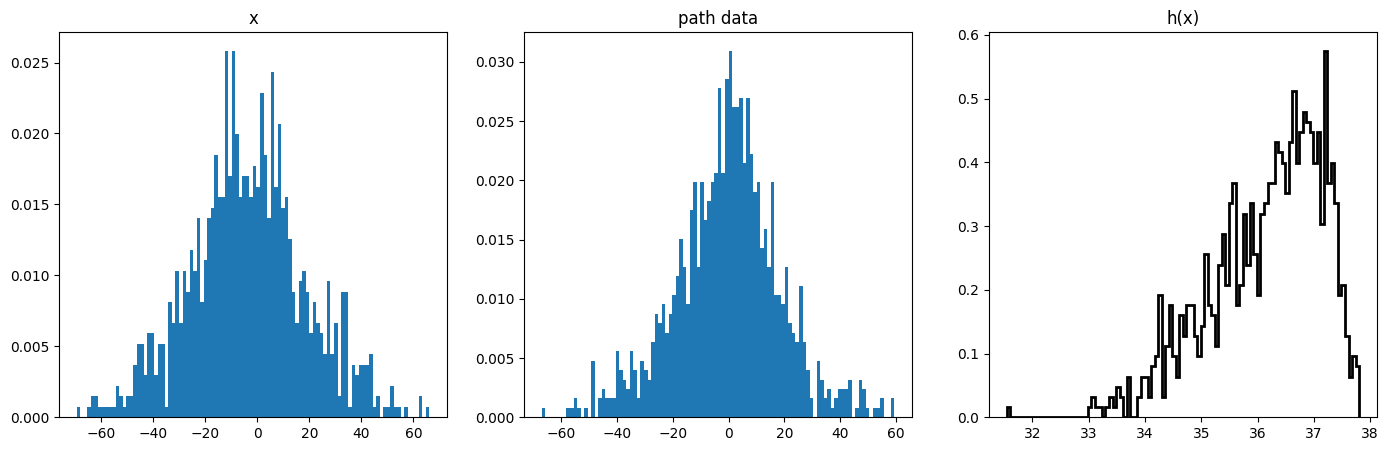

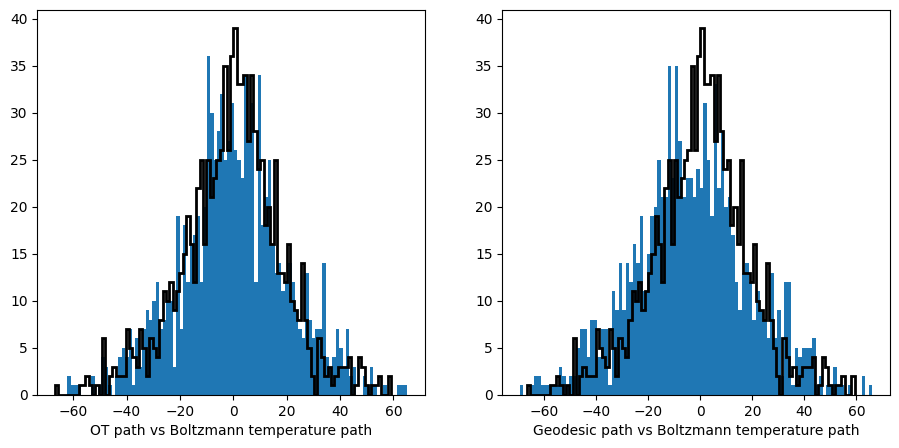

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    411 14602.406250 0.003000
    421 2545.129395 0.000750
    431 389.314606 0.000375
    441 181.382690 0.000375
    451 124.969299 0.000375
[8, 65359832.0]


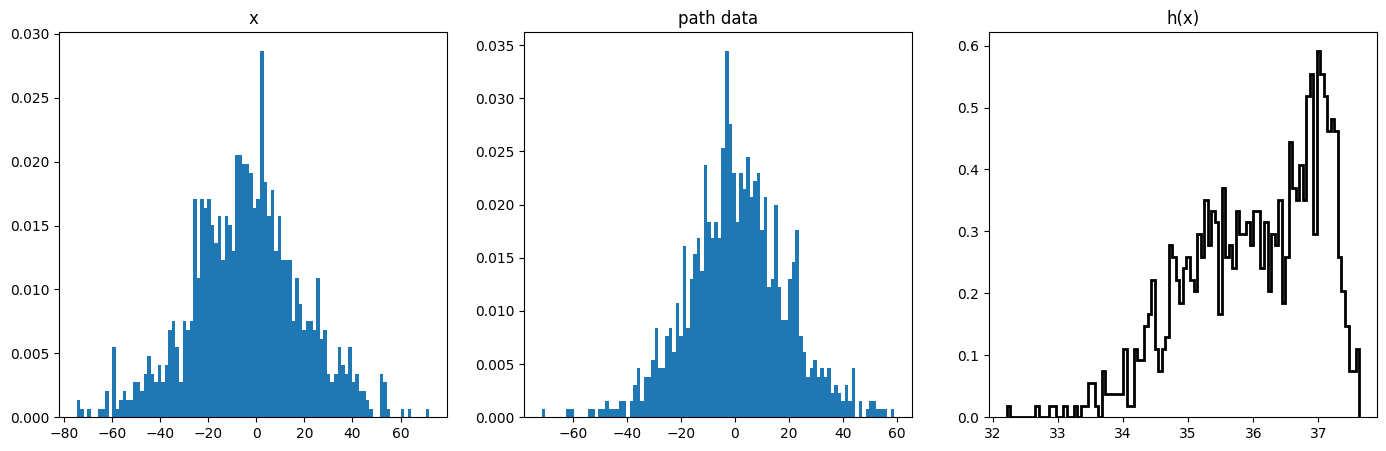

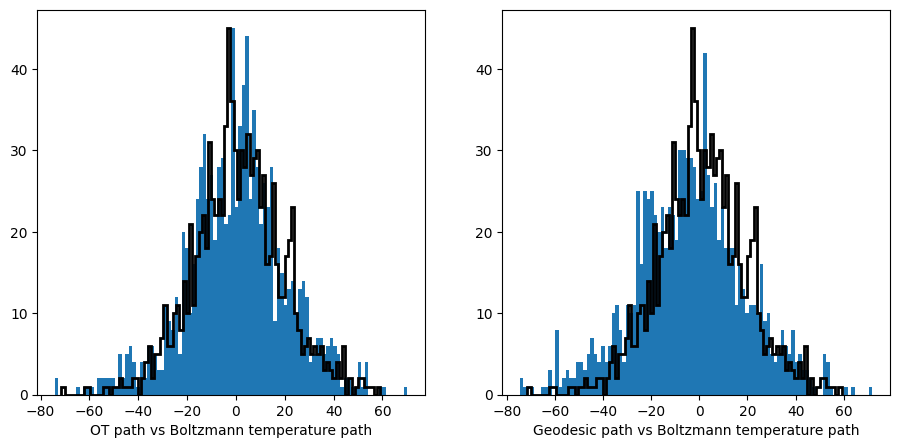

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    460 11053.500000 0.003000
    470 1297.573242 0.000750
    480 242.265167 0.000375
[9, 101922200.0]


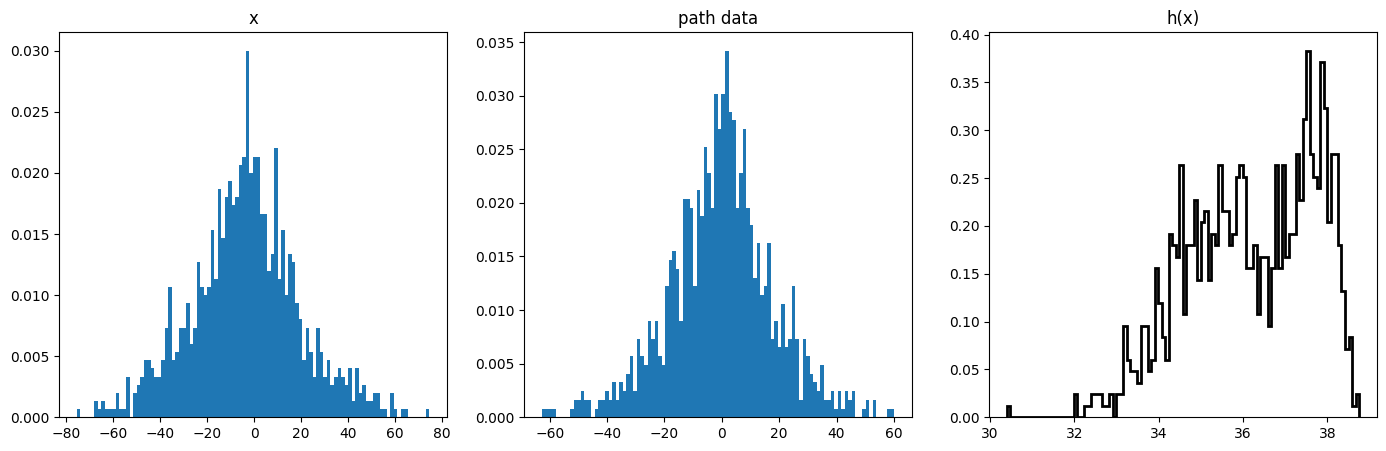

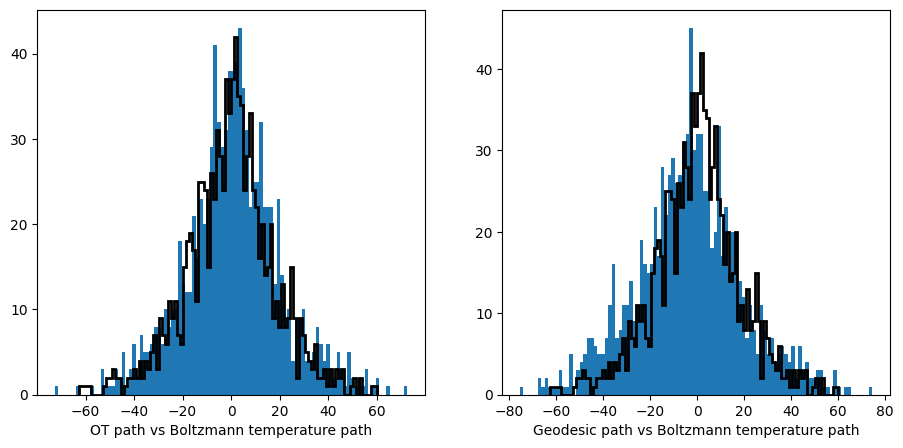

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    489 12166.628906 0.003000
    499 2009.036011 0.000750
    509 285.415100 0.000375
    519 180.604507 0.000188
    529 119.376160 0.000188
[10, 151934352.0]


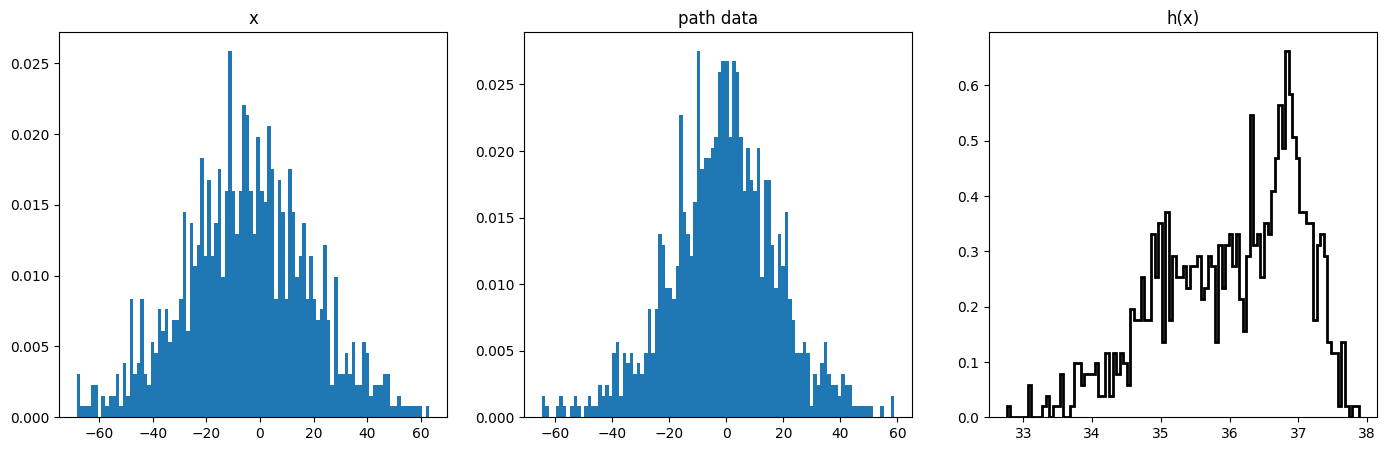

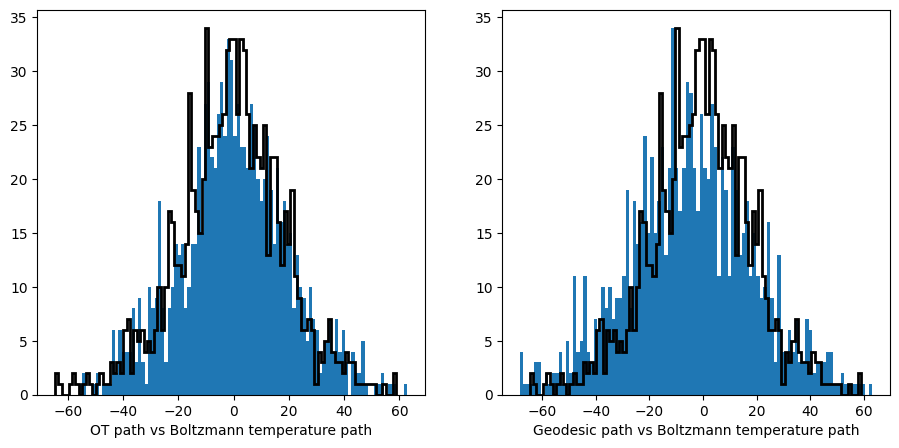

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    531 13088.309570 0.003000
    541 1768.208008 0.000750
    551 156.456650 0.000375
[11, 135621968.0]


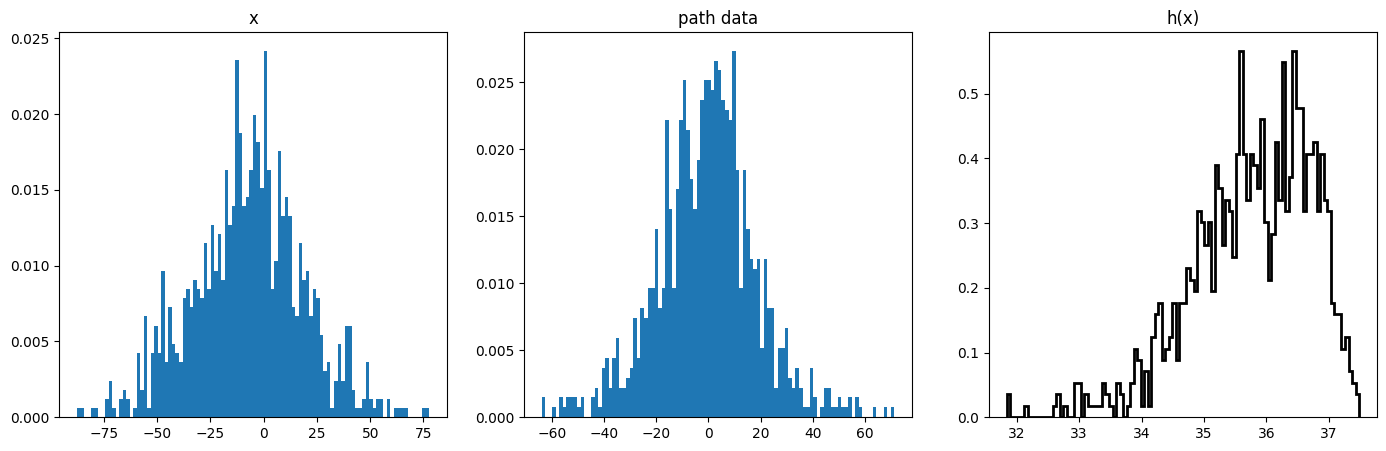

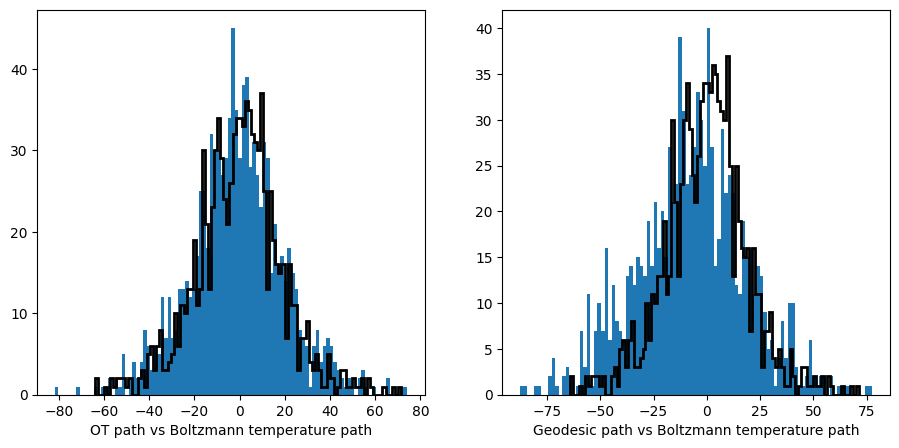

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    558 13258.011719 0.003000
    568 1451.951294 0.000750
    578 262.334839 0.000375
    588 252.874451 0.000094
[12, 117054976.0]


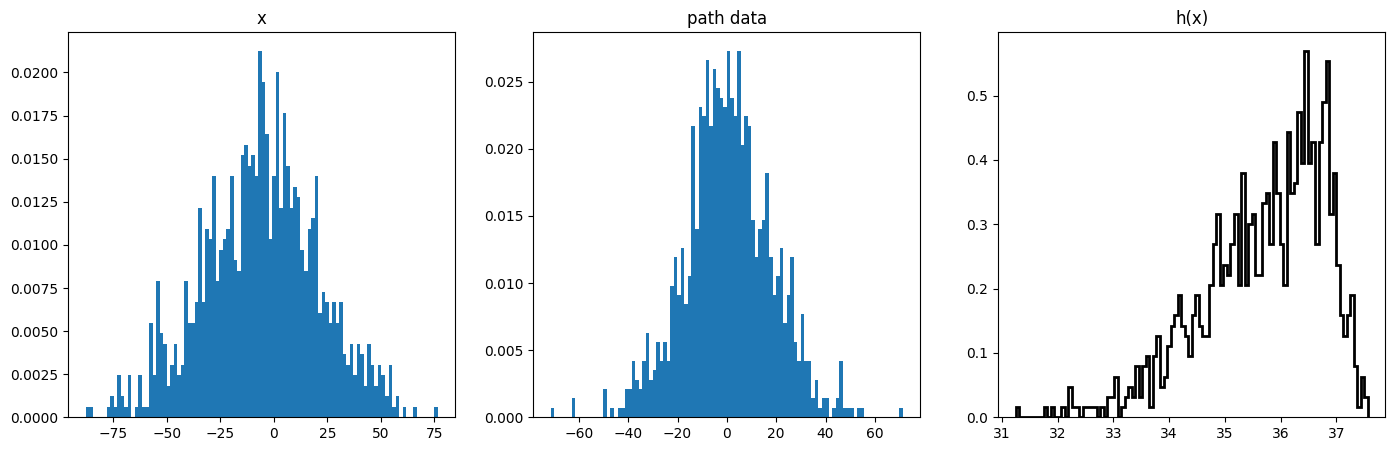

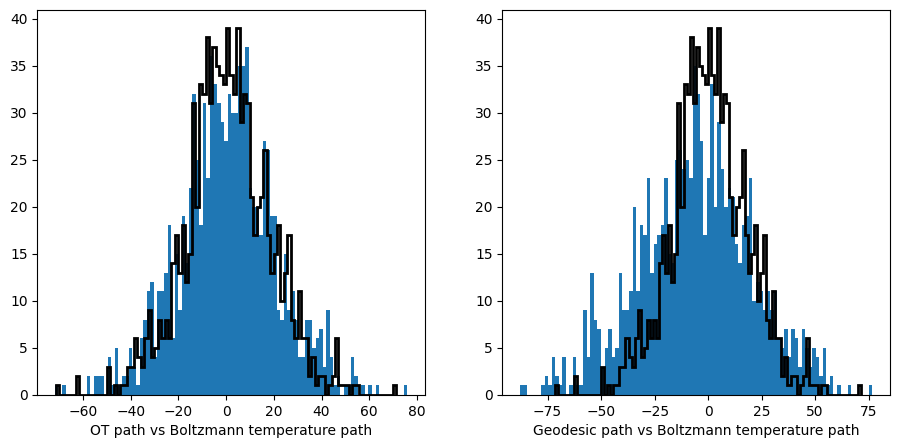

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    588 6724.245117 0.003000
    598 1046.915283 0.000750
    608 372.999664 0.000750
    618 149.088181 0.000375
[13, 118339720.0]


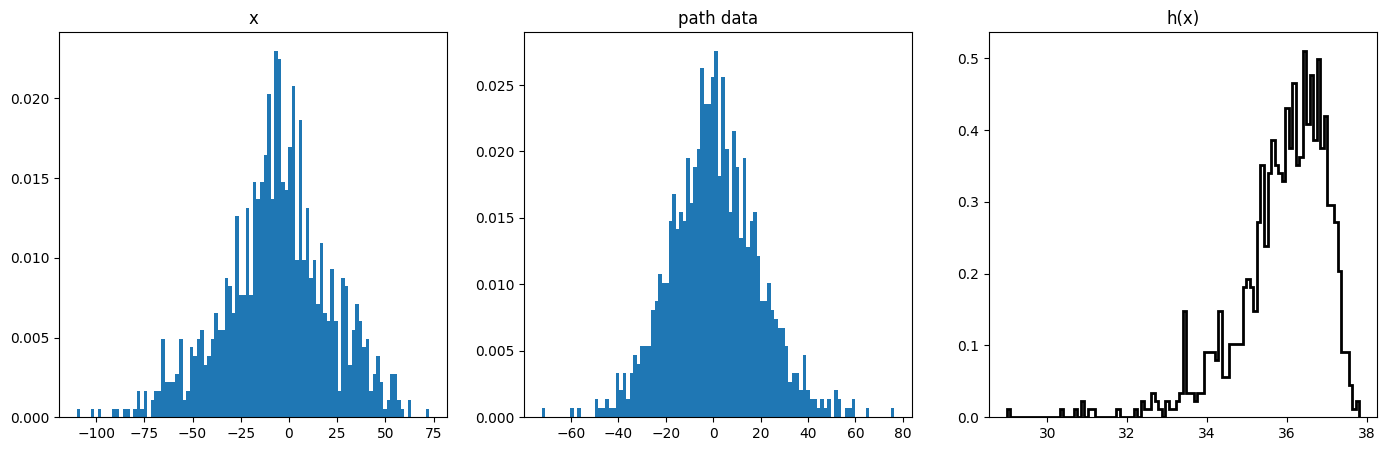

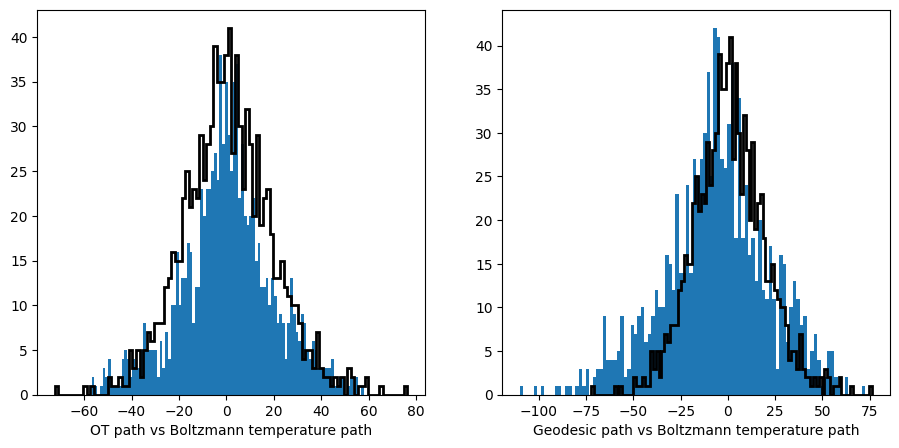

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    627 8775.254883 0.003000
    637 773.786682 0.001500
    647 251.116943 0.000375
    657 227.066864 0.000188
[14, 76619624.0]


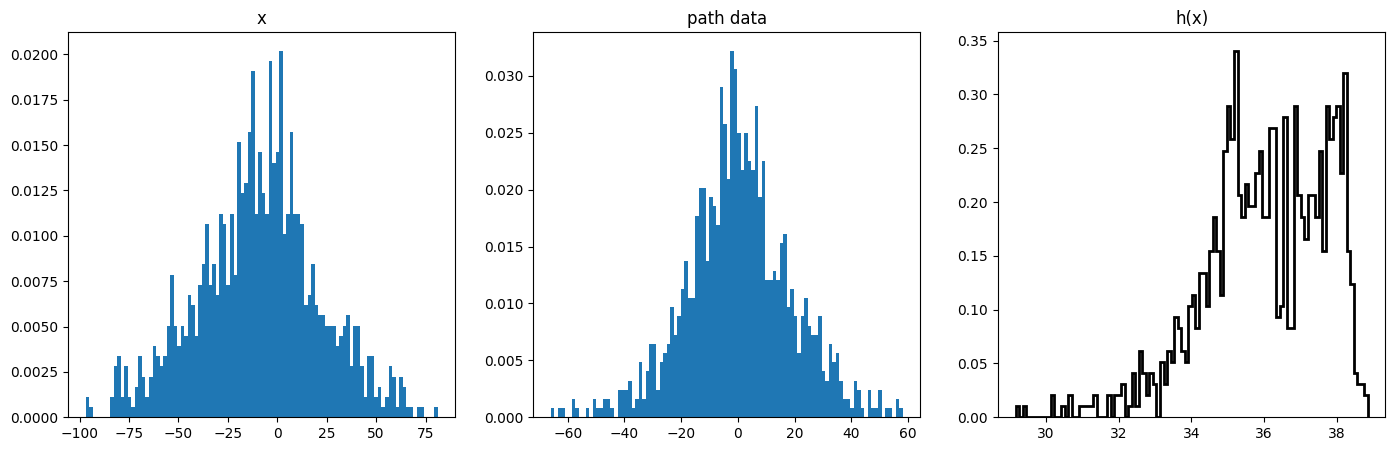

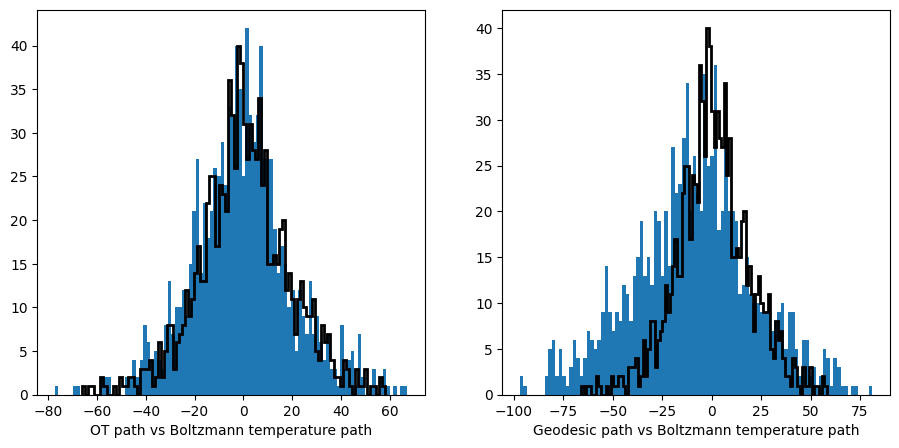

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    658 7521.873047 0.003000
    668 700.563049 0.001500
    678 243.554581 0.000750
    688 230.636765 0.000188
    698 146.279510 0.000188
[15, 98528256.0]


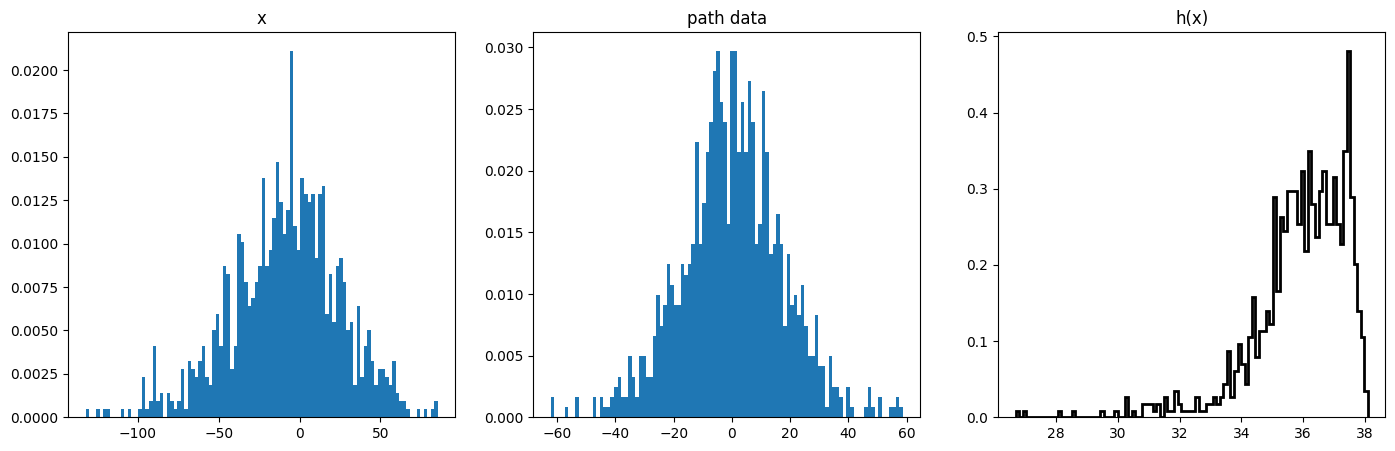

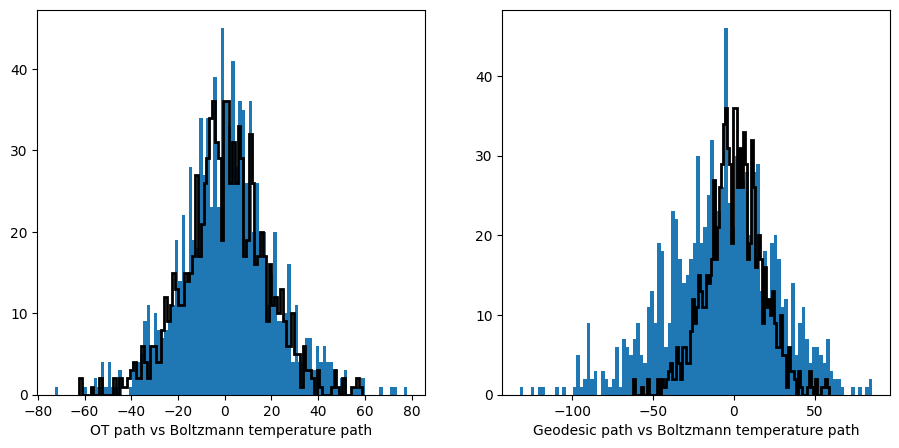

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    702 7372.482422 0.003000
    712 460.284637 0.001500
    722 307.915497 0.000375
    732 271.027832 0.000188
[16, 75509048.0]


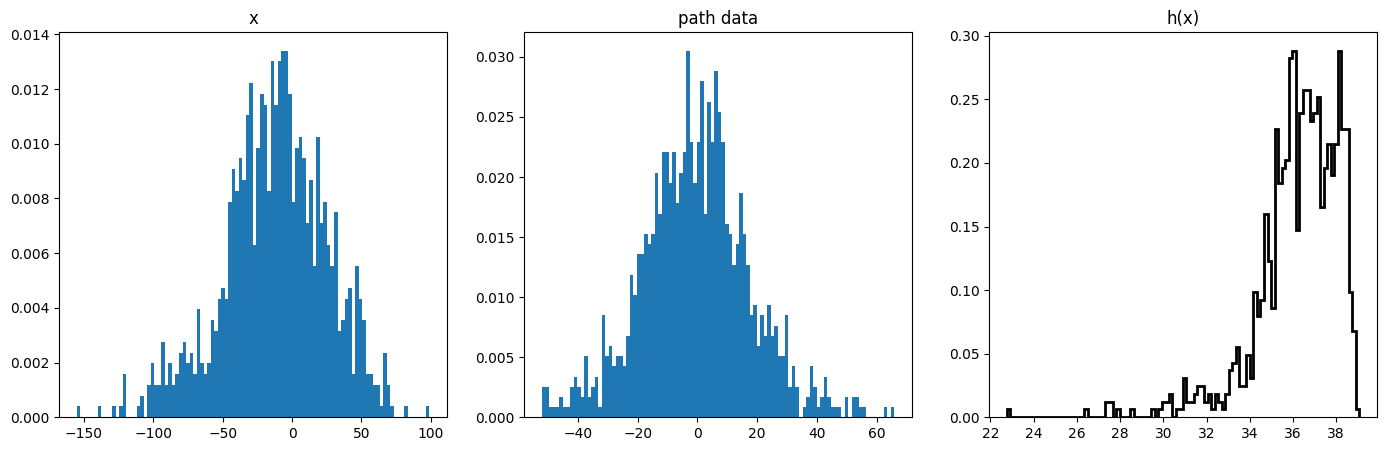

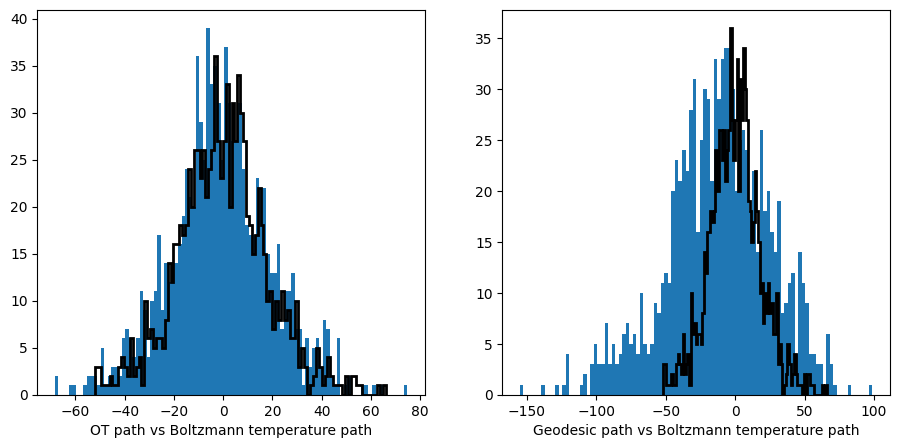

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    734 15134.967773 0.003000
    744 752.442688 0.001500
    754 331.666046 0.000375
    764 328.062531 0.000188
[17, 99798432.0]


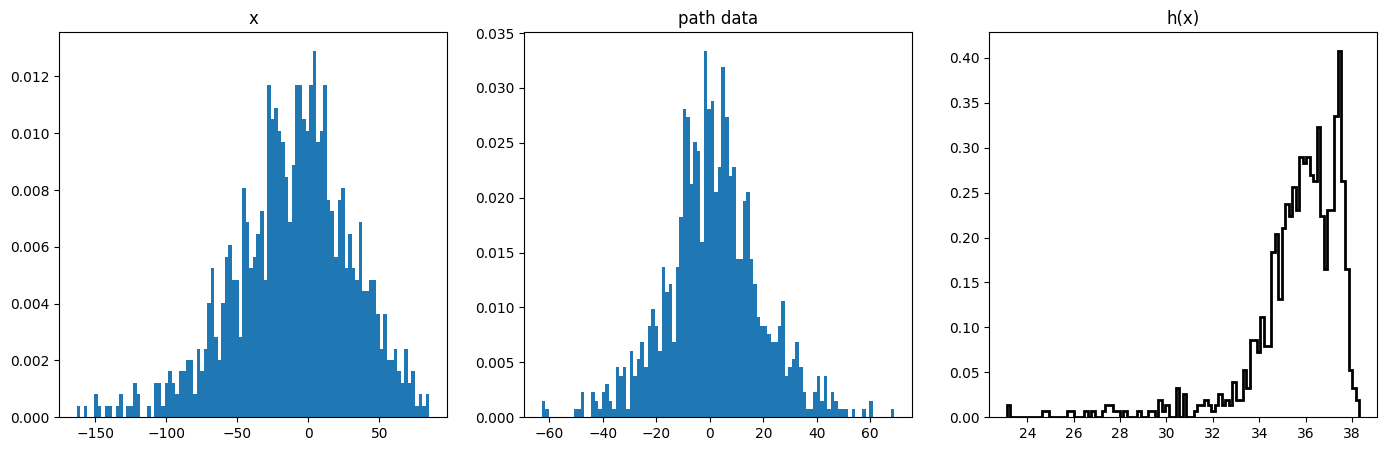

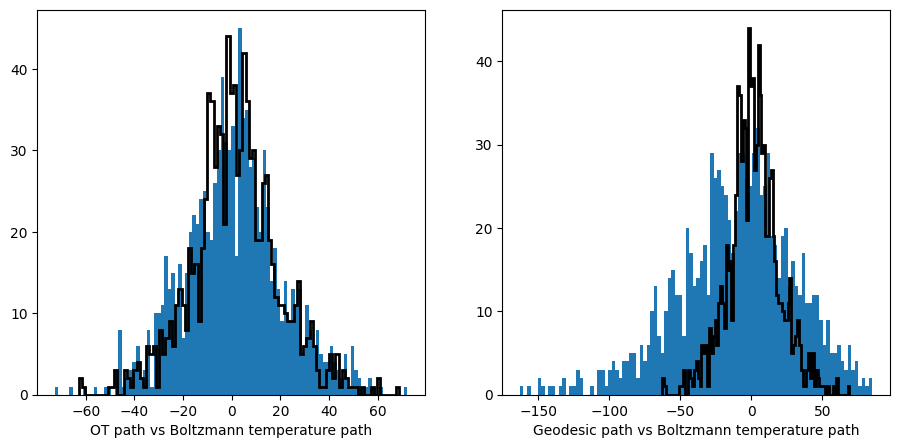

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    765 6133.566895 0.003000
    775 614.823730 0.001500
    785 427.937347 0.000750
    795 422.755463 0.000188
    805 315.452179 0.000188
[18, 45722428.0]


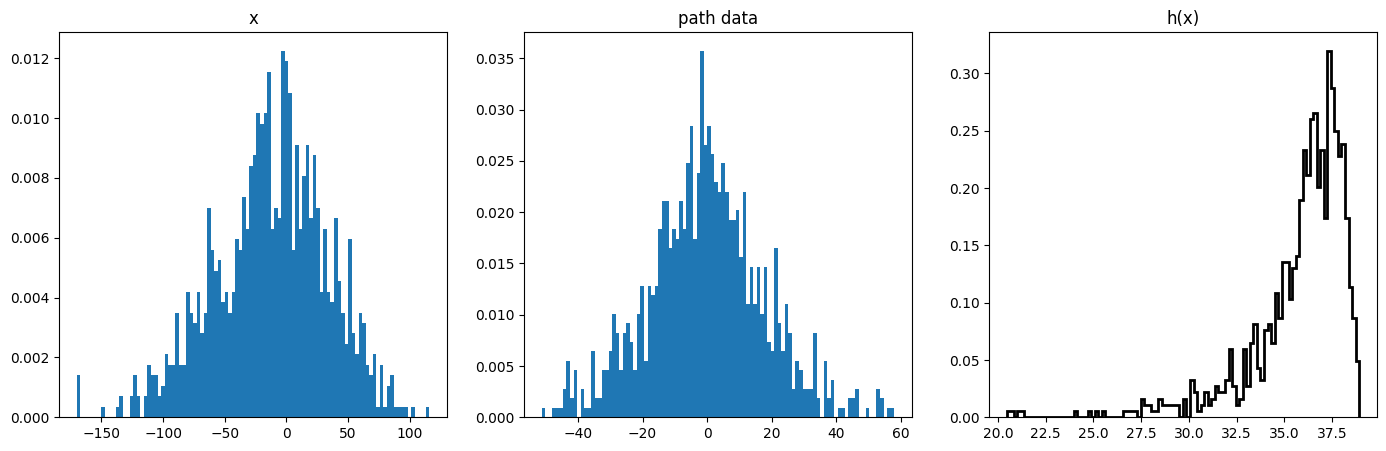

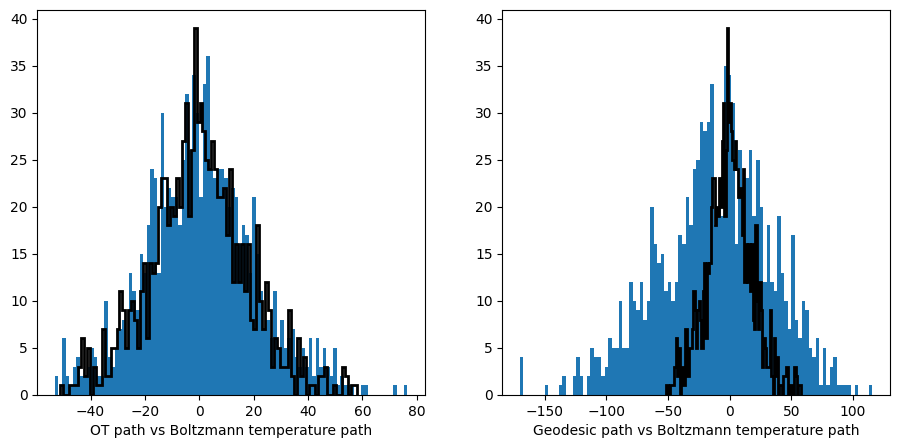

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    814 6724.241699 0.003000
    824 540.842590 0.001500
    834 427.758850 0.000375
    844 382.864166 0.000188
[19, 87670040.0]


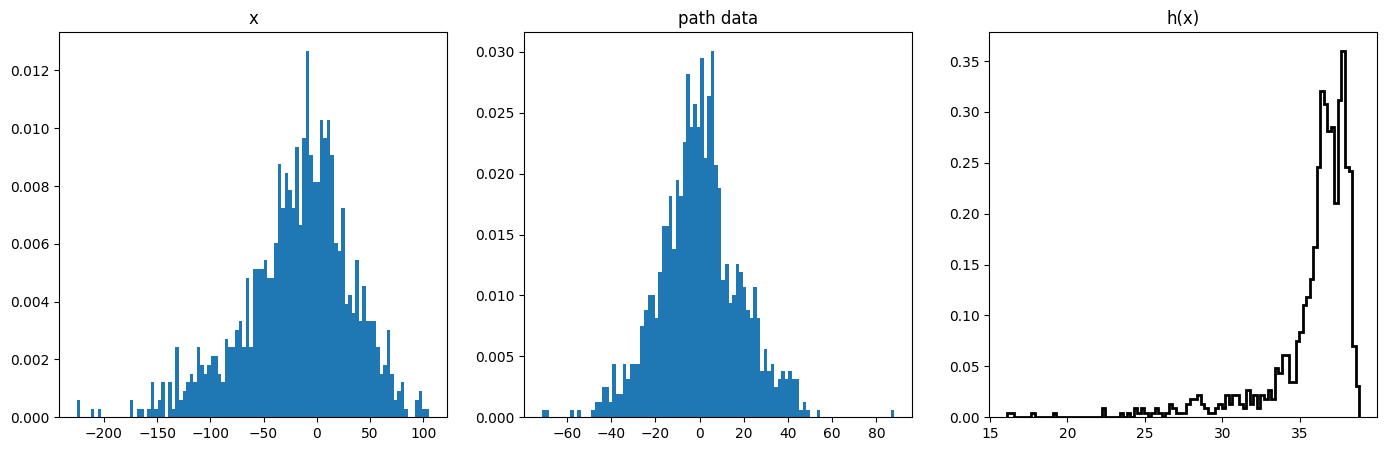

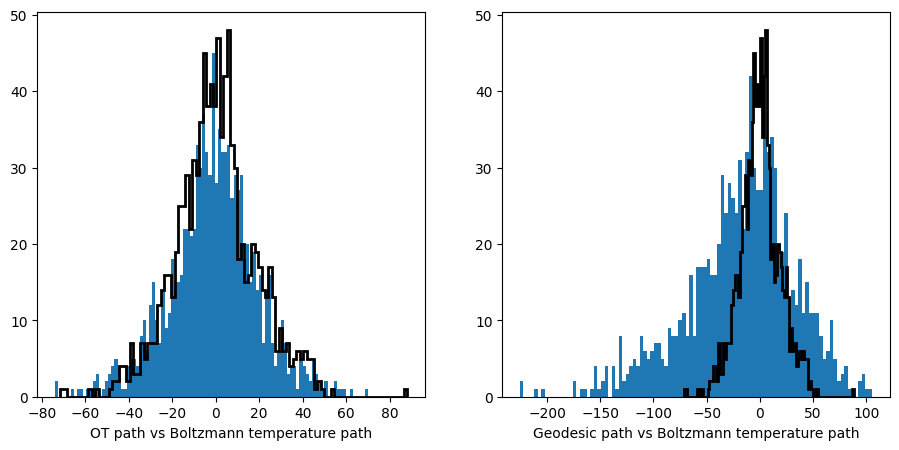

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    846 5791.700684 0.003000
    856 601.121887 0.001500
    866 526.159546 0.000375
    876 498.076691 0.000188
[20, 70025488.0]


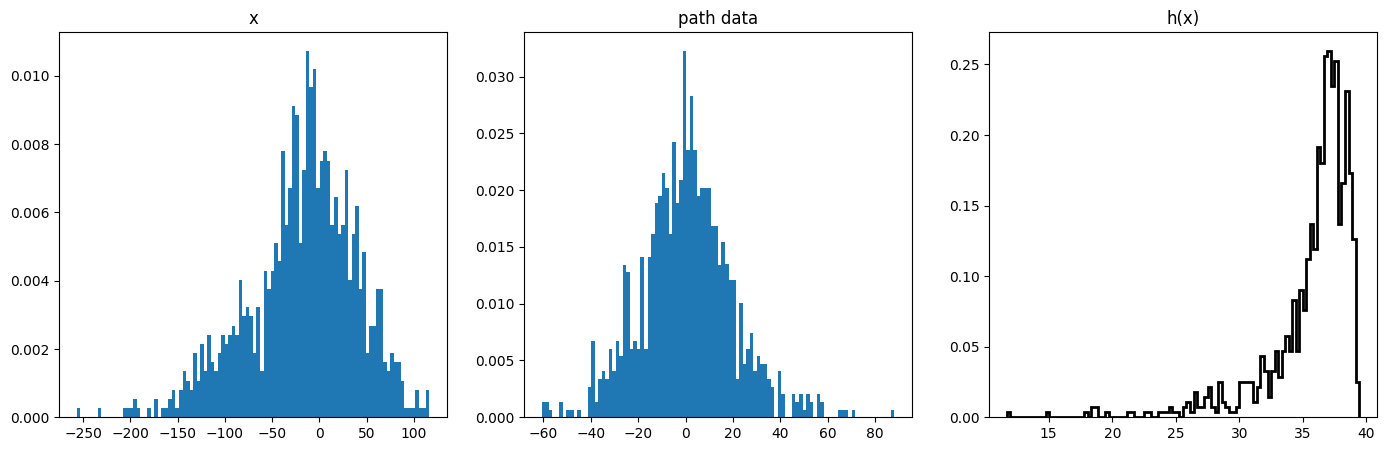

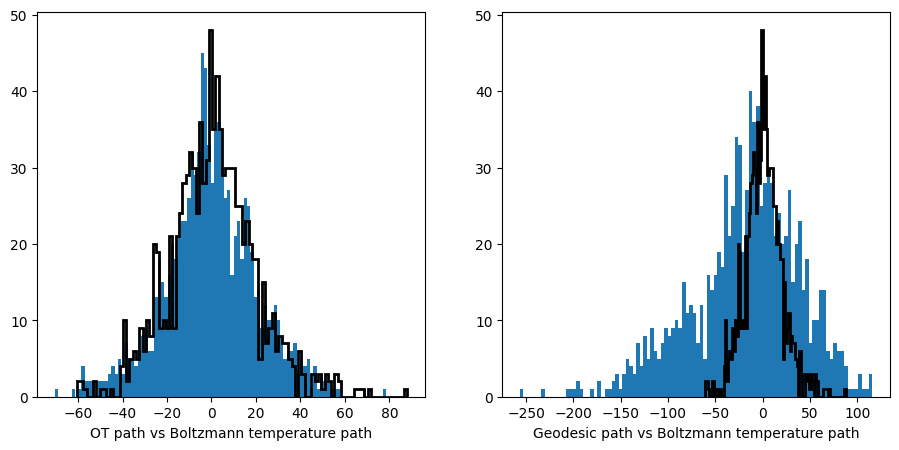

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    878 7010.475586 0.003000
    888 1000.278564 0.001500
    898 731.198486 0.000750
    908 667.121216 0.000375
    918 582.929688 0.000375
[21, 93582688.0]


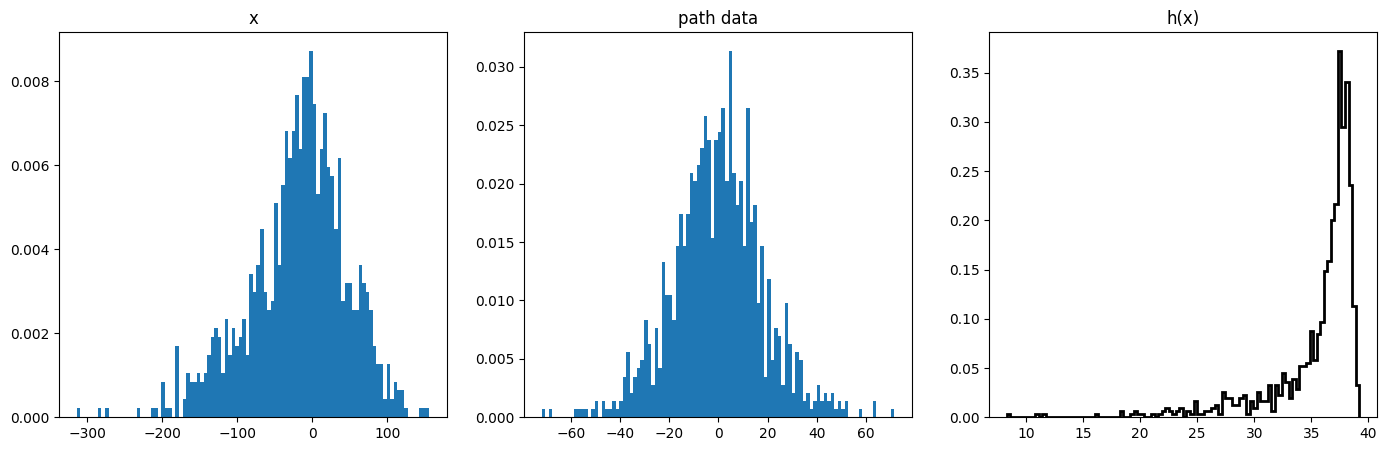

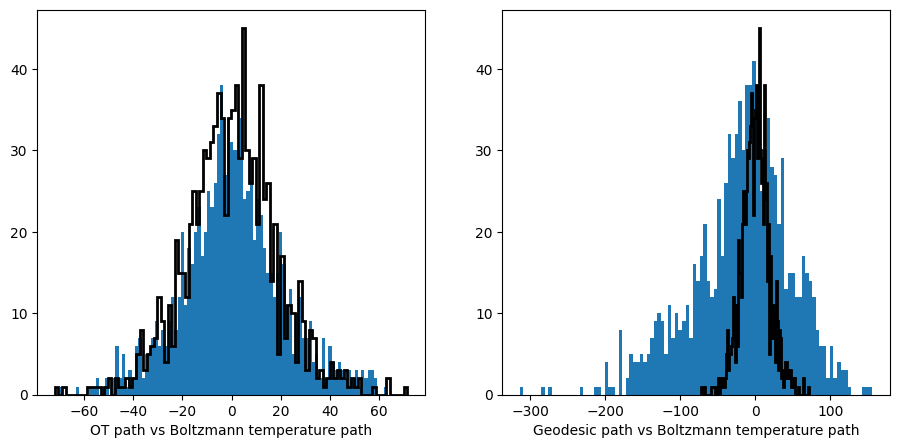

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    927 6699.248535 0.003000
    937 1154.392822 0.001500
    947 1161.025879 0.000375
    957 1072.565430 0.000188
[22, 143939552.0]


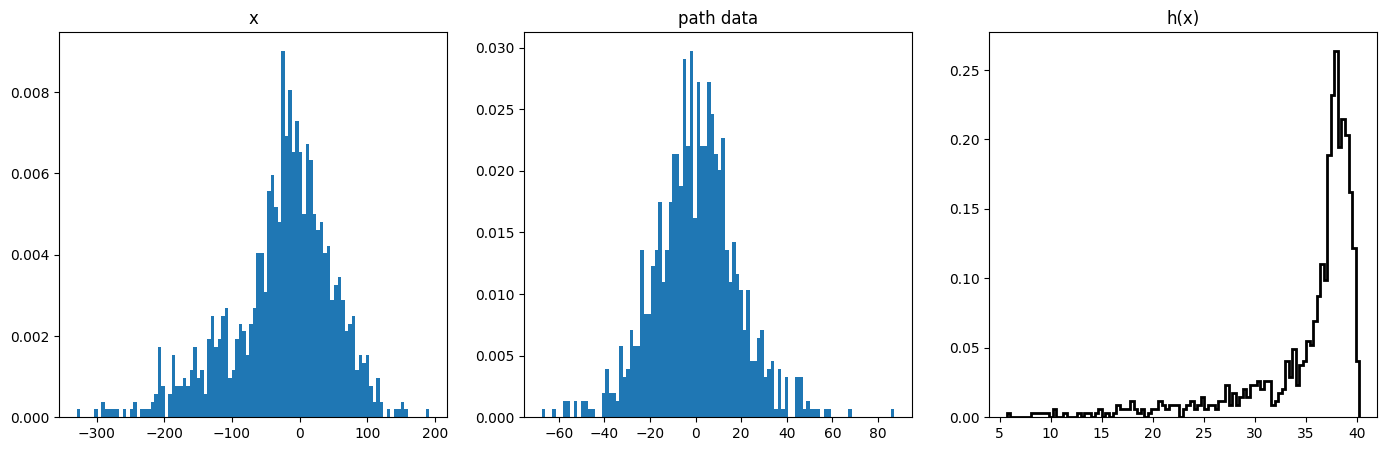

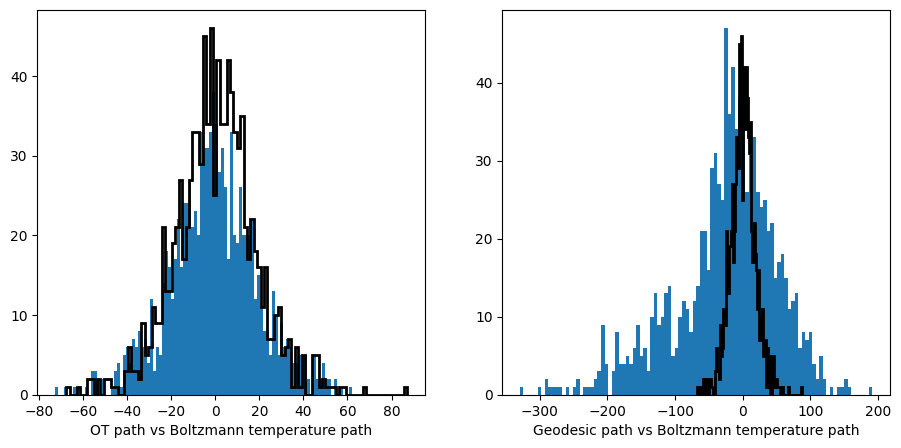

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    960 7057.051270 0.003000
    970 1428.476318 0.001500
    980 1195.773682 0.000750
    990 1181.207764 0.000188
    1000 1093.267212 0.000188
[23, 76888440.0]


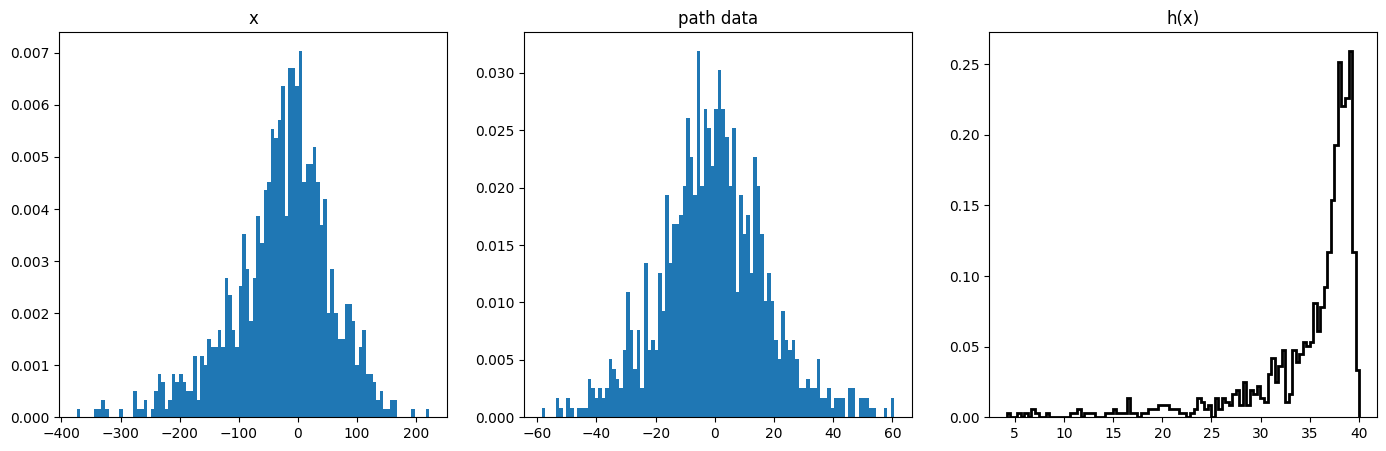

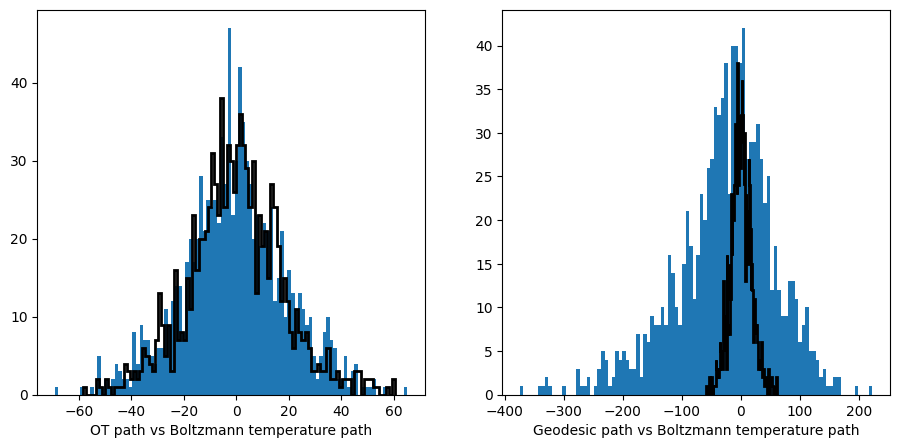

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    1009 4898.253906 0.003000
    1019 1814.803711 0.001500
    1029 1671.232666 0.000750
    1039 1608.567993 0.000375
    1049 1526.882812 0.000375
[24, 84672784.0]


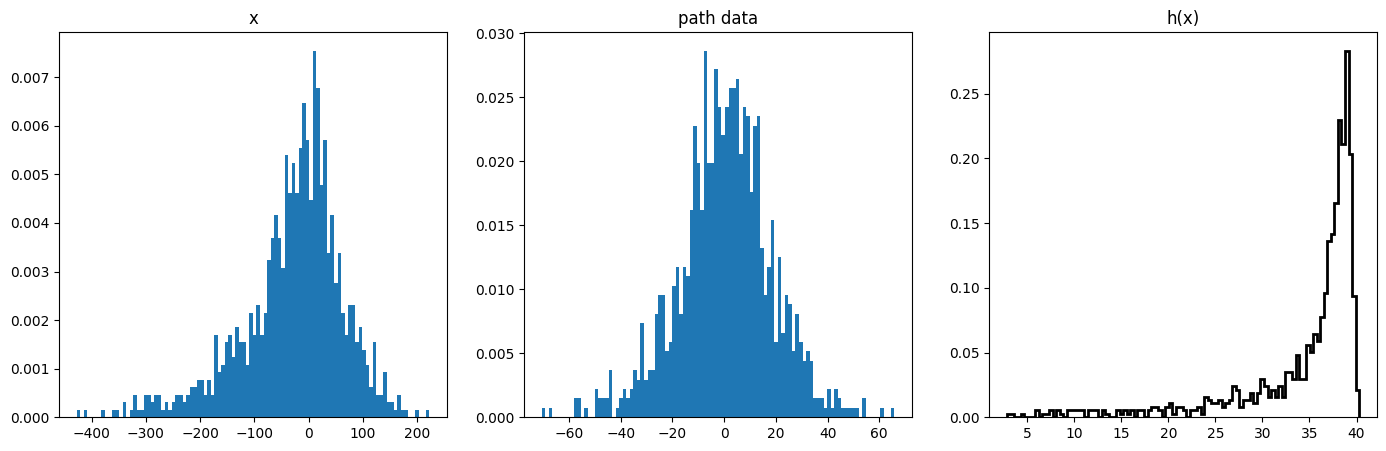

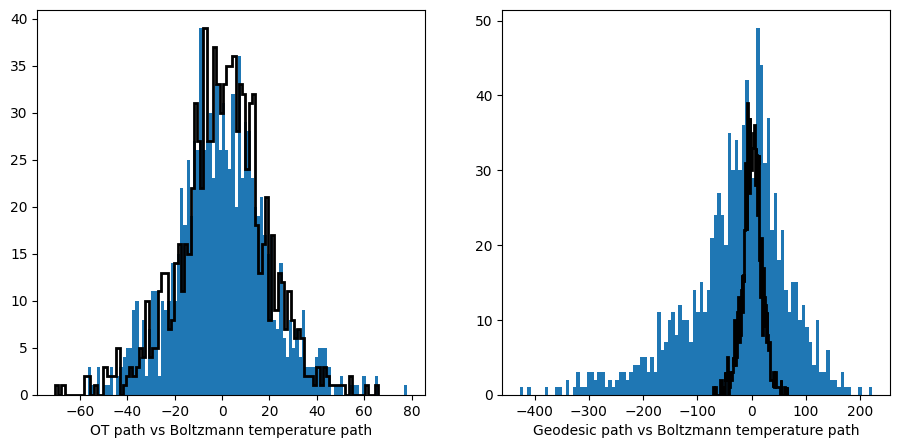

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    1058 5259.631348 0.003000
    1068 1940.763428 0.001500
    1078 1829.922974 0.000375
    1088 1681.192749 0.000375
    1098 1645.713745 0.000375
[25, 65936136.0]


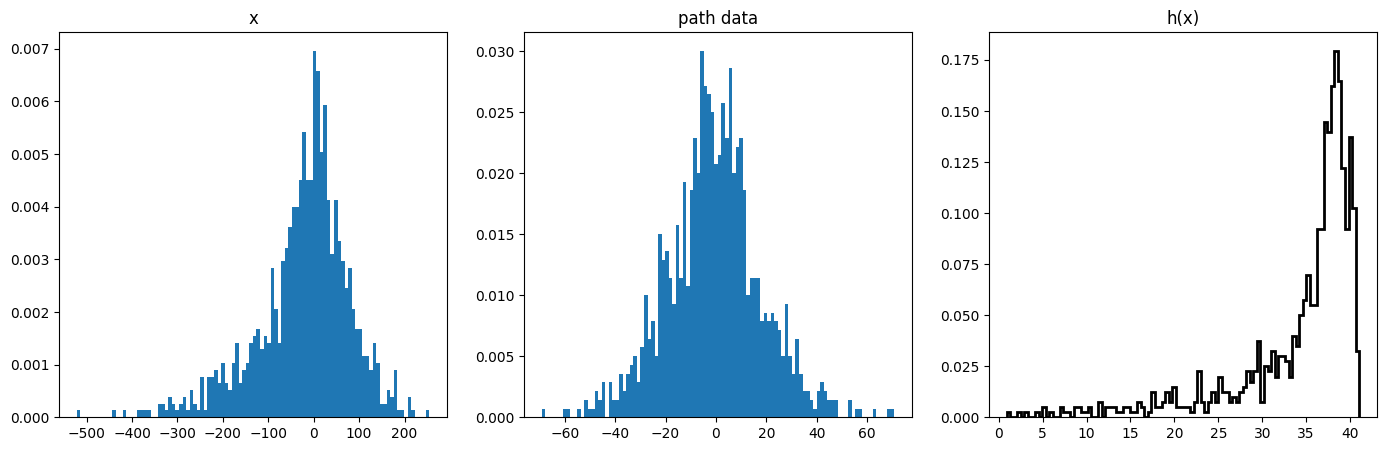

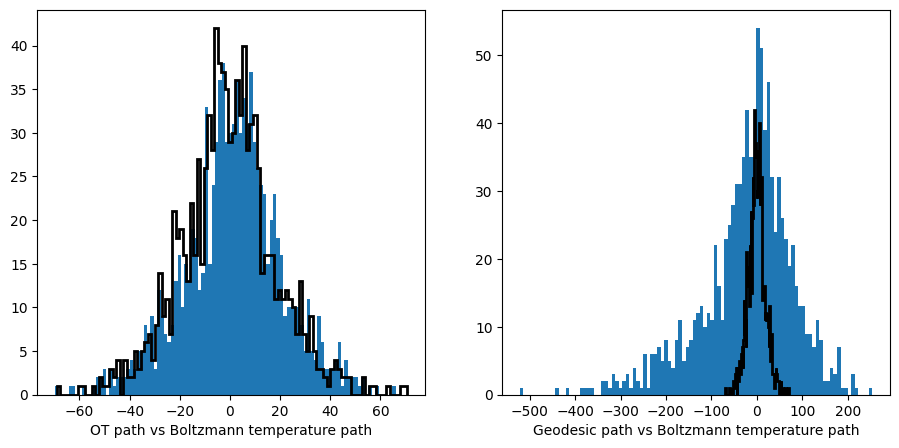

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    1107 7081.562988 0.003000
    1117 2719.983154 0.001500
    1127 2613.209229 0.000375
    1137 2452.591553 0.000375
    1147 2424.540039 0.000188
[26, 190860800.0]


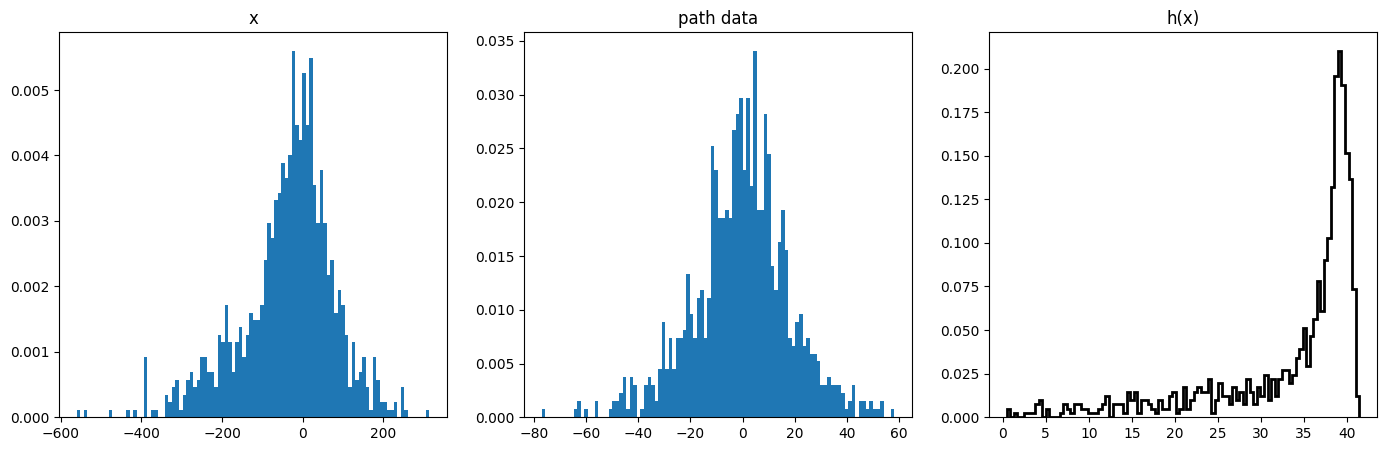

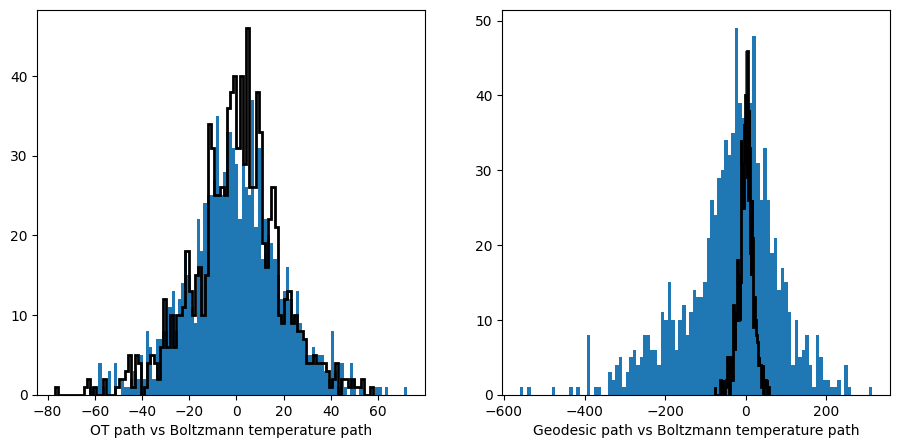

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    1156 8019.140625 0.003000
    1166 3901.025879 0.001500
    1176 3732.660889 0.000375
    1186 3492.585938 0.000375
    1196 3448.776123 0.000375
[27, 97946408.0]


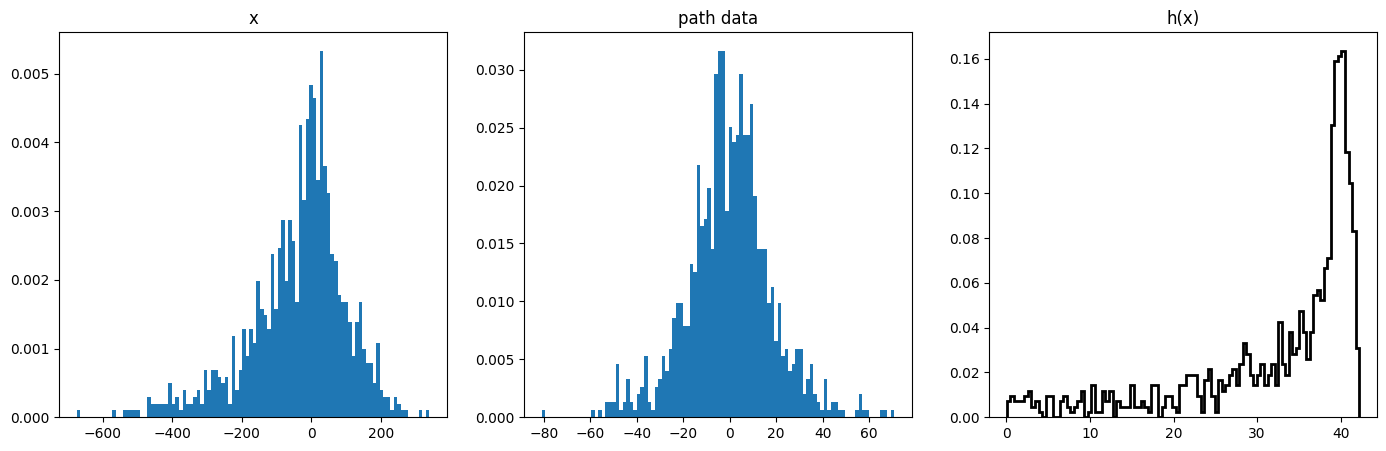

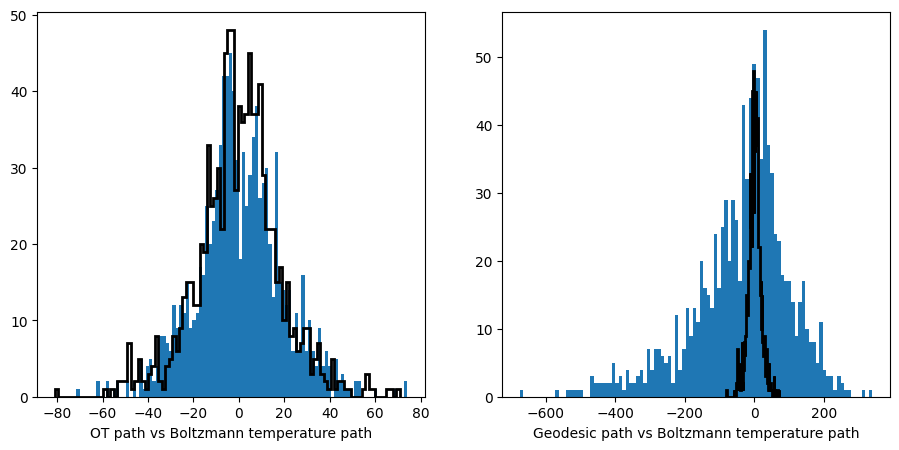

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>>> Optimizing $\omega$ parameters of RBF
    step loss          LR
    1205 6099.902344 0.003000
    1215 3661.090576 0.001500
    1225 3413.129150 0.000750


KeyboardInterrupt: 

In [46]:

sigma_min = 0.0001
sample_size = 10**3
l_curve_score_tune = []
print('[Time step, score_loss, otflow_loss]')
for training_step in range(10000):
    sample_t, sample_path, sample_ot = sample_batch_path(sample_size)
    sample_t = torch.from_numpy(sample_t).to(torch.float32).requires_grad_(True)
    sample_ot = torch.from_numpy(sample_ot).to(torch.float32)
    beta = 1./(10.-6.0/(1-sigma_min)*sample_t).sqrt()
    noise = torch.normal(mean=torch.zeros_like(sample_ot), std=beta)
    geo_interpolant = model_s_t(torch.cat([sample_t, sample_ot+noise], dim=1))
    sample_x = sample_ot + sample_t*(1-sample_t) * geo_interpolant
    geo_interpolant_tderiv = torch.autograd.grad(outputs=geo_interpolant, inputs=sample_t, 
                                                 grad_outputs=torch.ones_like(geo_interpolant),
                                                 create_graph=True)[0]
    
    sigma_t =  1 - (1-sigma_min) * sample_t 
    u_t_xx = sample_ot/sigma_t + sample_t*(1-sample_t) * geo_interpolant_tderiv + (1.-2.*sample_t)*geo_interpolant
    if ((training_step % 1) == 0):
        g_sample_x = g_land_rbf(sample_x, torch.from_numpy(sample_path), sample_t, plot_h = True)
    else:
        g_sample_x = g_land_rbf(sample_x, torch.from_numpy(sample_path), sample_t, plot_h = False)
    # score_loss = torch.bmm(u_t_xx.unsqueeze(1), torch.bmm(g_sample_x, u_t_xx.unsqueeze(2))).mean() + ((sample_x - torch.from_numpy(sample_path))**2).mean() # constraint by d(sample_x, sample_path)
    score_loss = torch.bmm(u_t_xx.unsqueeze(1), torch.bmm(g_sample_x, u_t_xx.unsqueeze(2))).mean() + ((sample_x.sum(-1) - torch.from_numpy(sample_path).sum(-1))**2).mean() # constraint by d(Magnetization_x, magnetization_path)


    # Before the backward pass, zero all of the network gradients
    optimizer_s.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    score_loss.backward()
    # Calling the step function to update the parameters
    optimizer_s.step()
    
    if ((training_step % 1) == 0):
        l_curve_score_tune.append([training_step,score_loss.item()])
    if ((training_step % 1) == 0):
        print([training_step, score_loss.item()])

        plt.figure(figsize=(11,5))
        plt.subplot(121)
        plt.hist(sample_ot.sum(-1), bins=100)
        plt.hist(sample_path.sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2)
        plt.xlabel("OT path vs Boltzmann temperature path")
        plt.subplot(122)
        plt.hist(sample_x.detach().numpy().sum(-1), bins=100)
        plt.hist(sample_path.sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2)
        plt.xlabel("Geodesic path vs Boltzmann temperature path")
        plt.show()
    if training_step % 100 == 0:
        torch.save(model_s_t.state_dict(), 'checkpoint_geointerpolant.pth')
        torch.save(optimizer_s.state_dict(), "checkpoint_geointerpolant_optimizer.pth")
        torch.save(model_s_t.state_dict(), f'checkpoint_geointerpolant-epoch{training_step+start_epoch}.pth')
        torch.save(optimizer_s.state_dict(), f"checkpoint_geointerpolant_optimizer-epoch{training_step+start_epoch}.pth")

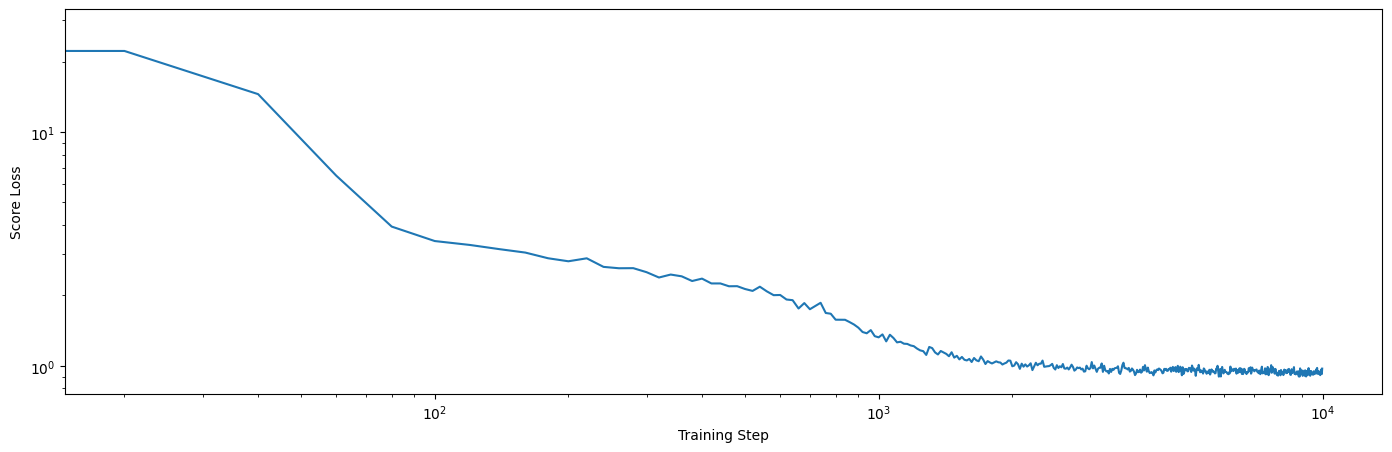

In [124]:

l_curve_score_tune = np.array(l_curve_score_tune)
plt.loglog(l_curve_score_tune[:,0], l_curve_score_tune[:,1])
plt.xlabel('Training Step')
plt.ylabel('Score Loss')
plt.show()

## OT flow

In [21]:
num_steps=10
sample_size=10**5
plot_Tflow_t = []
plot_Tflow_t.append(sample_batch_prior(size=sample_size))
print("t    beta    kBT")
for ii in range(1,11):
    beta = 1./(10.-6.0*ii*(num_steps//10)/num_steps)
    print(ii, beta, (10.-6.0*ii*(num_steps//10)/num_steps))
    ising_t = Ising(6,2,beta)
    xx = ising_t.sample(sample_size, thermalSteps=1000, initial=torch.from_numpy(plot_Tflow_t[-1]))
    plot_Tflow_t.append(xx.detach().numpy())
plot_Tflow_t = np.array(plot_Tflow_t)

t    beta    kBT
1 0.10638297872340426 9.4
2 0.11363636363636363 8.8
3 0.12195121951219513 8.2
4 0.13157894736842105 7.6
5 0.14285714285714285 7.0
6 0.15625 6.4
7 0.1724137931034483 5.8
8 0.1923076923076923 5.2
9 0.2173913043478261 4.6
10 0.25 4.0


In [22]:
def plot_ot_flow(model_u_t):
    num_steps=10
    sample_size = 10**5
    # xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx = torch.from_numpy(sample_batch_prior(size=sample_size))
    xx_t = []
    xx_t.append(xx.detach().numpy())

    for ii in range(10):
        tt = ii / 10
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model_u_t(samples)
        xx = xx + u_t * 0.1
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)

    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii*(num_steps//10))+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
        axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-8, 8), (-8, 8)]))
        axes[ii_x,ii_y].set_xlim([-8,8])
        axes[ii_x,ii_y].set_ylim([-8,8])
    
    plt.show()

    return xx_t



<Figure size 1700x500 with 0 Axes>

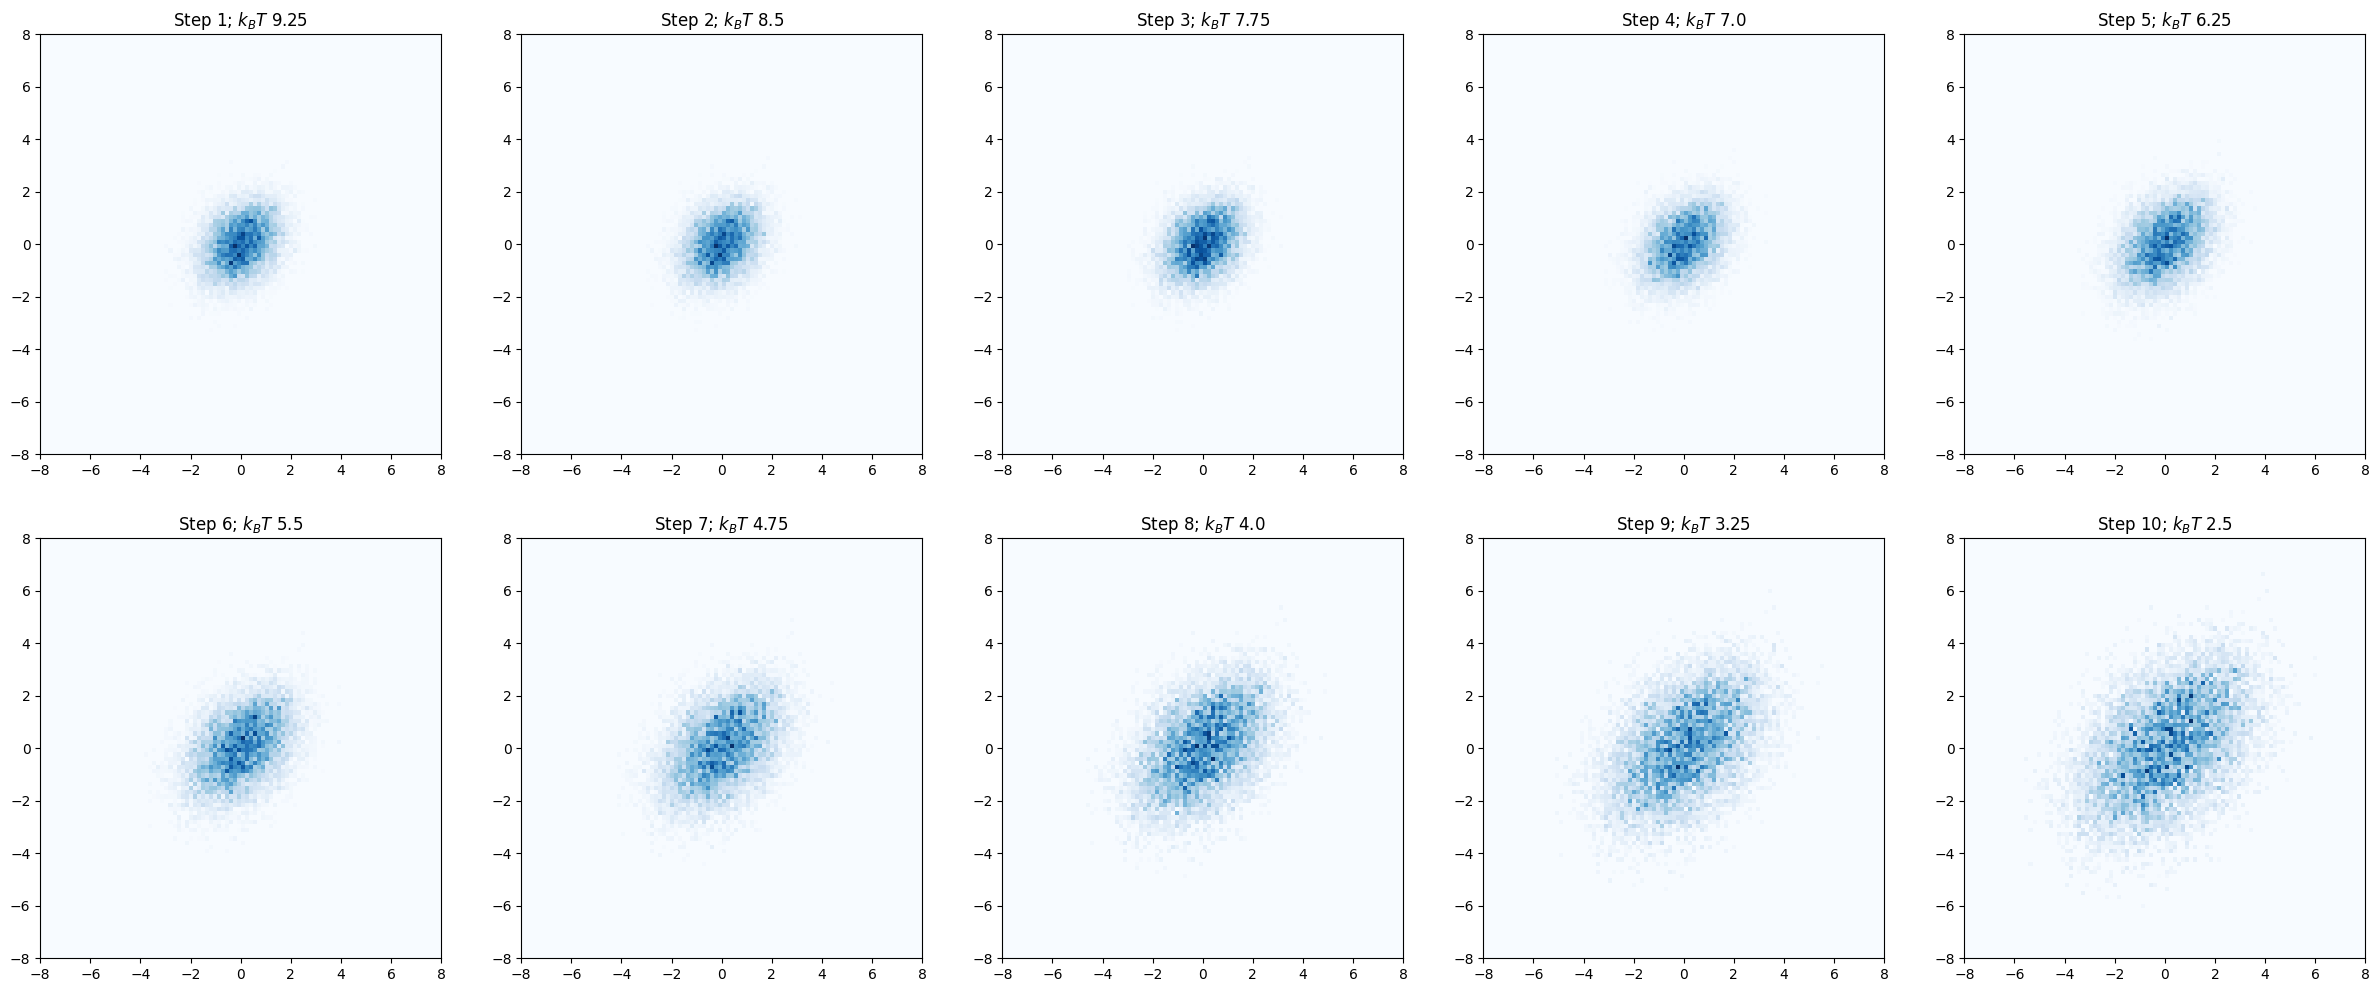

In [23]:
plot_xx_t = plot_ot_flow(model_u_t)

<Figure size 1700x500 with 0 Axes>

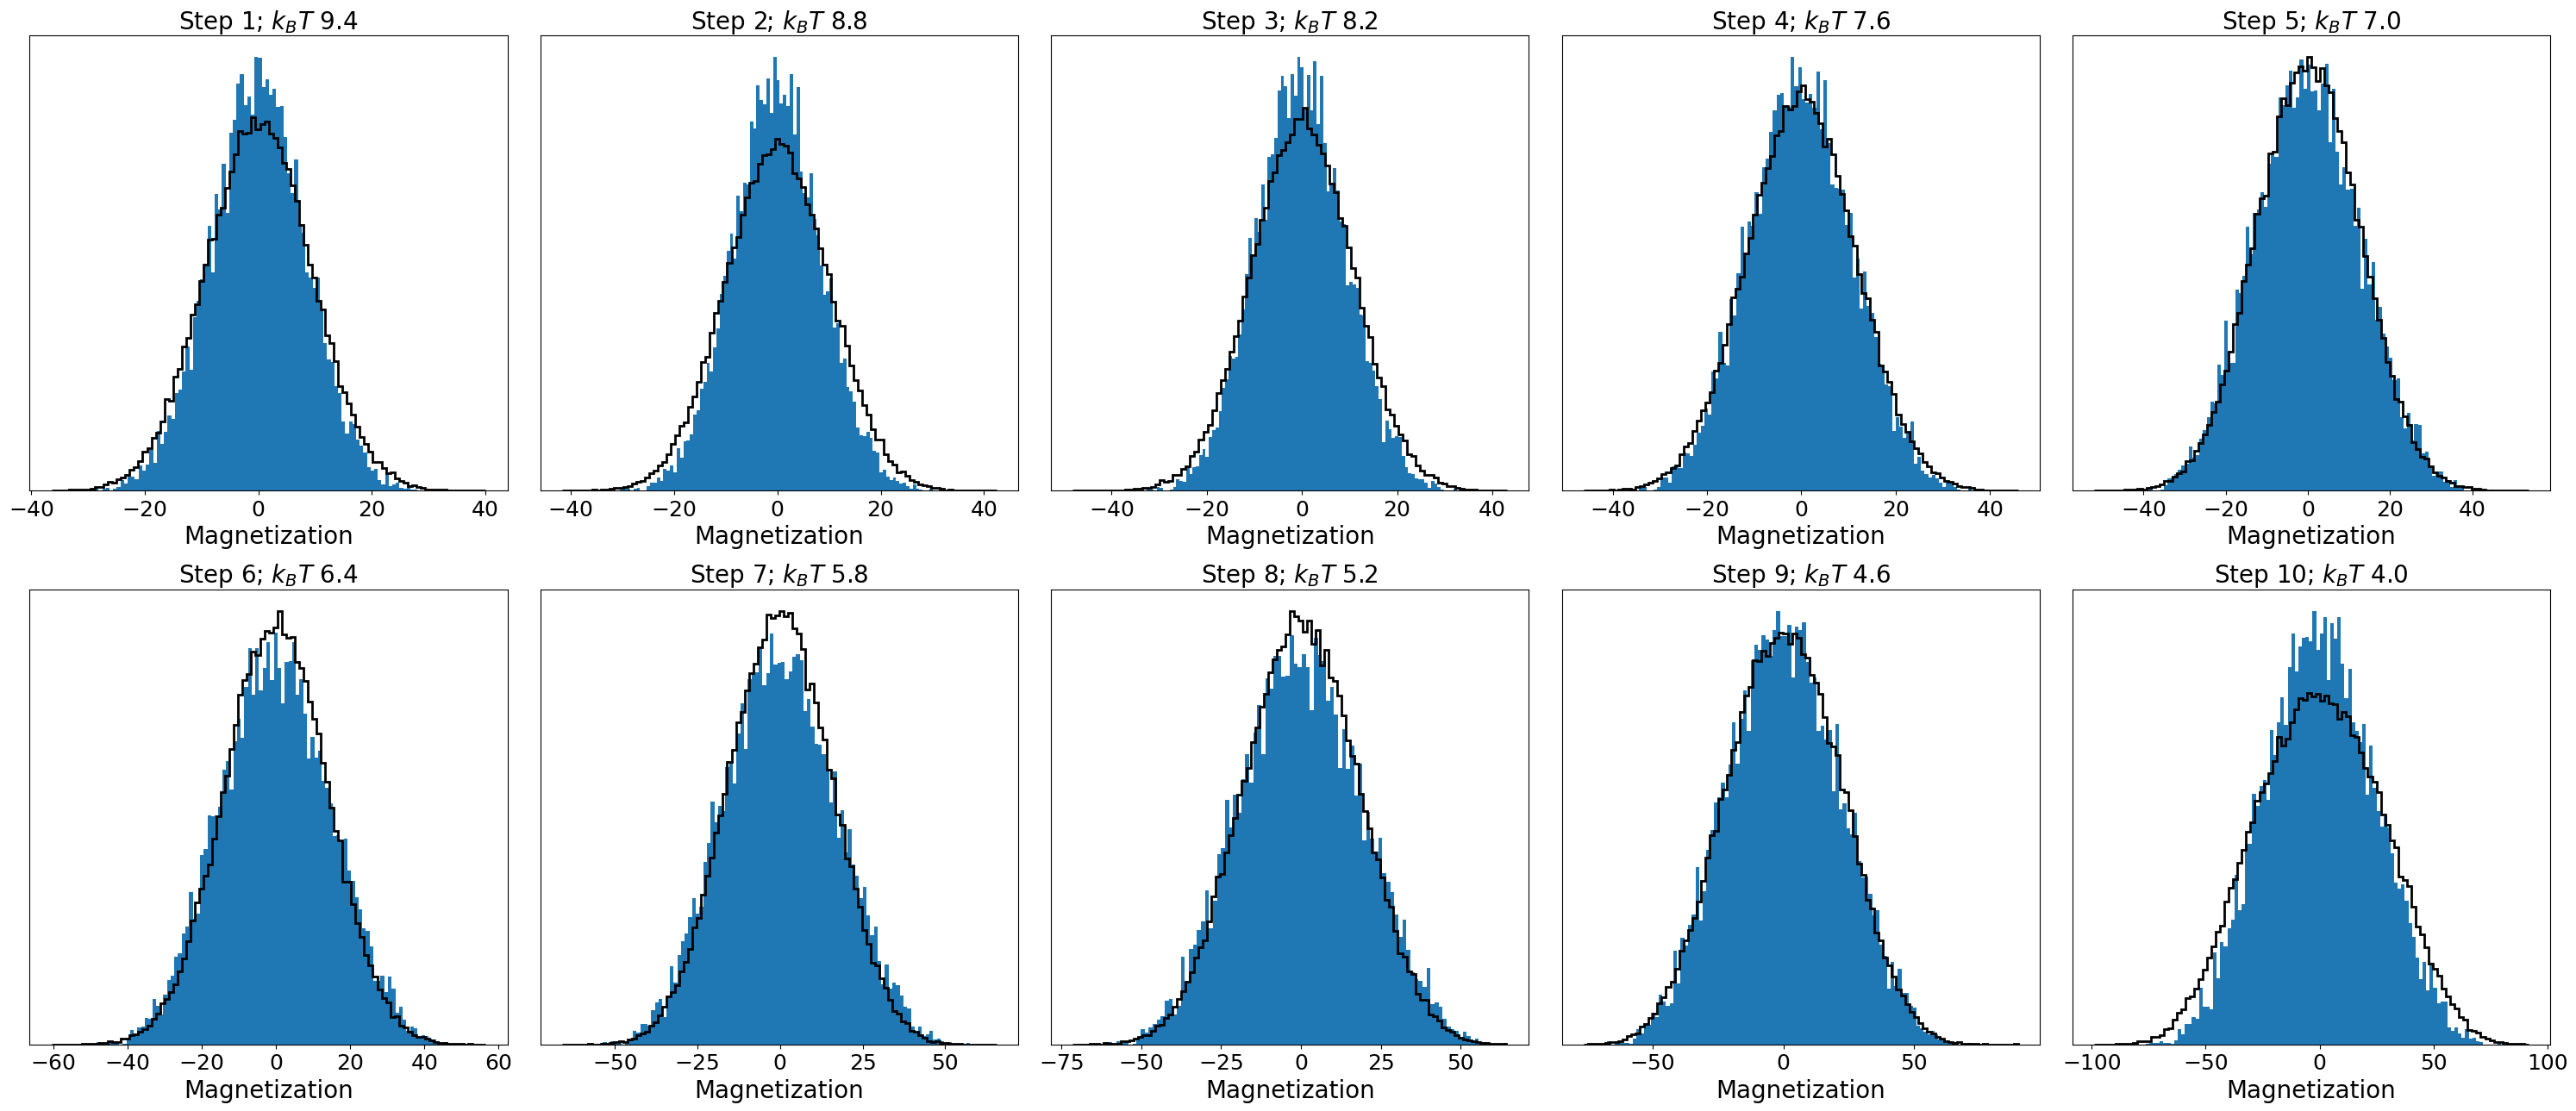

In [31]:
num_steps=10
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 13))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-6.0*ii*(num_steps//10)/num_steps), font={"size":20})
    axes[ii_x,ii_y].hist(plot_xx_t[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    # axes[ii_x,ii_y].legend()
    axes[ii_x,ii_y].set_xlabel("Magnetization",font={"size":20})
    axes[ii_x,ii_y].set_yticks([])
    axes[ii_x,ii_y].tick_params(axis='x', which='major', labelsize=18) 
plt.tight_layout()
plt.show()

## Continuous time stochastic flow

In [91]:
def plot_flow(model_u_t, model_s_t, g=0.1, num_steps=10):
    sample_size = 10**5
    xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx_t = []
    xx_t.append(xx.detach().numpy())

    for ii in range(num_steps):
        tt = ii / num_steps
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model_u_t(samples) + g**2/2*model_s_t(samples)
        xx = xx + u_t * 1./num_steps
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)
    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii*(num_steps//10))+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
        axes[ii_x,ii_y].hist2d(xx_t[ii*(num_steps//10),:,0], xx_t[ii*(num_steps//10),:,1],bins=100, cmap='Blues',range=np.array([(-8, 8), (-8, 8)]))
        axes[ii_x,ii_y].set_xlim([-8,8])
        axes[ii_x,ii_y].set_ylim([-8,8])
    
    plt.show()
    return xx_t


### g=0.1

<Figure size 1700x500 with 0 Axes>

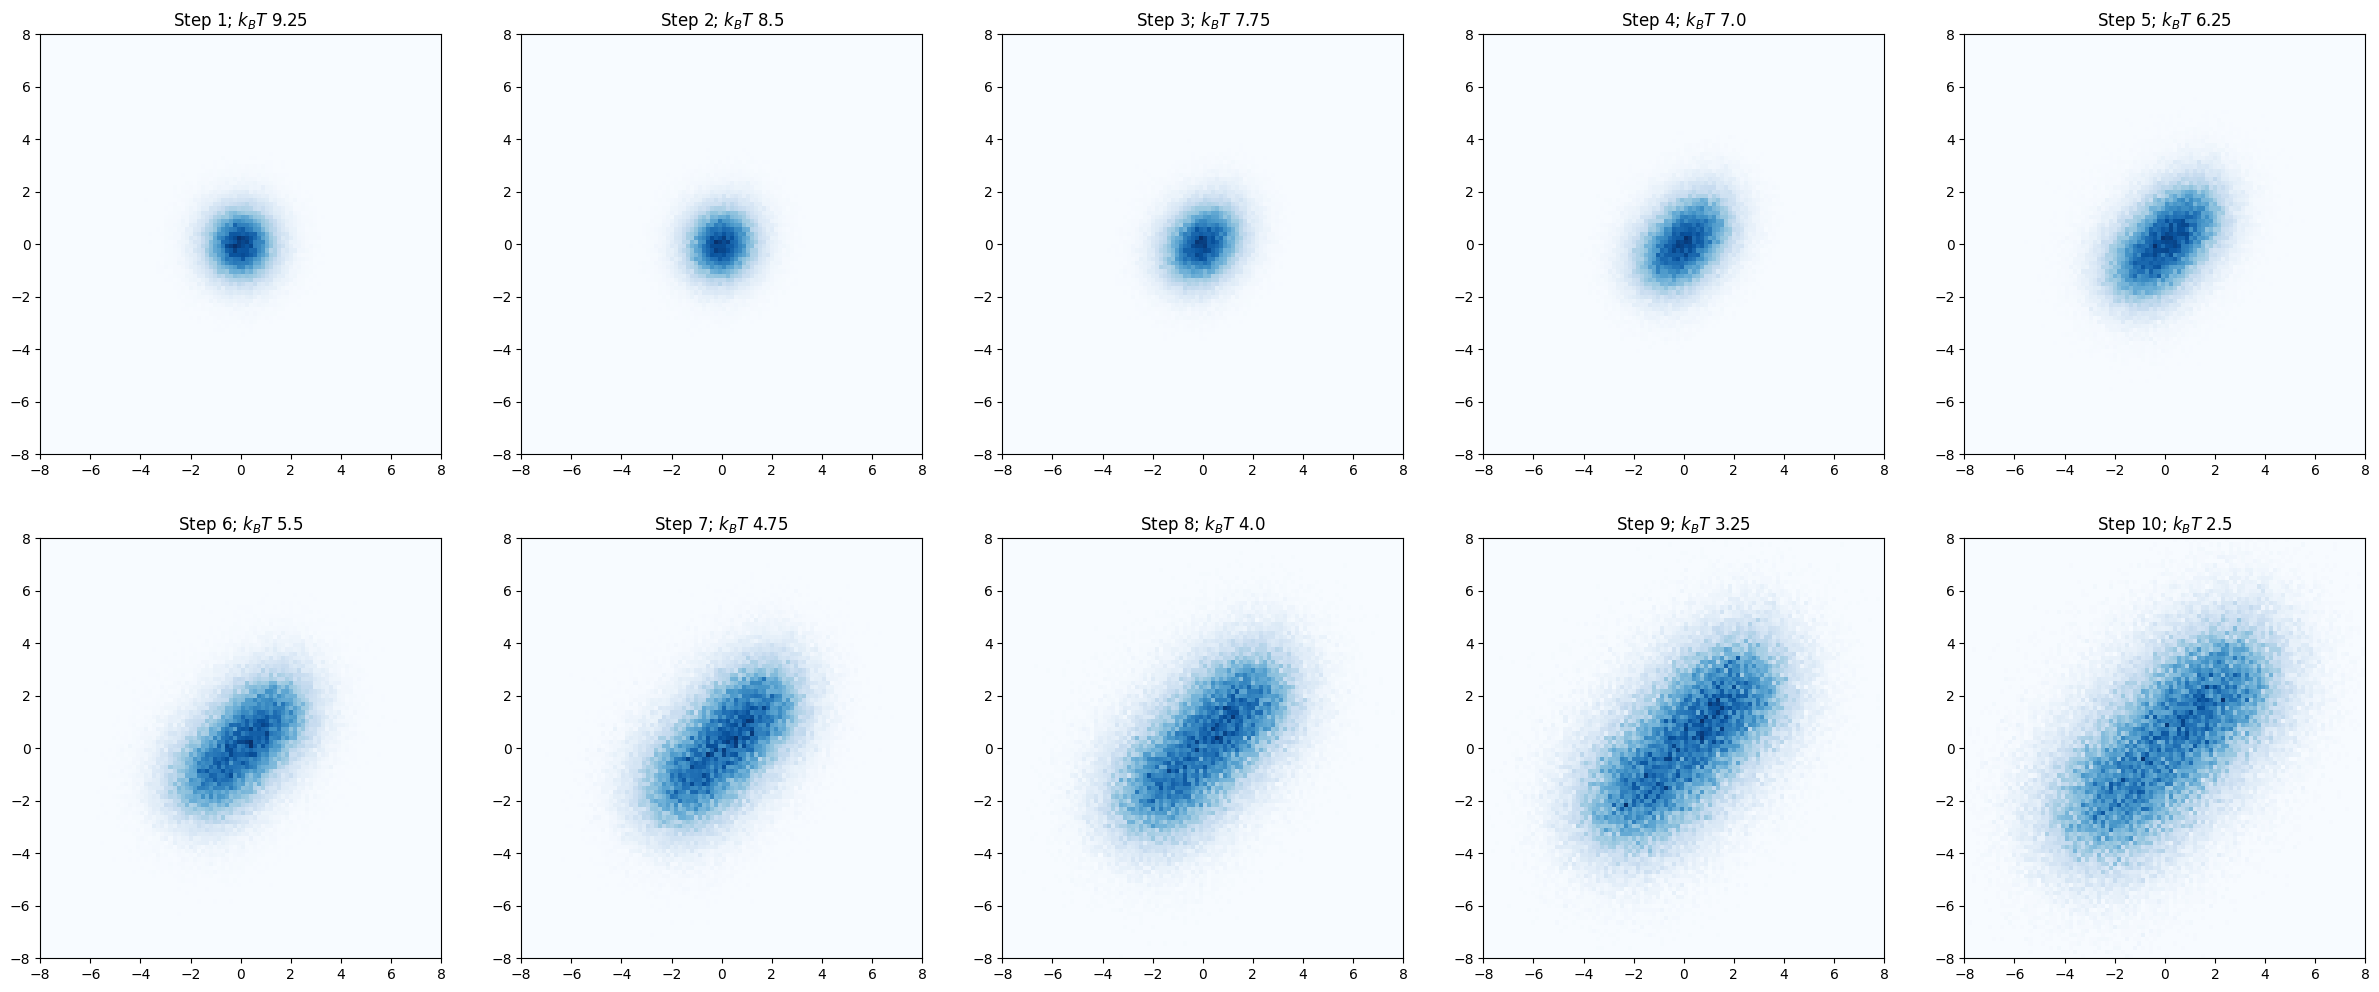

In [92]:
xx_t_g0 = plot_flow(model_u_t, model_s_t)

<Figure size 1700x500 with 0 Axes>

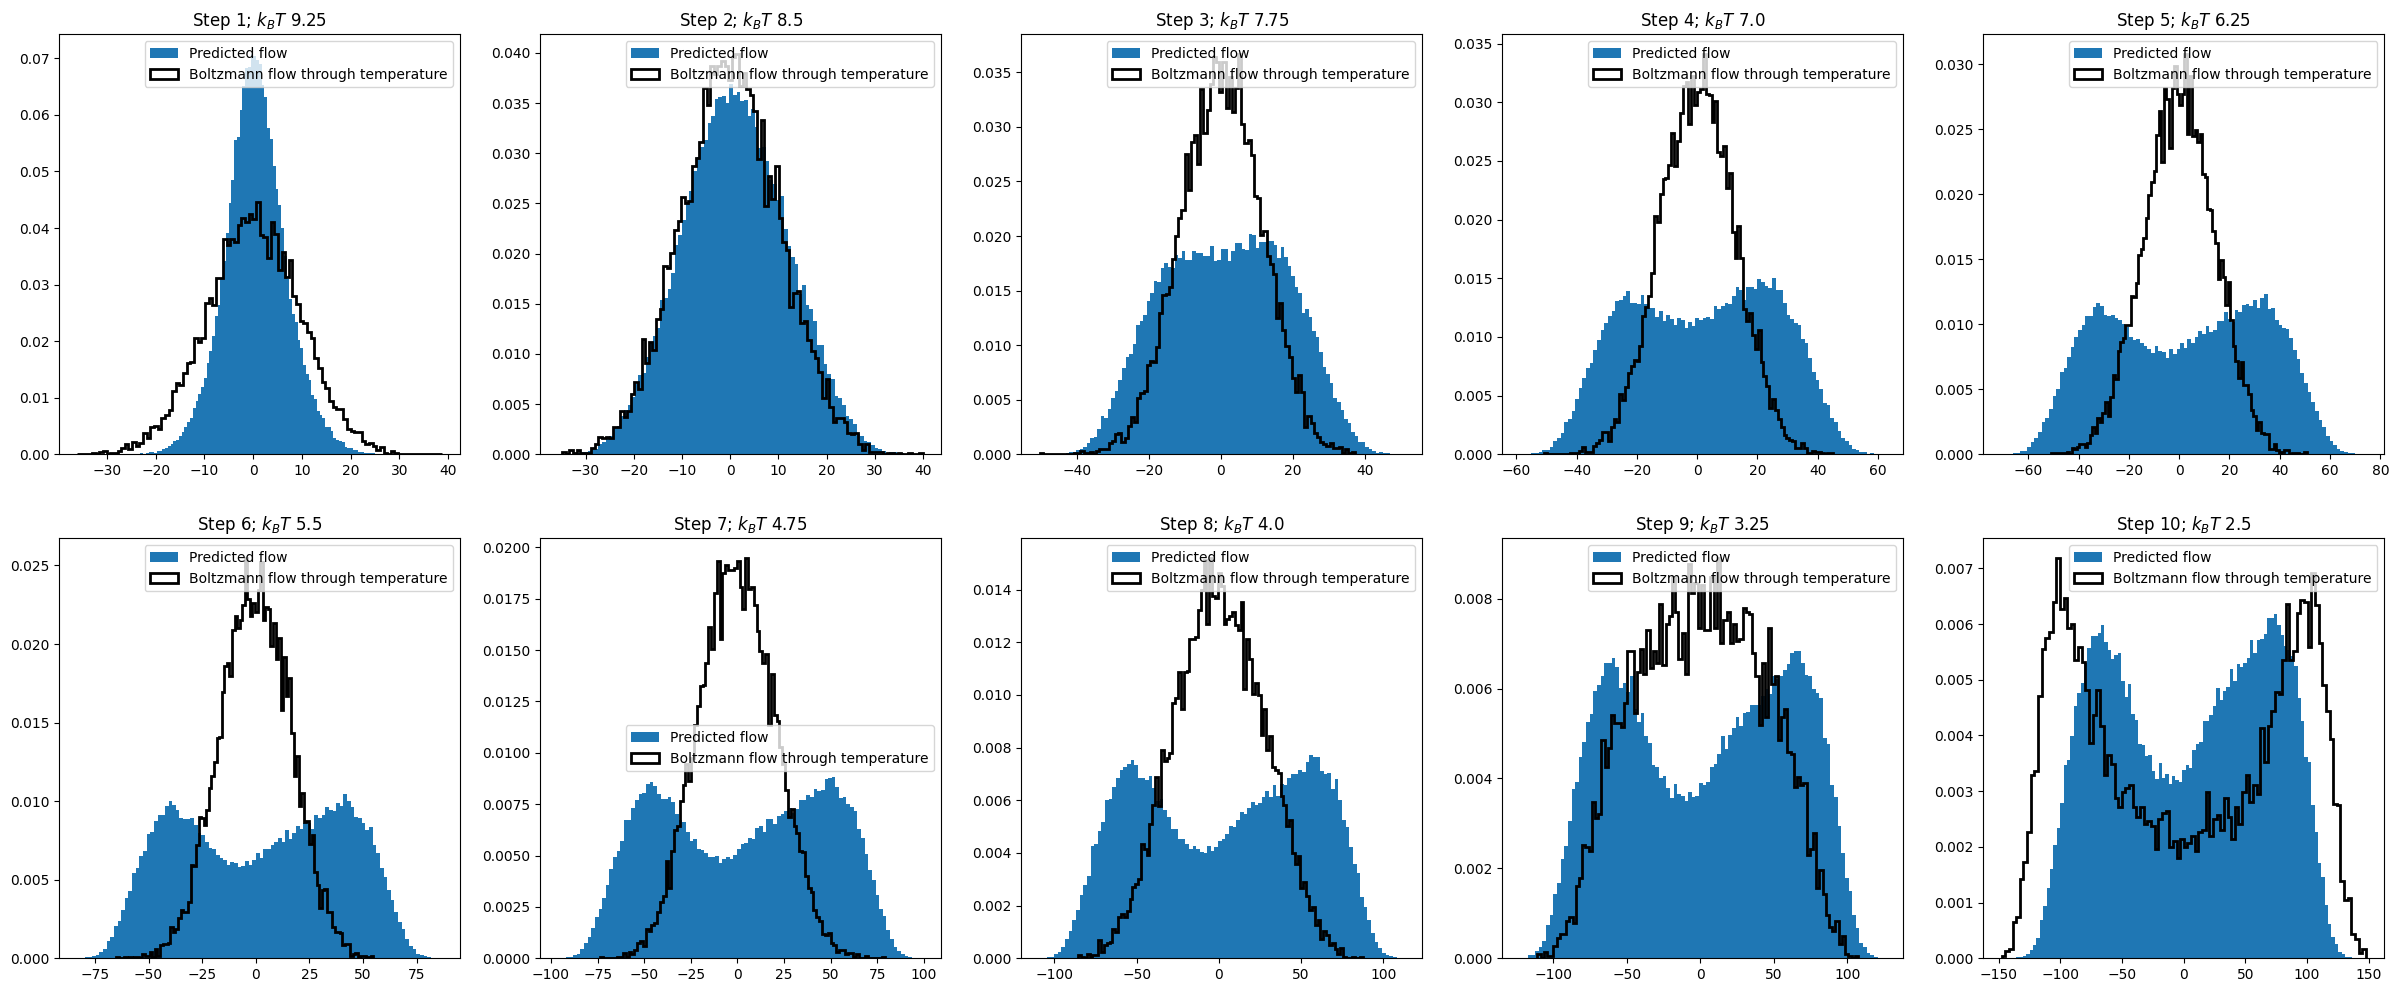

In [96]:
num_steps=10
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g0[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

### g=1

<Figure size 1700x500 with 0 Axes>

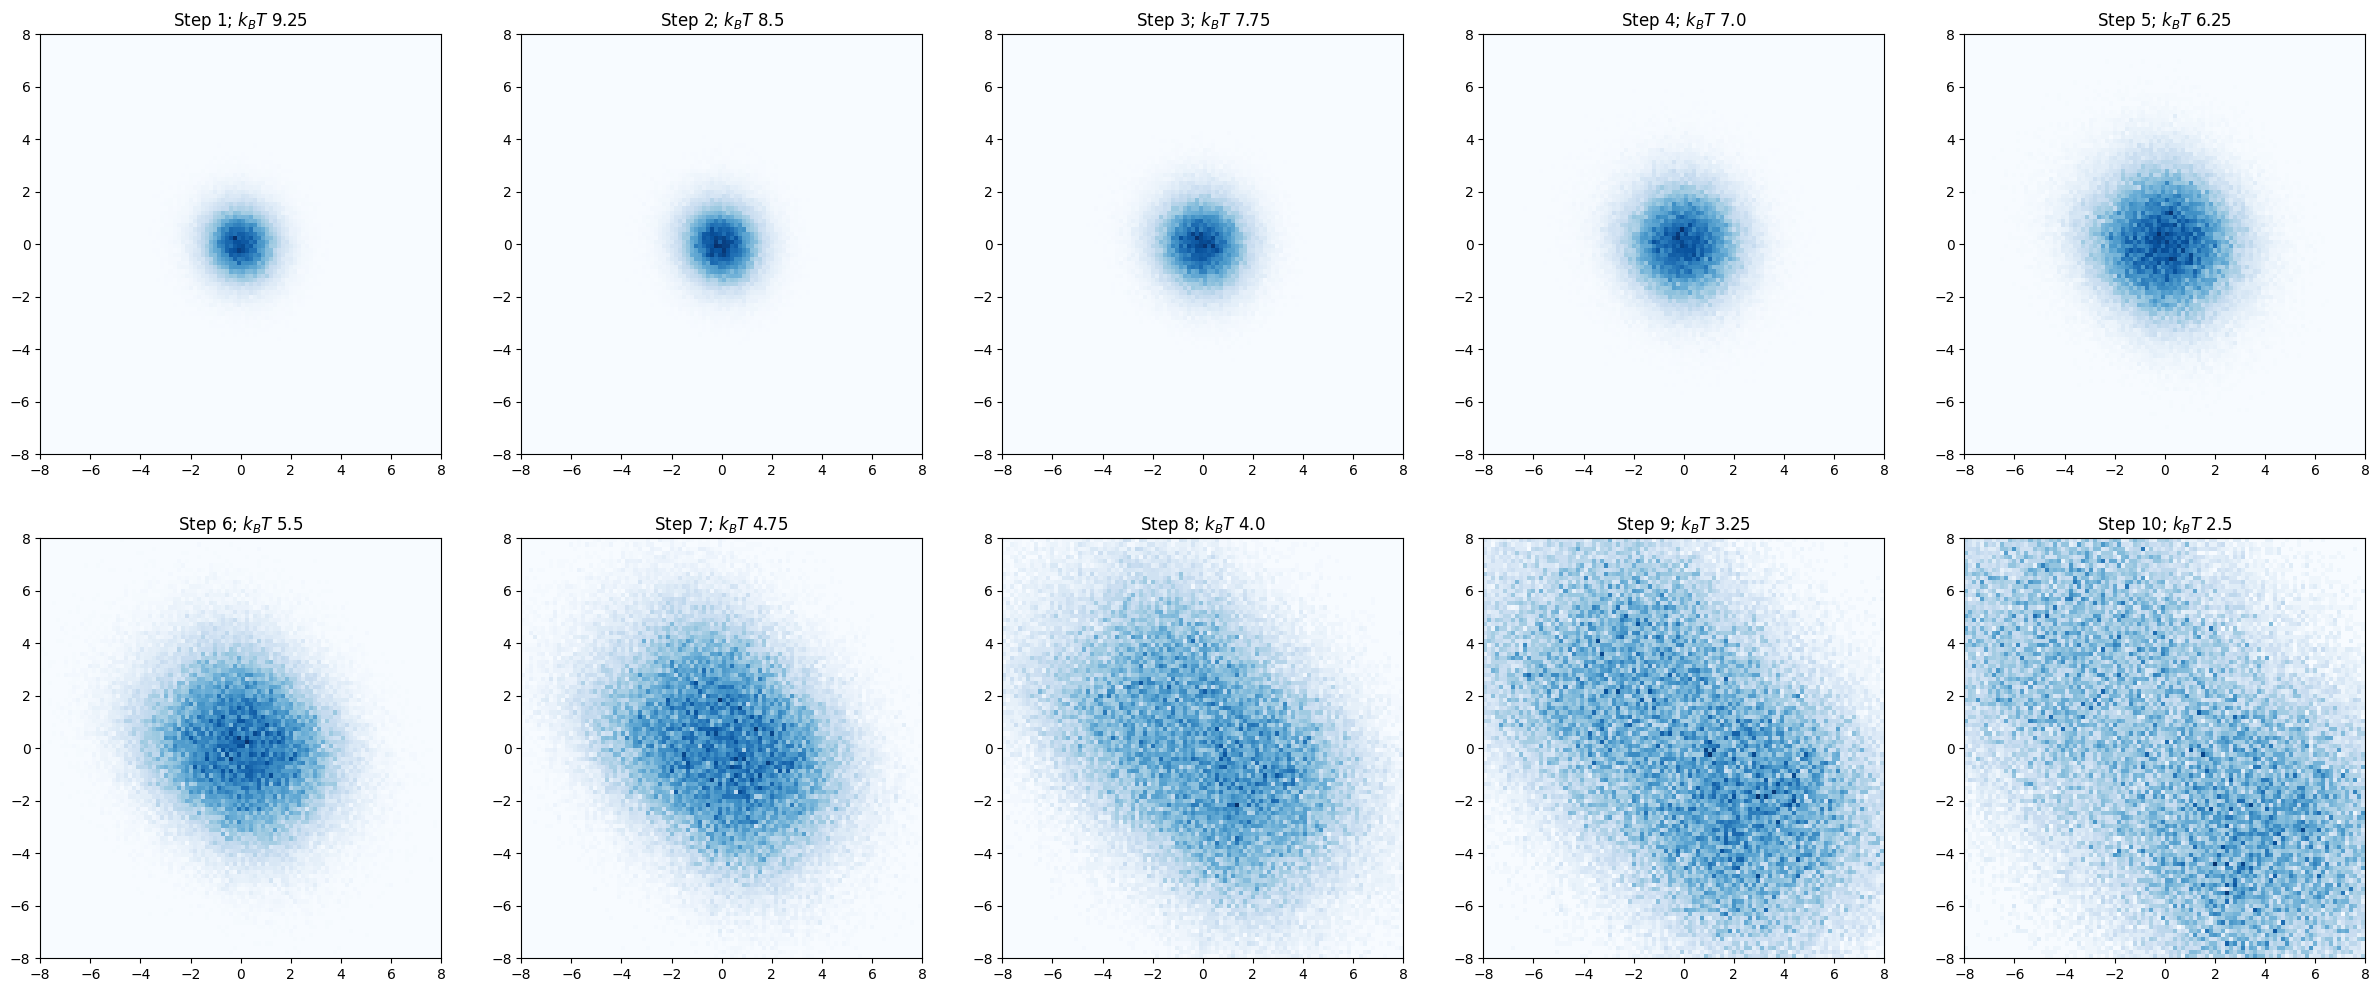

<Figure size 1700x500 with 0 Axes>

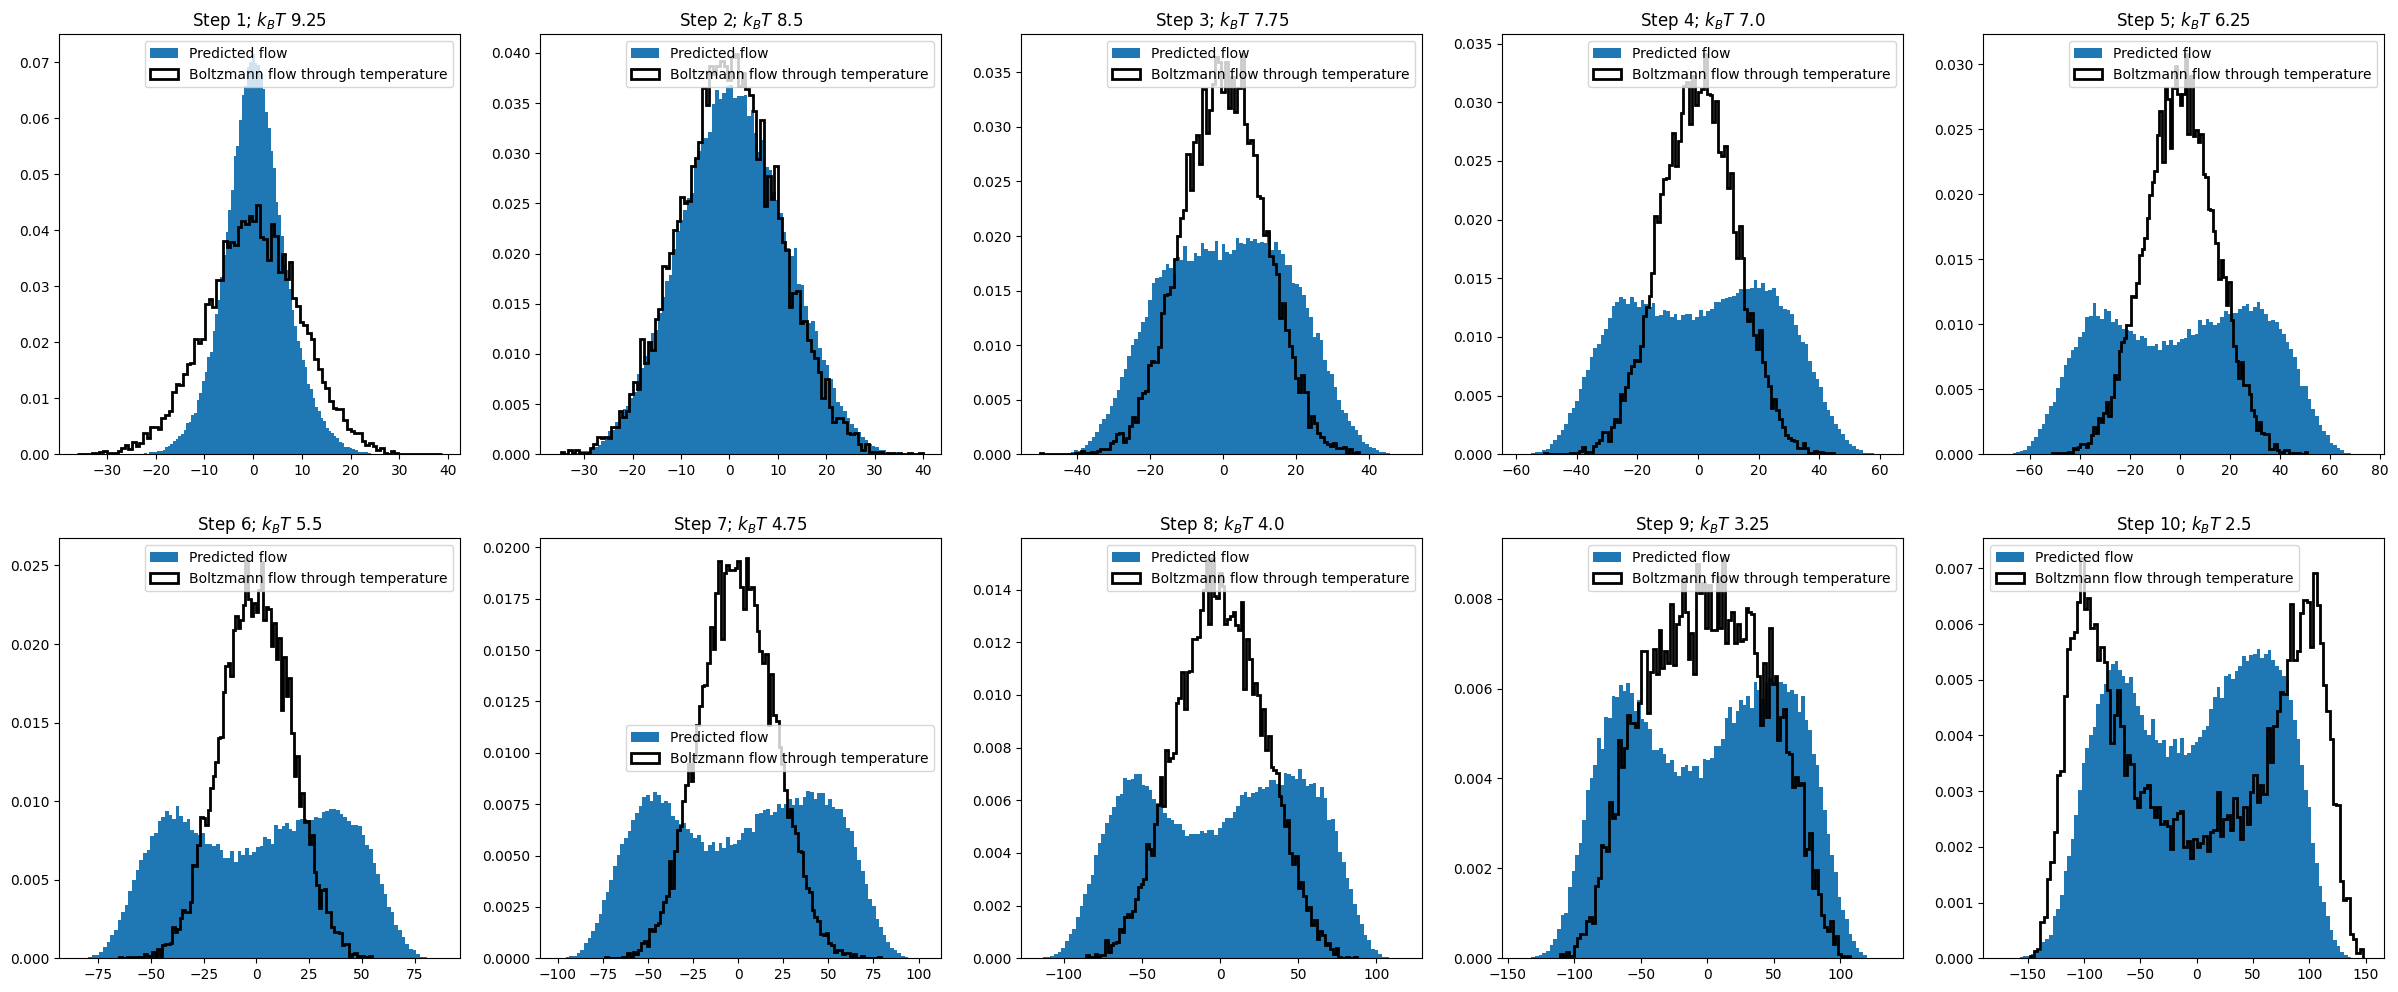

In [97]:
num_steps=10
xx_t_g1 = plot_flow(model_u_t, model_s_t, g=1.)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

### g=1.5

<Figure size 1700x500 with 0 Axes>

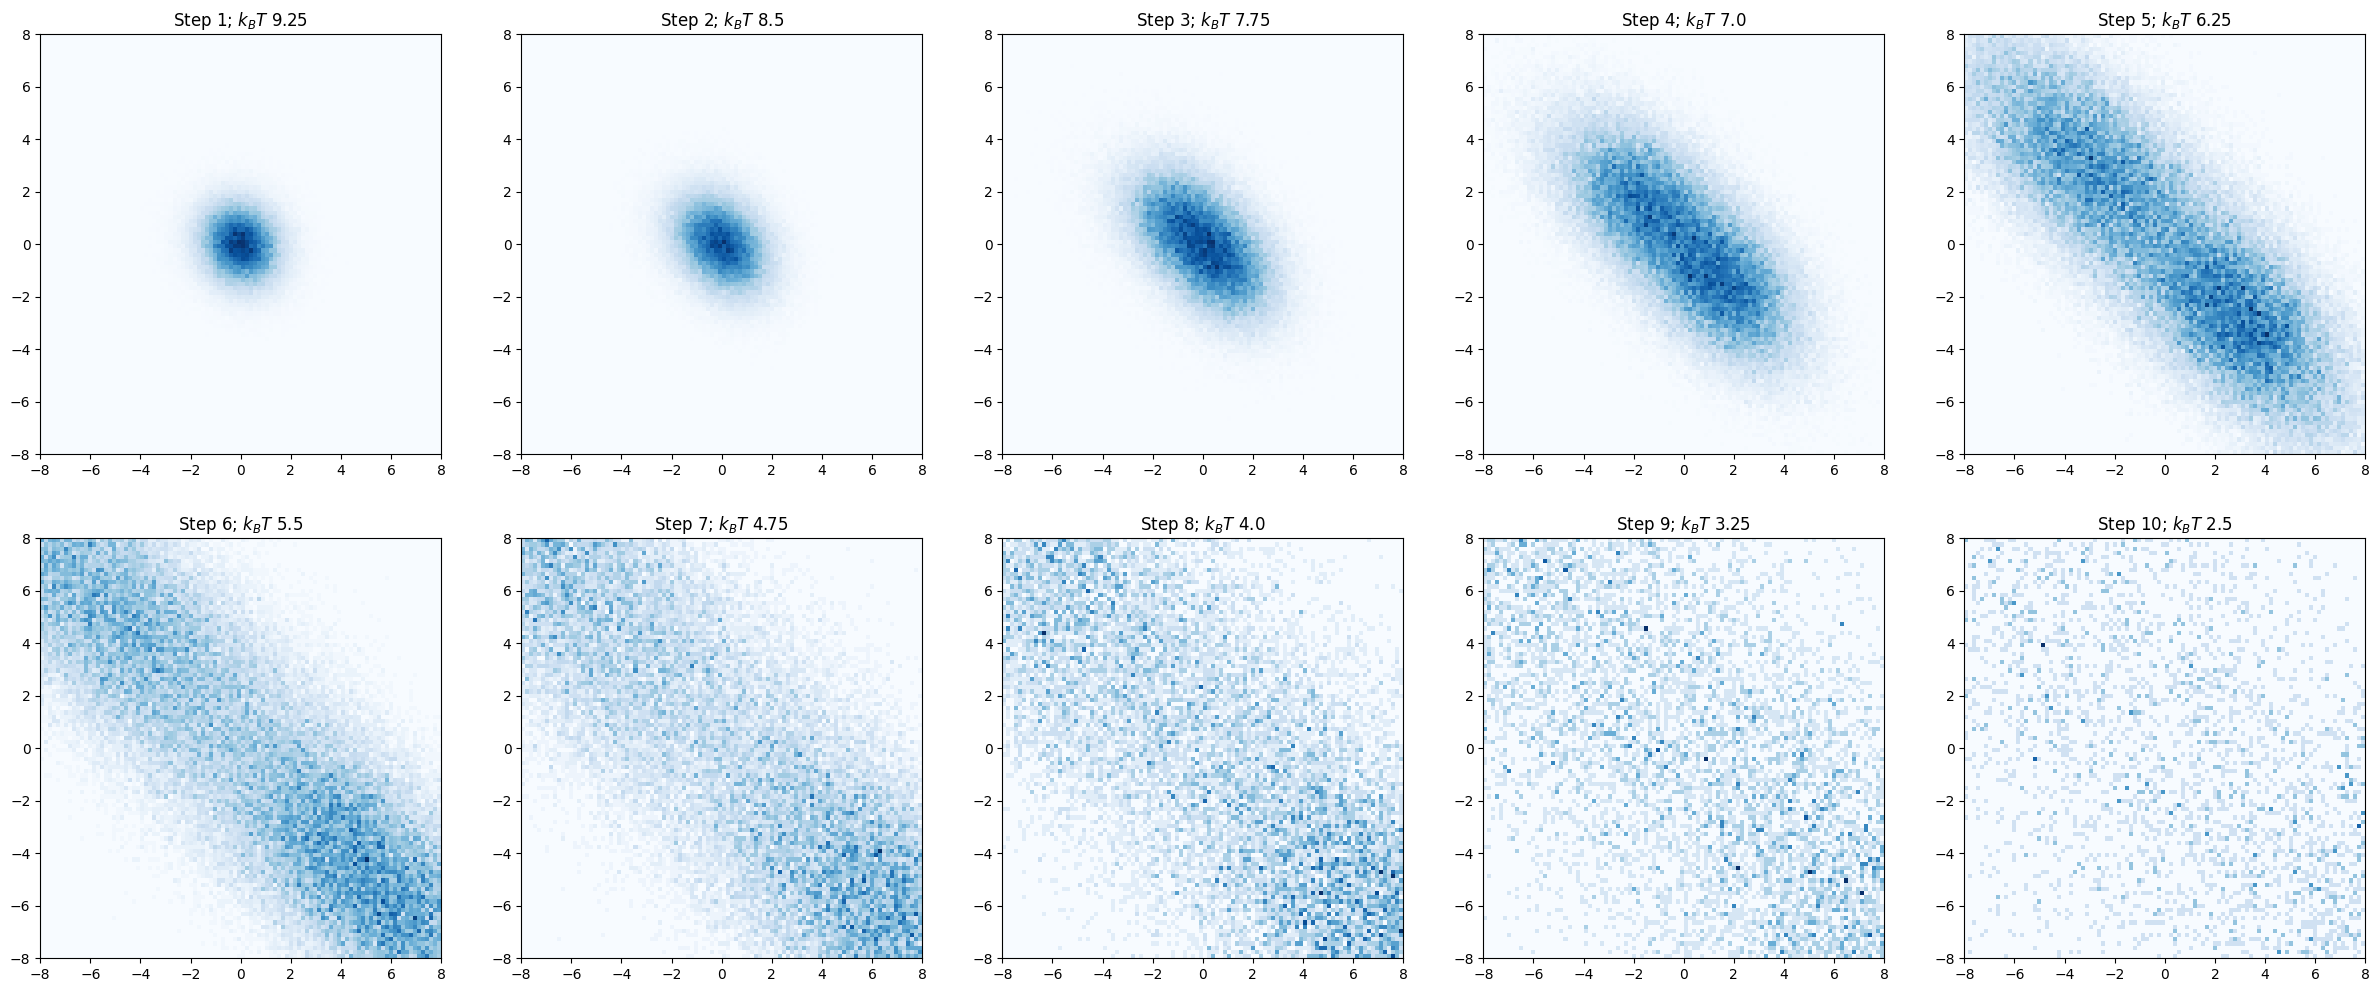

<Figure size 1700x500 with 0 Axes>

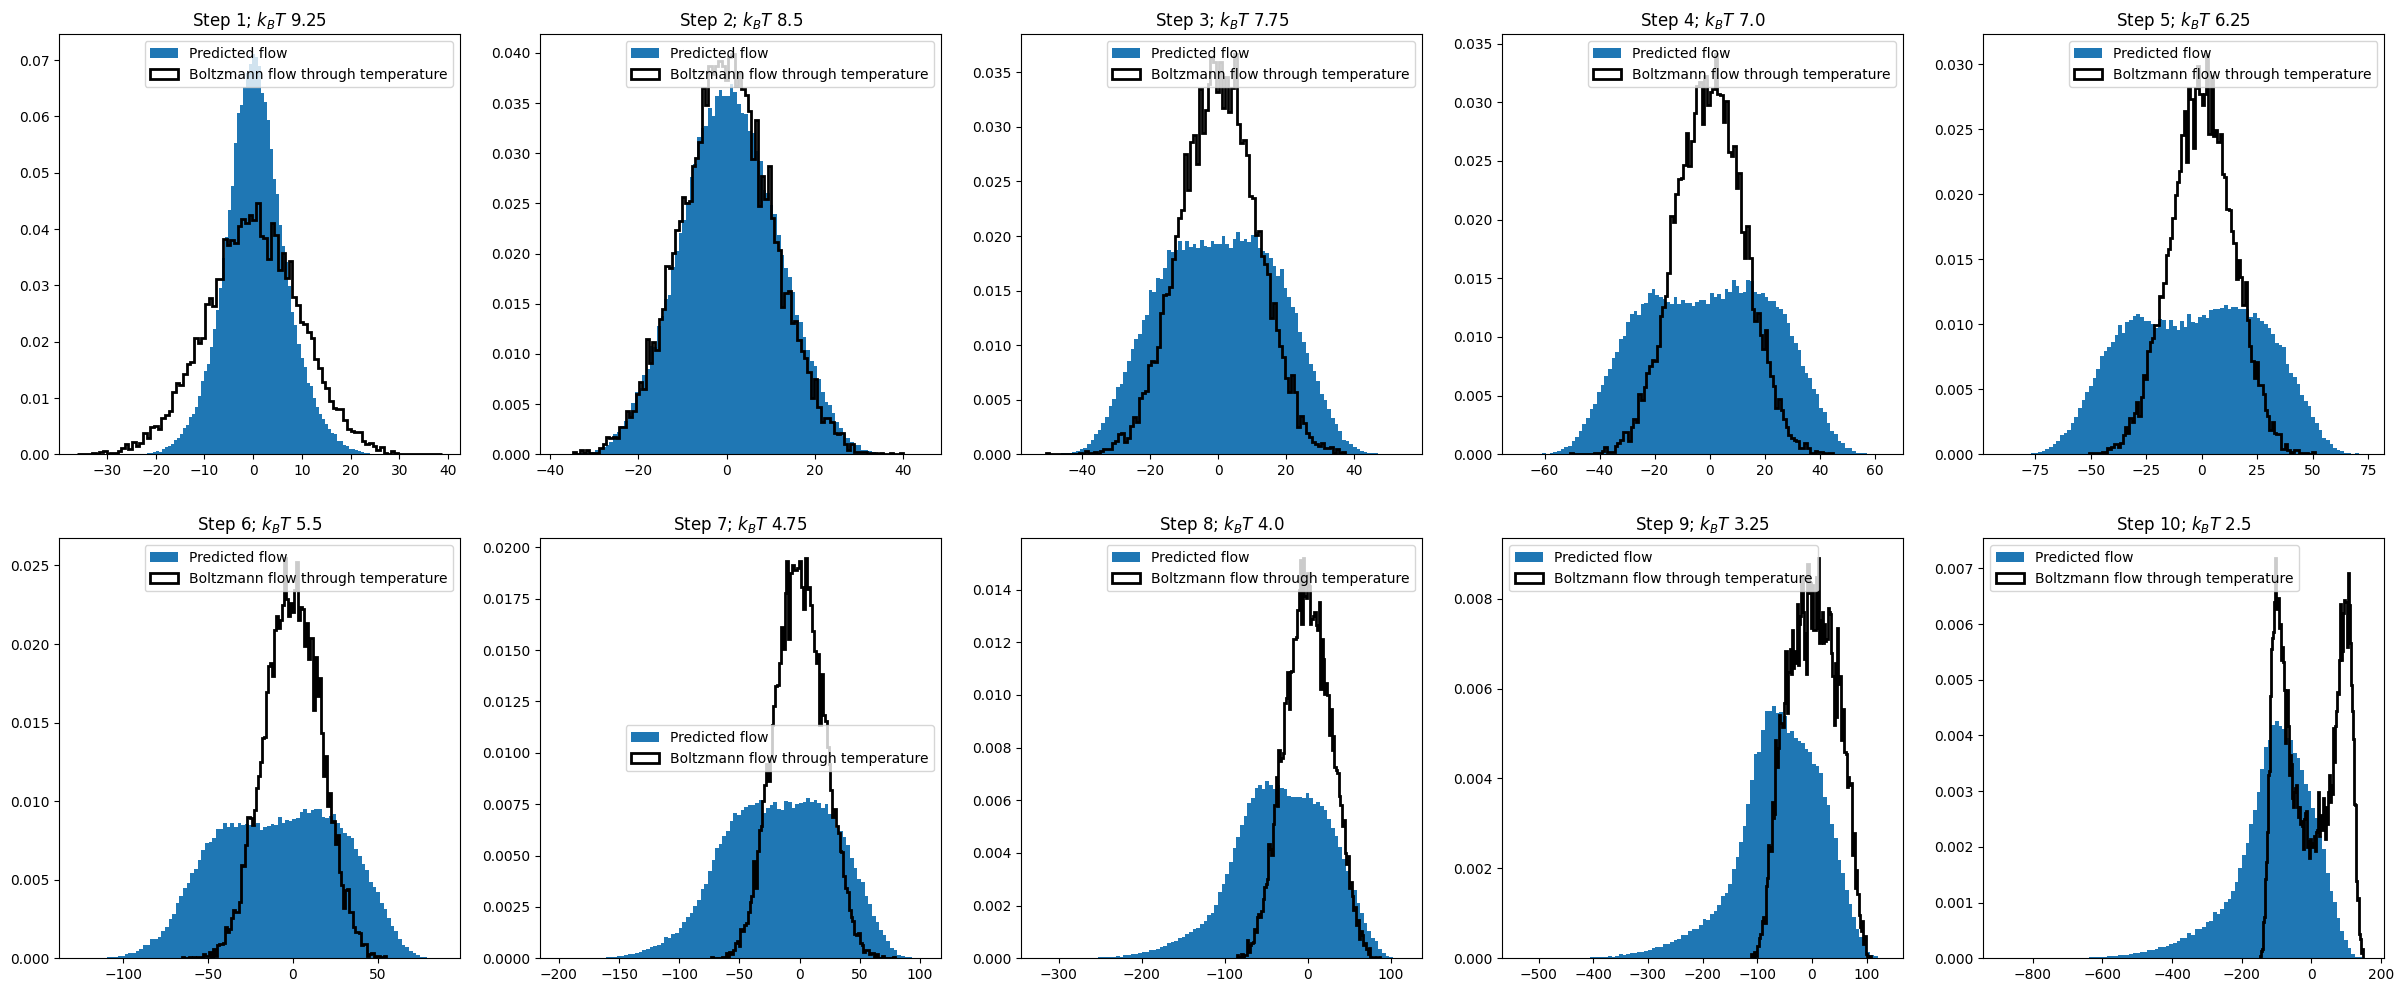

In [98]:
num_steps=10
xx_t_g2 = plot_flow(model_u_t, model_s_t, g=1.5)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2[ii,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

## Continuous time stochastic flow with score model trained by Ising data

### g=0.1

In [ ]:
num_steps=20
xx_t_g0_t1 = plot_flow(model_u_t, model_s_t, g=0.1, num_steps=20)
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g0_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=20
xx_t_g1_t1 = plot_flow(model_u_t, model_s_t, g=1., num_steps=20)


<Figure size 1700x500 with 0 Axes>

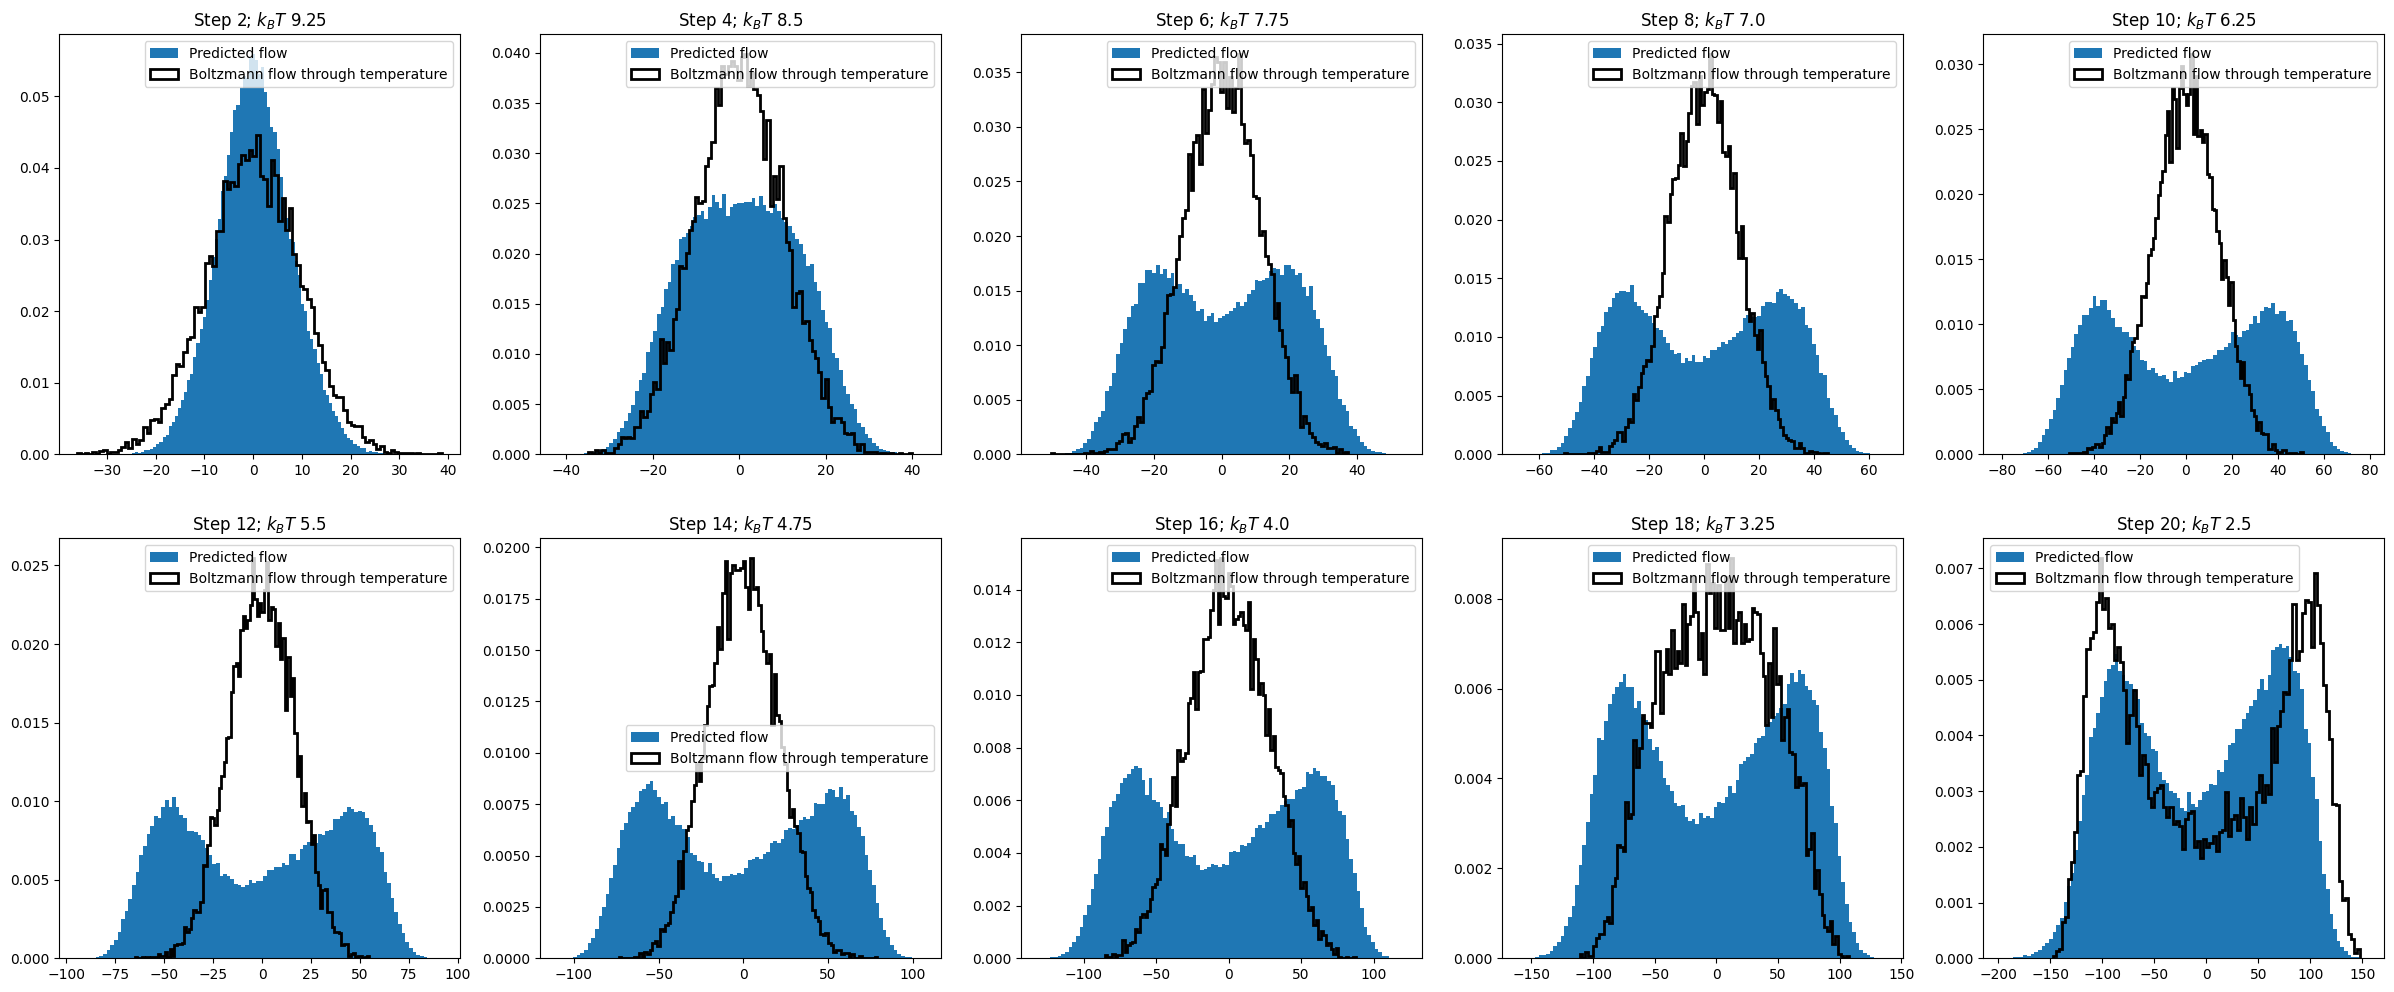

In [104]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

<Figure size 1700x500 with 0 Axes>

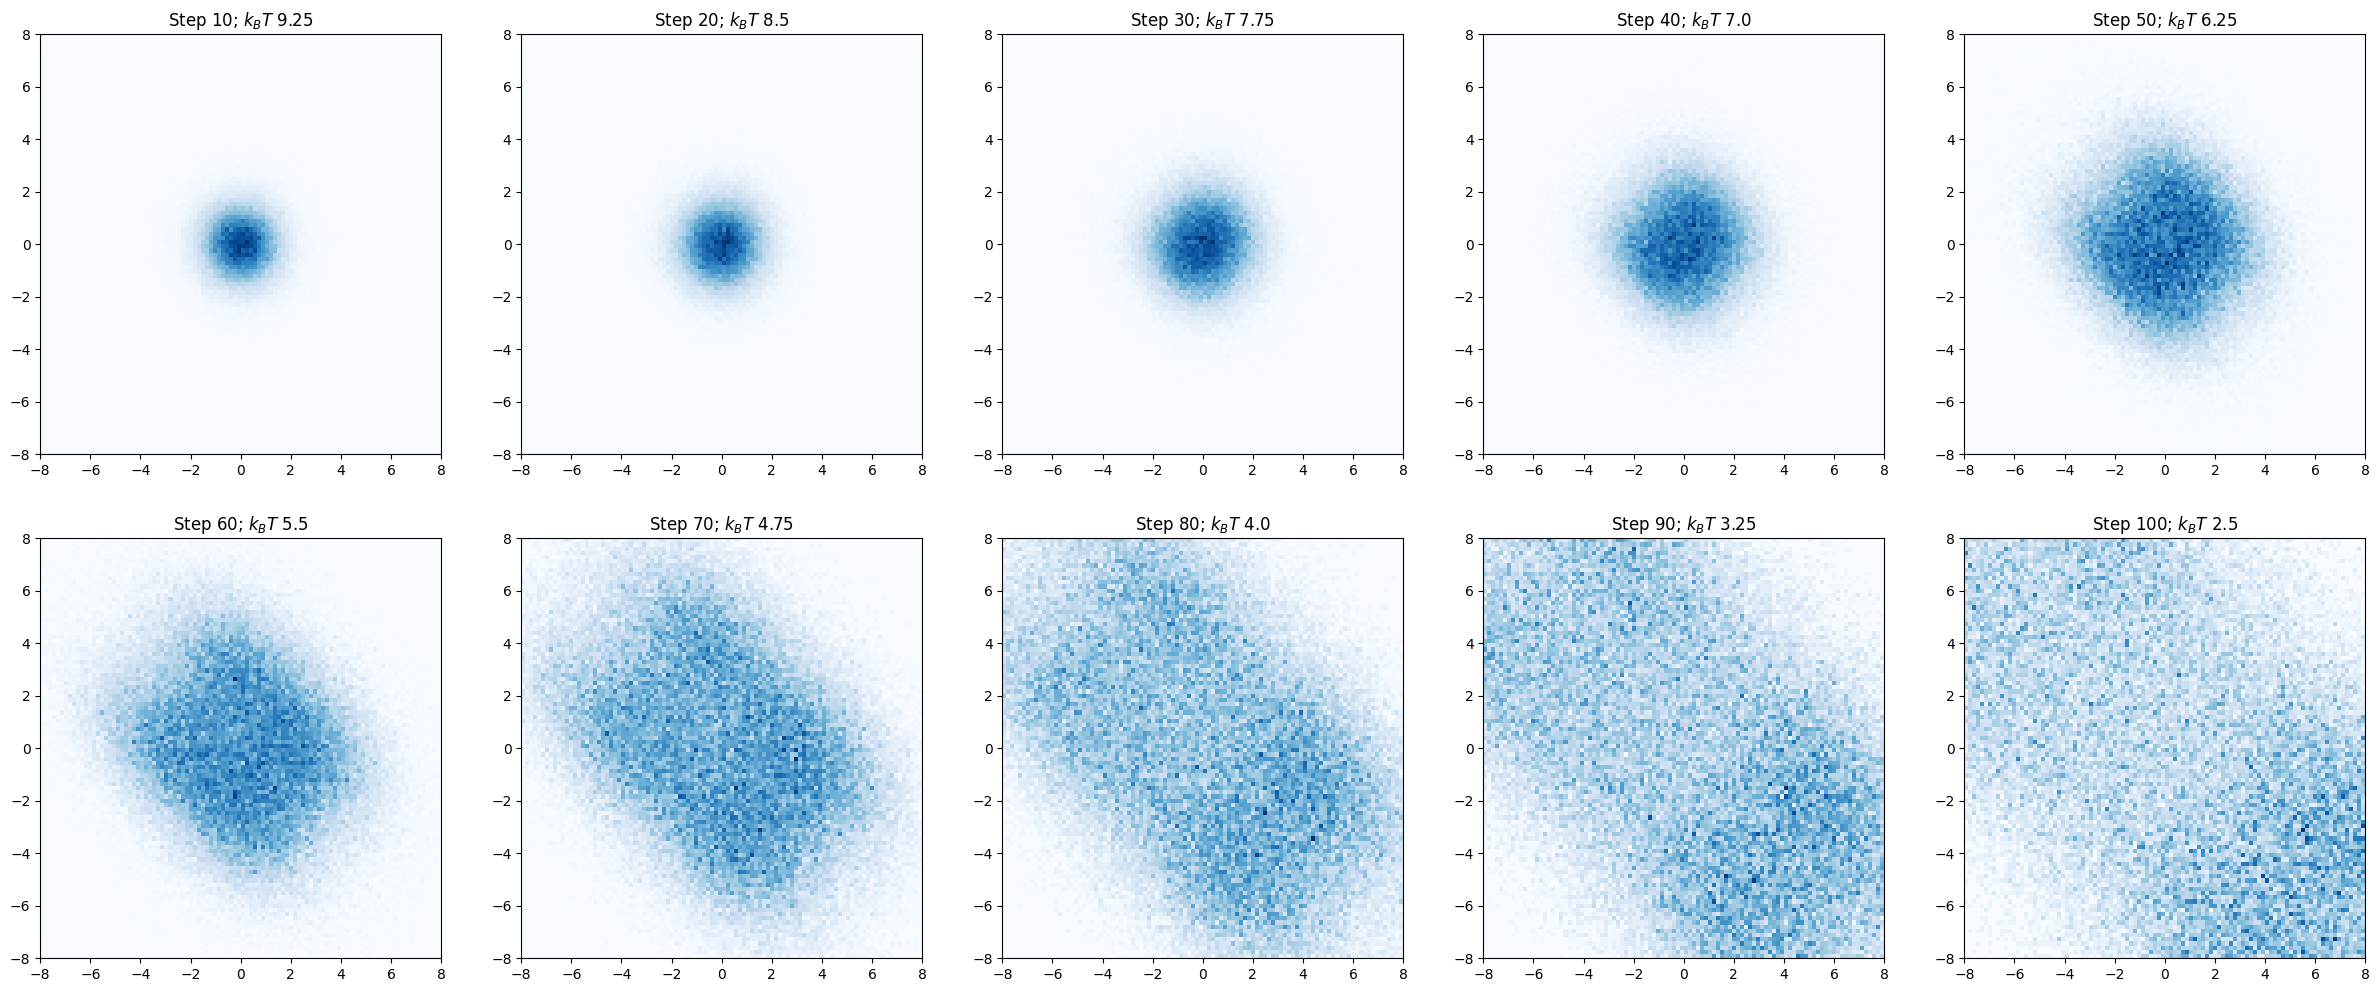

In [107]:
num_steps=100
xx_t_g1_t3 = plot_flow(model_u_t, model_s_t, g=1., num_steps=100)

<Figure size 1700x500 with 0 Axes>

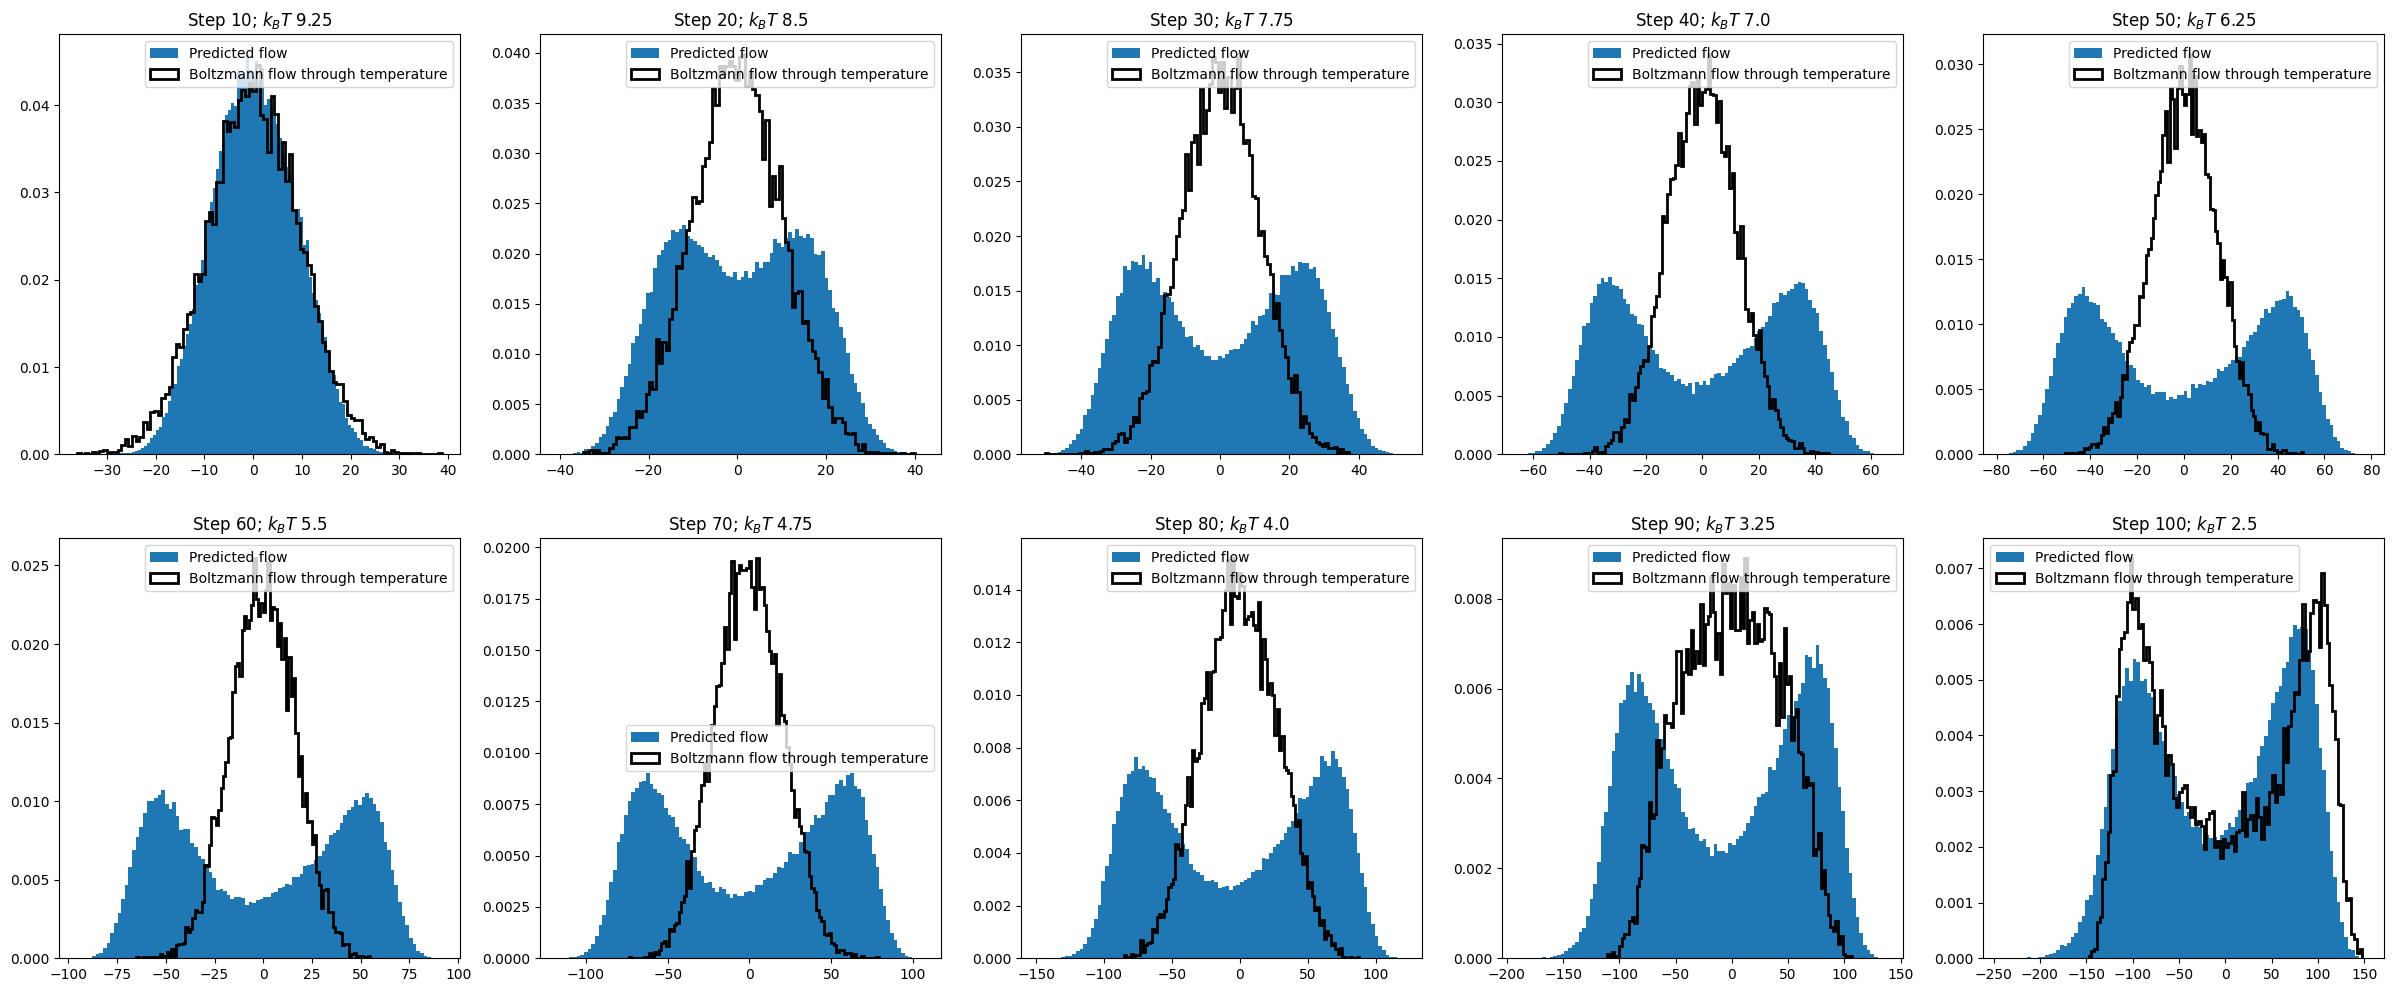

In [109]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*10)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g1_t3[ii*10,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

In [ ]:
num_steps=20
xx_t_g2_t1 = plot_flow(model_u_t, model_s_t, g=1.5, num_steps=20)


<Figure size 1700x500 with 0 Axes>

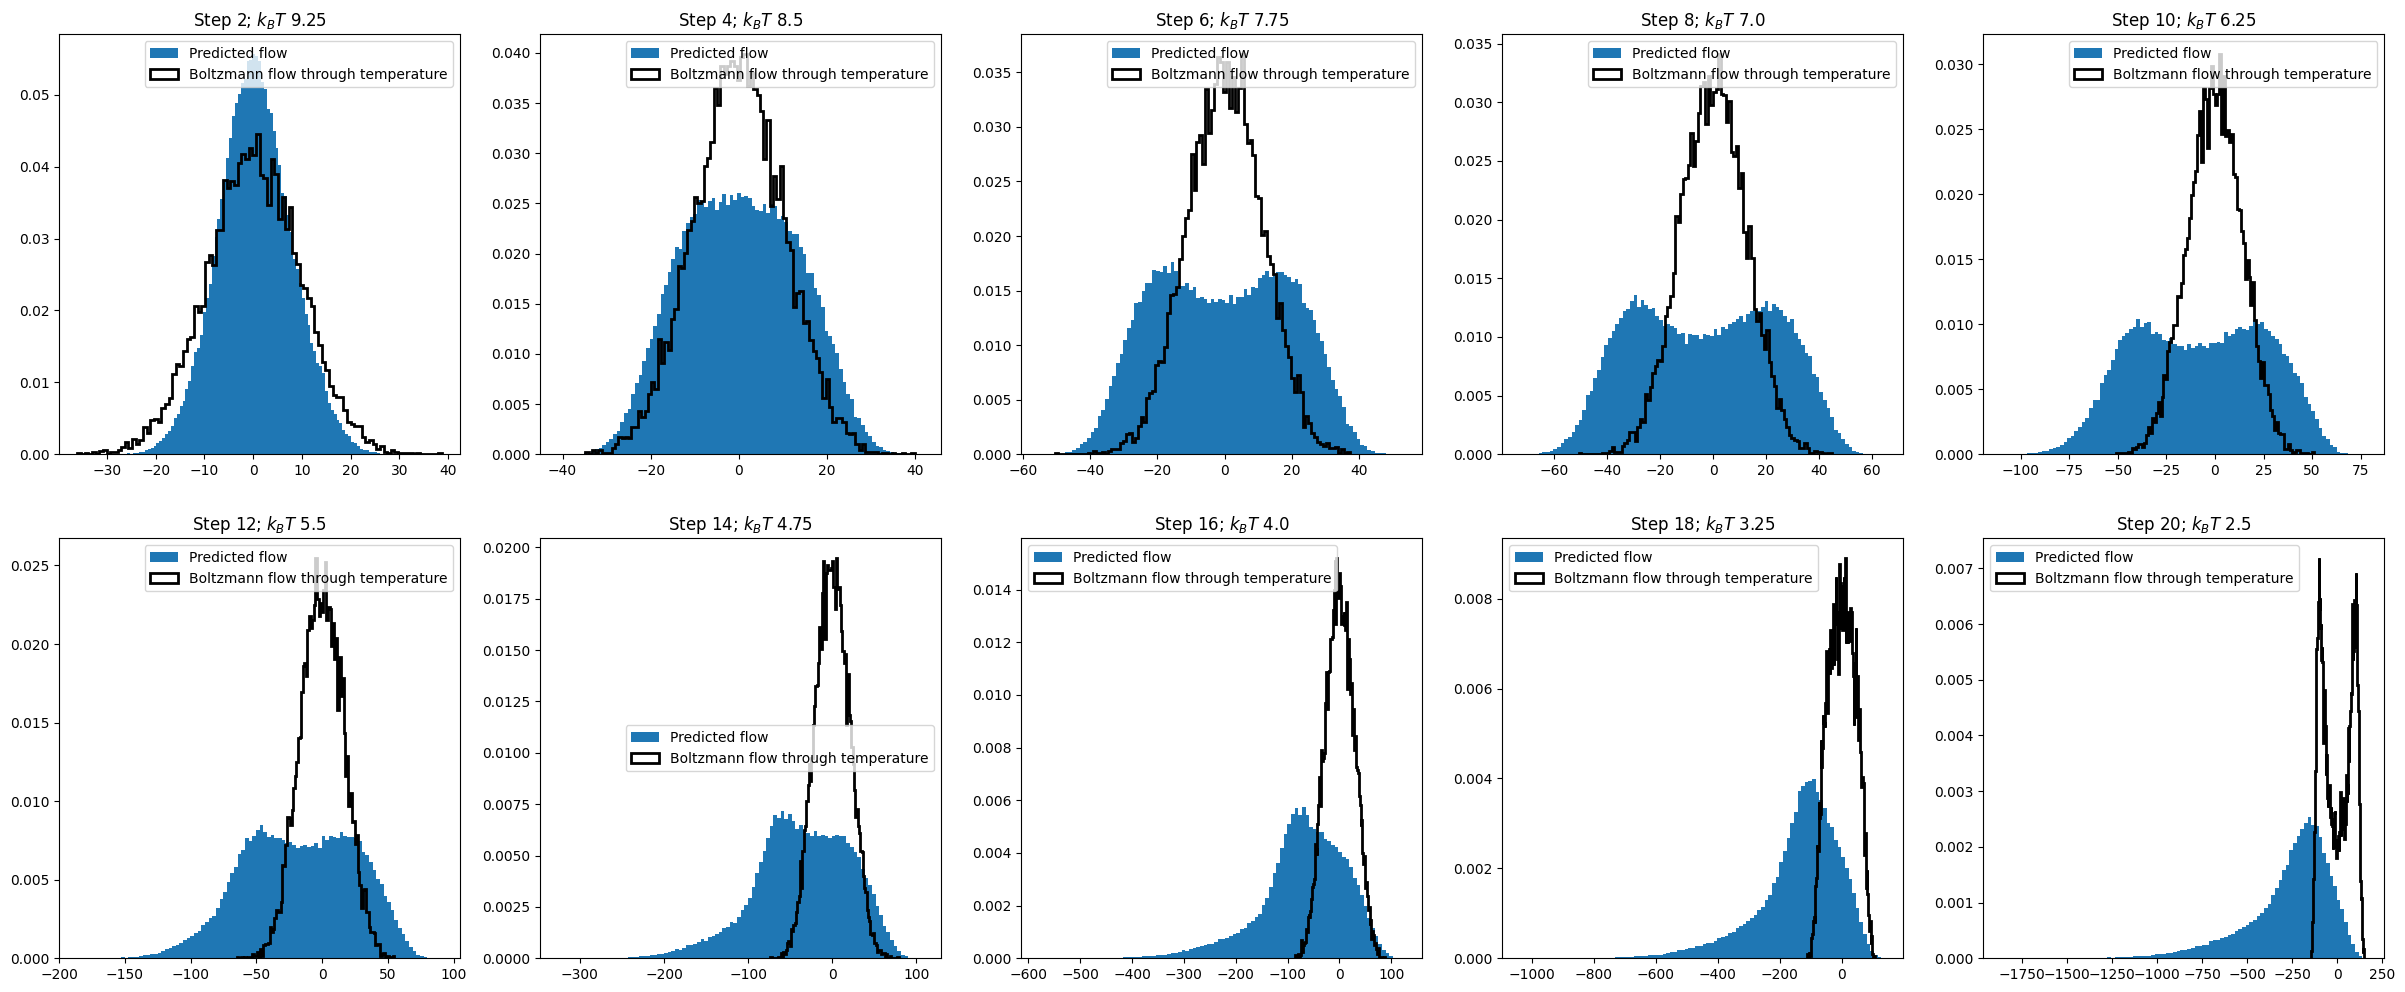

In [106]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*2)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2_t1[ii*2,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

<Figure size 1700x500 with 0 Axes>

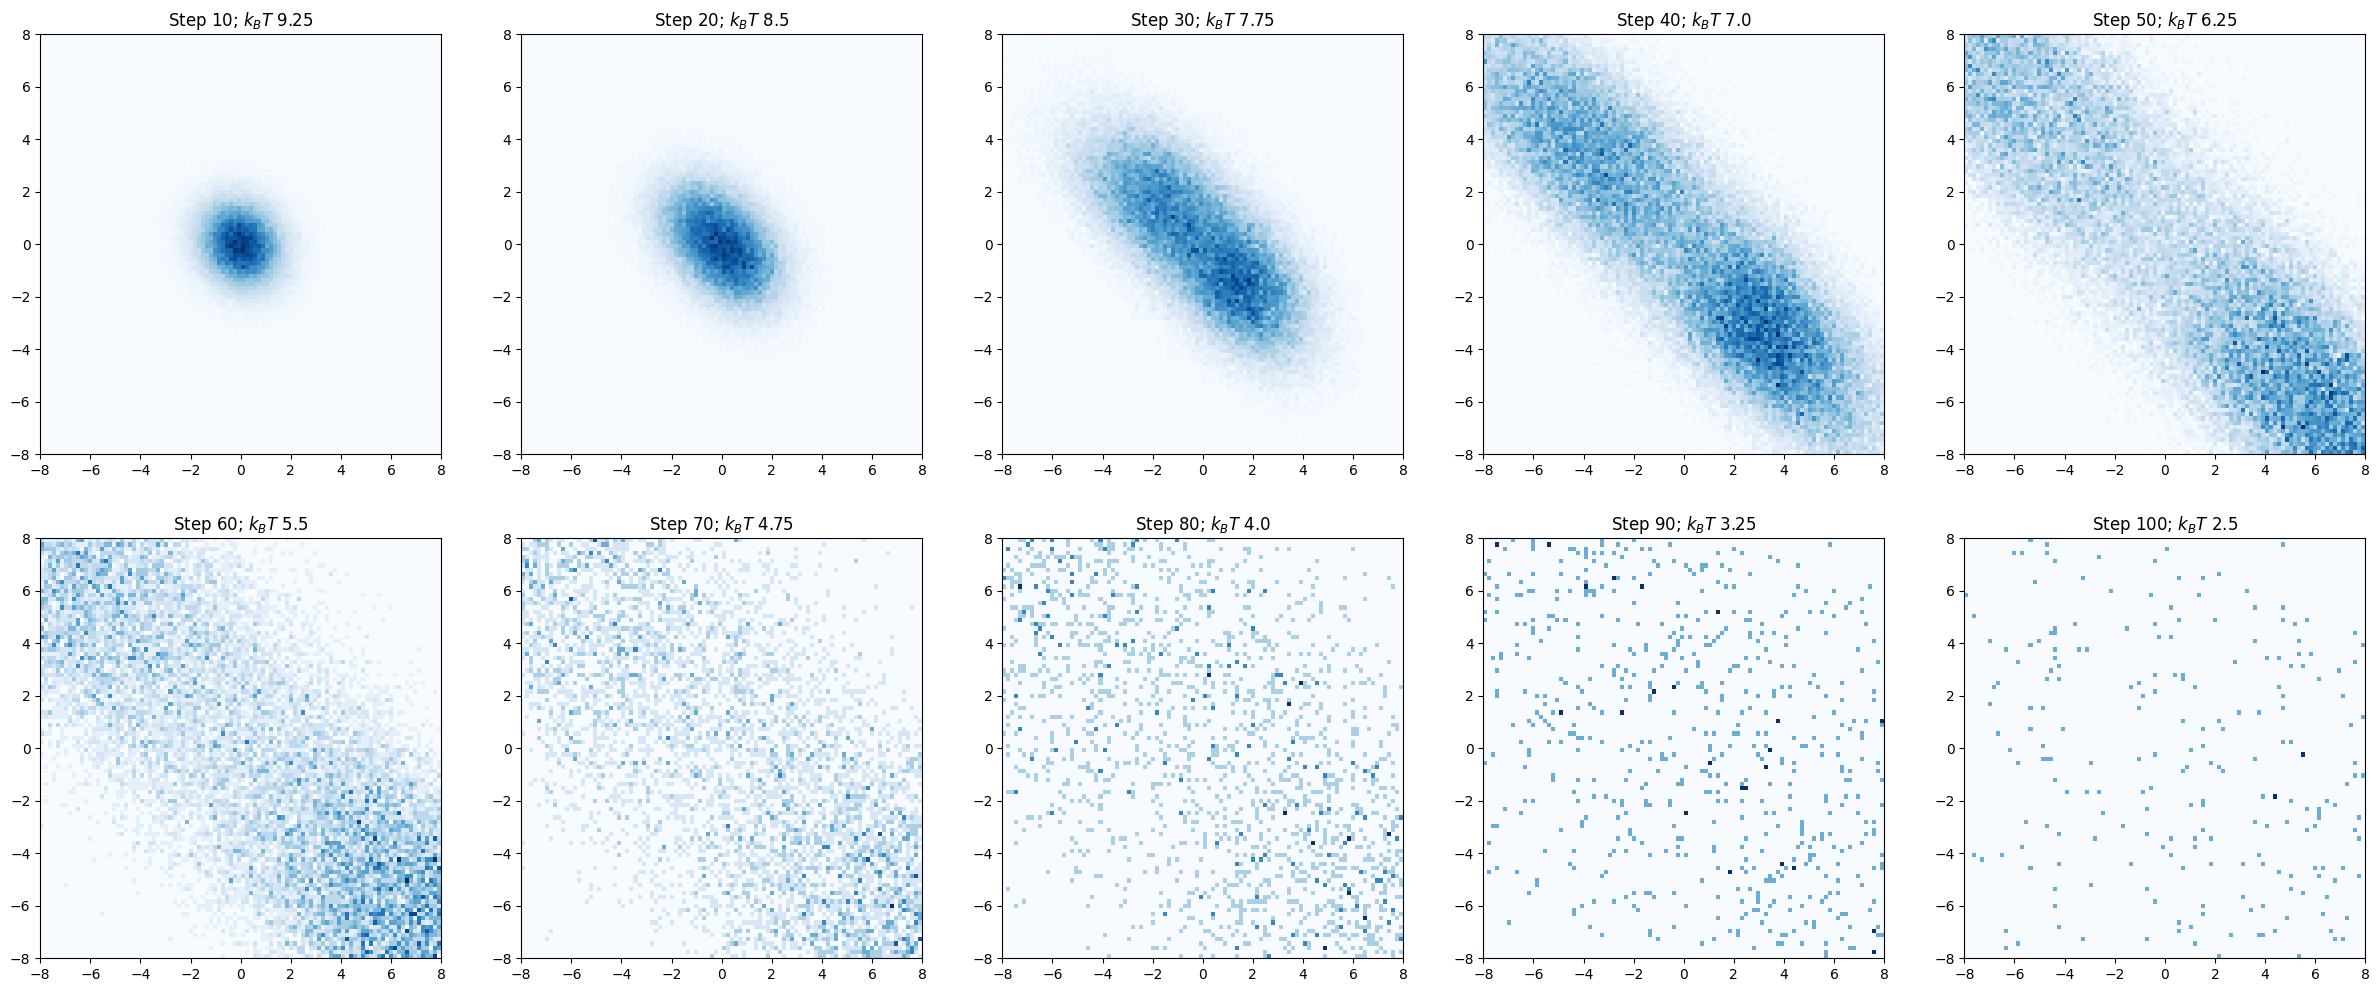

In [110]:
num_steps=100
xx_t_g2_t3 = plot_flow(model_u_t, model_s_t, g=1.5, num_steps=100)

<Figure size 1700x500 with 0 Axes>

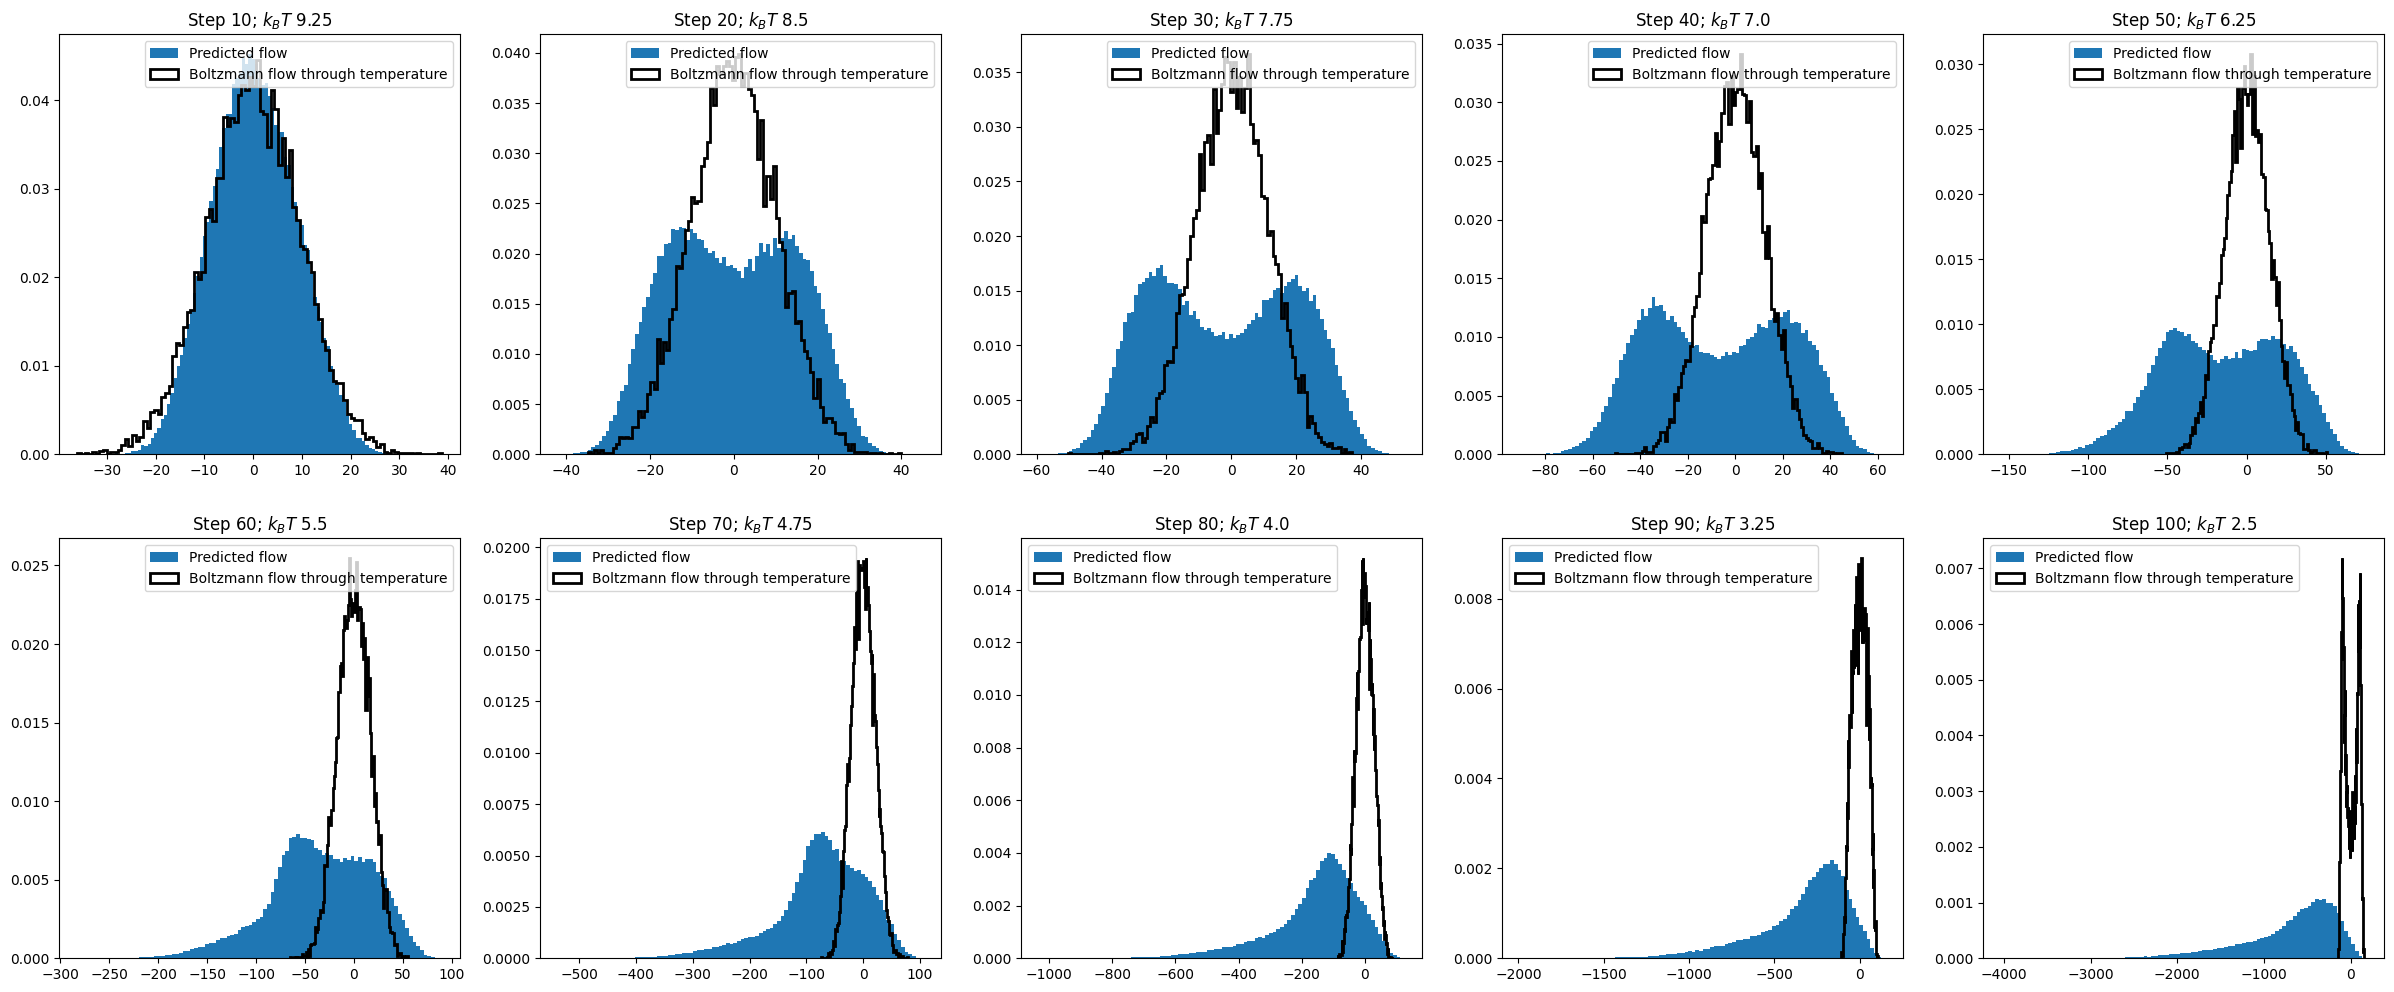

In [111]:
plt.figure()
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))
for ii in range(1,11):
    ii_y = (ii-1) % 5
    ii_x = (ii-1) // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii*10)+"; $k_BT$ "+str(10.-7.5*ii*(num_steps//10)/num_steps))
    axes[ii_x,ii_y].hist(xx_t_g2_t3[ii*10,:,:].sum(-1),bins=100, density=True, label="Predicted flow")
    axes[ii_x,ii_y].hist(plot_Tflow_t[ii,:,:].sum(-1), bins=100, edgecolor='black', histtype='step', linewidth=2, density=True, label="Boltzmann flow through temperature")
    axes[ii_x,ii_y].legend()
plt.show()

# Flow matching with temperature reweighted probability path

In [ ]:
dataset = xx3.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

In [ ]:
from torch.autograd.functional import jacobian

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 10
NS = 5000
NS_xxtilde = 5000
xx_t = np.zeros((NT+1, NS, 36))
# xx_t[0,:,:] = np.random.normal(loc=0.0, scale=1.0, size=(NS,36))
xx_t[0,:,:] = sample_batch(NS)
xxtilde_prev = xx_t[0,:,:]
p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
logp_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = np.zeros((NT, NS, 36))
ising_t = Ising(6,2,0.25)
for tt in range(NT):
    beta_tt = 0.25-((0.25-0.1)*(tt+1)/NT)
    print('Step: ' + str(tt) + "; Beta: "+str(beta_tt))
    # ising_t = Ising(6,2,0.1+Delta_beta-sigma_tt*Delta_beta)
    
    # xxtilde = sample_batch(NS_xxtilde)
    if tt == 0:
        xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=1000, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    else:
        xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=500, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    xxtilde_prev = xxtilde

    e_xxtilde = ising_t.energy(torch.from_numpy(xxtilde).to(torch.float32).reshape(NS_xxtilde,36)).detach().numpy()
    # lnZ = ising_t.lnZ(torch.from_numpy(xxtilde).reshape(NS_xxtilde,36)).detach().numpy()
    # print(lnZ)
    e_xx_list = []
    for ii in range(NS):
        e_xx = ising_t.energy(torch.from_numpy(xx_t[tt,ii,:]).to(torch.float32).reshape(1,36)).detach().numpy()
        e_xx_list.append(e_xx[0])
        # p_t_xx_xxtilde[tt,ii,:] = np.exp(-(e_xx-e_xxtilde))/np.exp(lnZ)
        logp_t_xx_xxtilde[tt,ii,:] = -(e_xx-e_xxtilde) # -lnZ
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36))

    p_t_xx_xxtilde[tt] = np.exp(logp_t_xx_xxtilde[tt].reshape(NS,NS_xxtilde)-logp_t_xx_xxtilde[tt].max())
    p_t_xx[tt, :] = np.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)

    plt.figure(figsize=(29,5))
    plt.subplot(151)
    plt.hist((p_t_xx_xxtilde[tt]/p_t_xx[tt, :]).reshape(-1), bins=100)
    plt.xlabel("p_t_xx_xxtilde[tt]")
    plt.subplot(152)
    plt.hist(e_xx-e_xxtilde, bins=100)
    plt.xlabel(r"(exx-e_xxtilde)/$\beta_t$")
    plt.subplot(153)
    plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(xxtilde.sum(-1).min(), xxtilde.sum(-1).max()))
    plt.xlabel("xx_t[tt]")
    plt.subplot(154)
    plt.hist(xxtilde.sum(-1),bins=100)
    plt.xlabel("xxtilde")

    # plt.figure(figsize=(11,5))
    # plt.subplot(121)
    # plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(xxtilde.sum(-1).min(), xxtilde.sum(-1).max()))
    # plt.xlabel("xx_t[tt]")
    # plt.subplot(122)
    # plt.hist(xxtilde.sum(-1),bins=100)
    # plt.xlabel("xxtilde")
    # plt.show()

    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])

    plt.subplot(155)
    # plt.hist(u_t_xx[tt].sum(-1) * Delta_beta/NT,bins=100)
    # plt.xlabel("u_t[tt]")
    plt.scatter(xx_t[tt].sum(-1).reshape(-1), u_t_xx[tt].sum(-1) * 1./NT, s=3)
    plt.xlabel("xx_t[tt]")
    plt.ylabel("u_t[tt]")
    plt.show()

    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:]

In [ ]:
torch.exp(torch.tensor(-80.))

tensor(1.8049e-35)

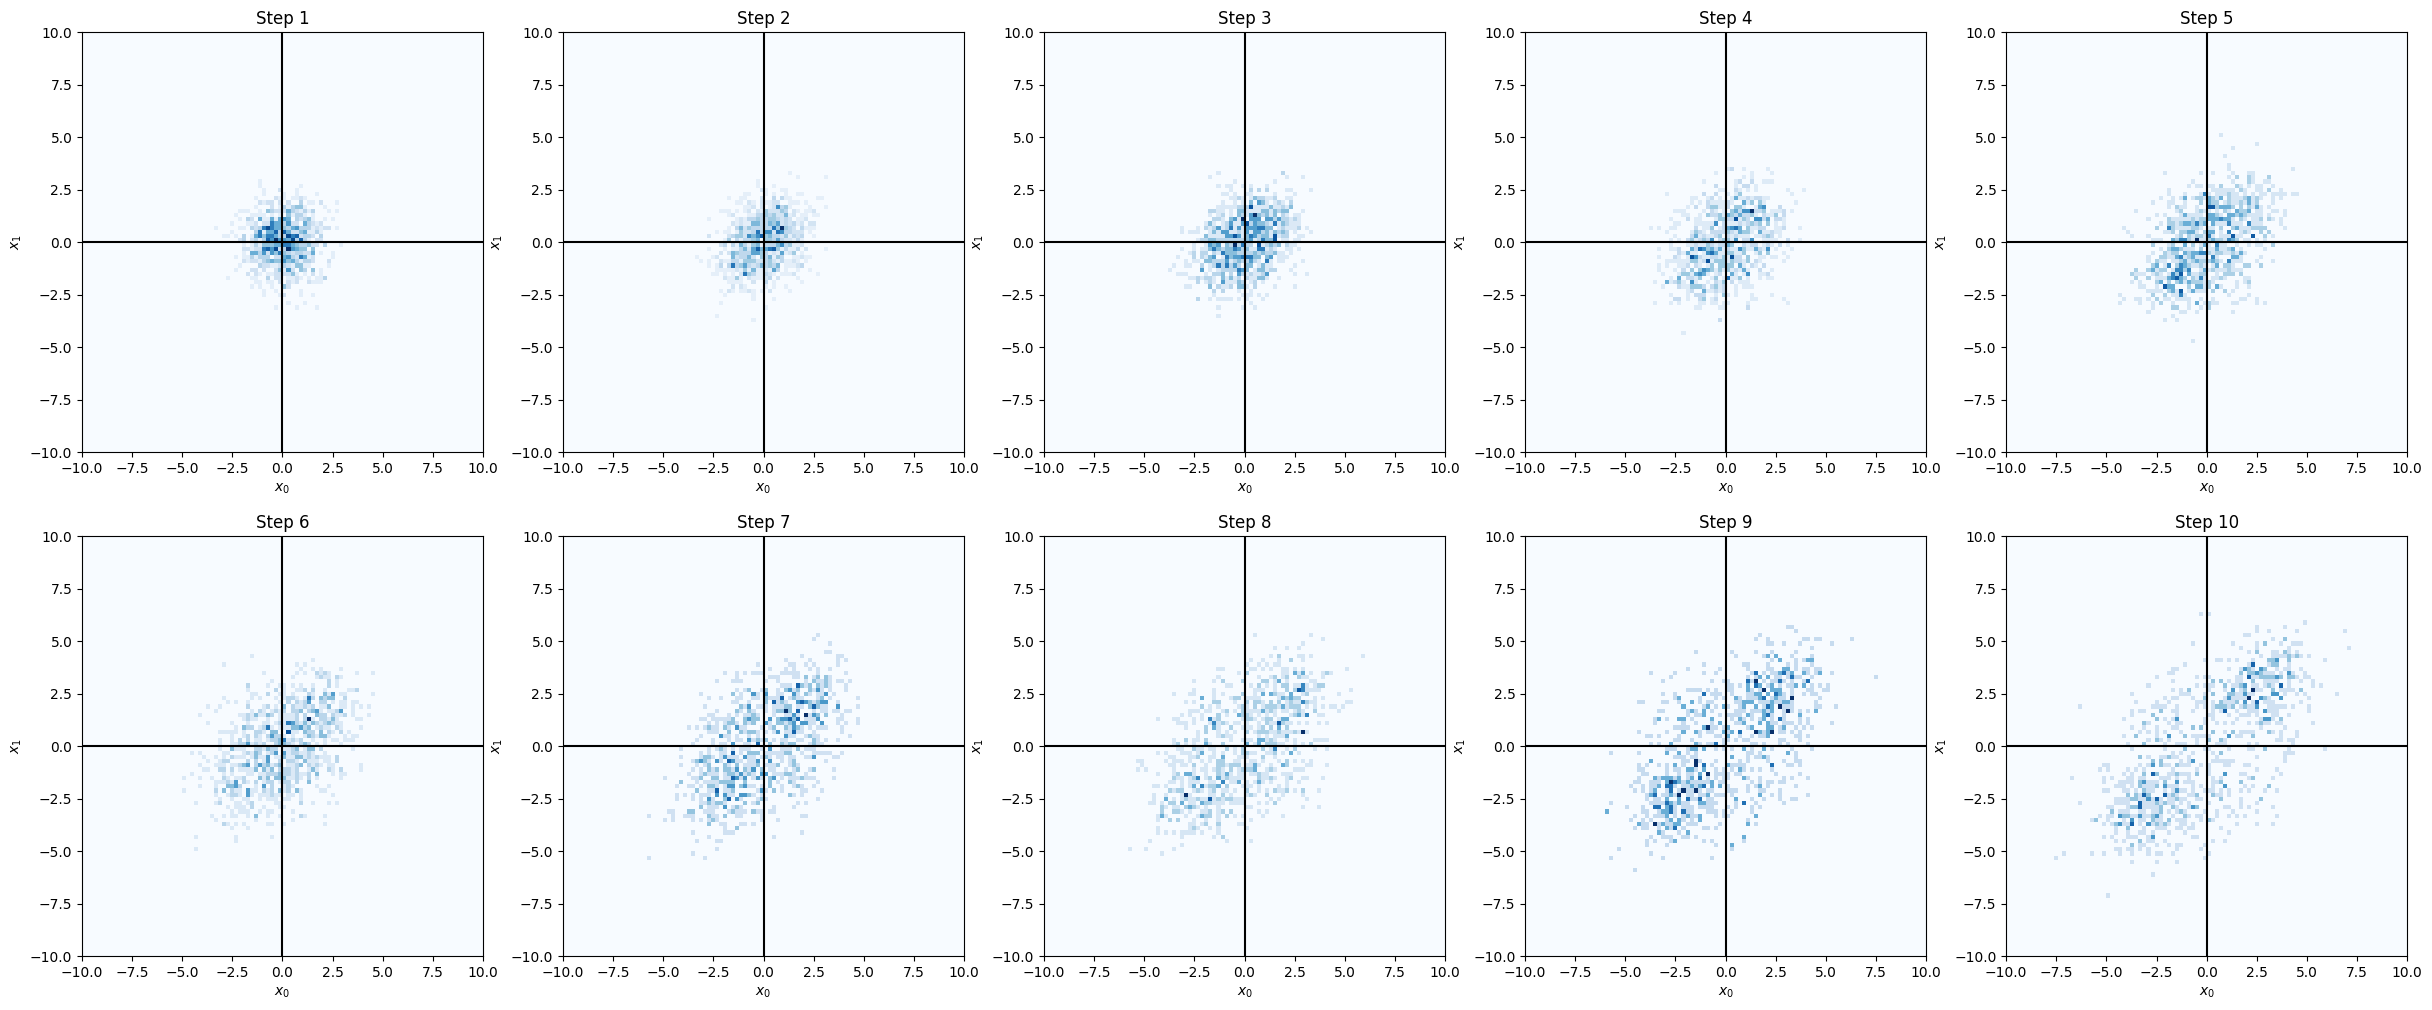

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(xx_t[ii*5,:,0], xx_t[ii*5,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10), (-10, 10)]))
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

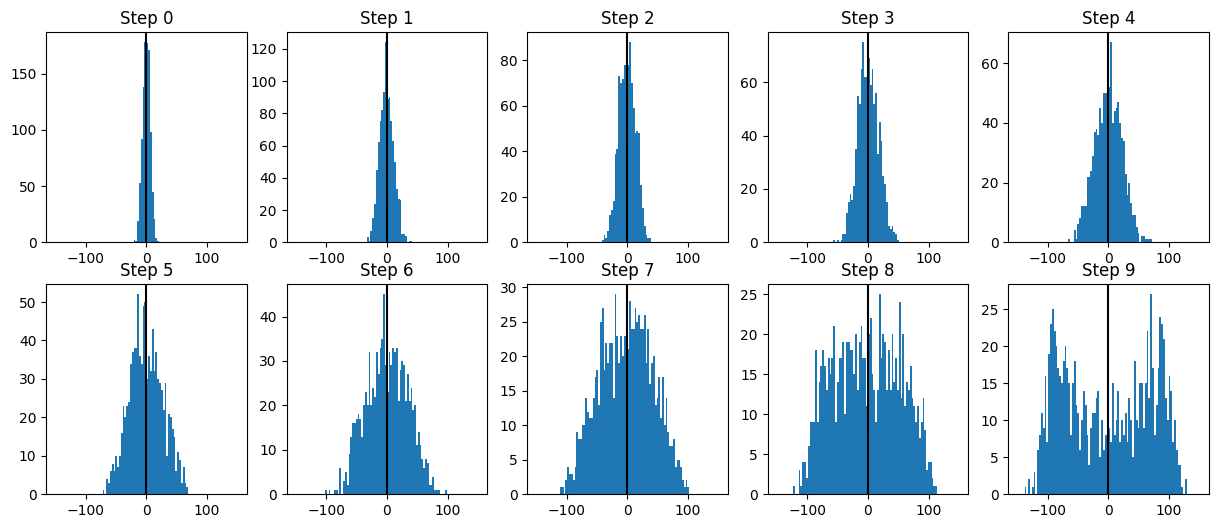

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[(ii)*5,:,:].sum(-1),bins=100, range=(-150,150))
    axes[ii_x,ii_y].axvline(0, c="k")
plt.show()

In [ ]:
def fm_loss(model, samples, u_t_label):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

l_curve = []
batch_size = 256
samples = np.zeros((batch_size, 37))
print('[Time step, loss value, lr]')
for t in range(20000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    samples[:,0] = t_idx / 10 
    samples[:,1:] = xx_t[t_idx, x_idx, :]
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()
    loss = fm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    scheduler.step()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1000) == 0):
        print([t,loss.item(),scheduler.get_last_lr()])

[Time step, loss value, lr]
[0, 3339550.0, [0.003]]
[1000, 2048643.625, [0.0027]]
[2000, 1758384.0, [0.0024300000000000003]]
[3000, 1929806.375, [0.002187]]
[4000, 1695513.375, [0.0019683]]
[5000, 1716151.75, [0.00177147]]
[6000, 1774280.5, [0.0015943230000000001]]
[7000, 1850370.5, [0.0014348907]]
[8000, 1767070.625, [0.00129140163]]
[9000, 1702445.875, [0.001162261467]]
[10000, 1763267.75, [0.0010460353203000001]]
[11000, 1791267.375, [0.0009414317882700001]]
[12000, 1810621.625, [0.0008472886094430002]]
[13000, 1804188.25, [0.0007625597484987002]]
[14000, 1838576.5, [0.0006863037736488302]]
[15000, 1794693.75, [0.0006176733962839472]]
[16000, 1661607.375, [0.0005559060566555524]]
[17000, 1854034.75, [0.0005003154509899972]]
[18000, 1658527.375, [0.00045028390589099747]]
[19000, 1613891.875, [0.0004052555153018977]]


In [ ]:
print('[Time step, loss value, lr]')
for t in range(20000, 30000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    samples[:,0] = t_idx / 10 
    samples[:,1:] = xx_t[t_idx, x_idx, :]
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()
    loss = fm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    scheduler.step()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1000) == 0):
        print([t,loss.item(),scheduler.get_last_lr()])

[Time step, loss value, lr]
[20000, 1708818.5, [0.00036472996377170795]]
[21000, 1633993.25, [0.00032825696739453717]]
[22000, 1684556.625, [0.00029543127065508344]]
[23000, 1630271.625, [0.0002658881435895751]]
[24000, 1527097.25, [0.0002392993292306176]]
[25000, 1745271.375, [0.00021536939630755584]]
[26000, 1794781.0, [0.00019383245667680025]]
[27000, 1631388.0, [0.00017444921100912022]]
[28000, 1701325.75, [0.0001570042899082082]]
[29000, 1713442.125, [0.0001413038609173874]]


In [ ]:
def plot_flow(model):
    sample_size = 10**3
    xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx_t = []
    xx_t.append(xx.detach().numpy())
    plt.figure(figsize=(11,5))
    for ii in range(50):
        tt = ii / 50
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model(samples)
        print("Step = "+str(ii))
        plt.figure(figsize=(11,5))
        plt.subplot(121)
        plt.hist2d(u_t[:,0].detach().numpy(), u_t[:,1].detach().numpy(), bins=100, range=[[u_t_xx[ii].min(),u_t_xx[ii].max()], [u_t_xx[ii].min(), u_t_xx[ii].max()]])
        plt.subplot(122)
        plt.hist2d(u_t_xx[ii][:,0], u_t_xx[ii][:,1], bins=100, range=[[u_t_xx[ii].min(),u_t_xx[ii].max()], [u_t_xx[ii].min(), u_t_xx[ii].max()]])
        plt.show()
        xx = xx + u_t * 1./50
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)

    # fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    # for ii in range(1,11):
    #     ii_y = (ii-1) % 5
    #     ii_x = (ii-1) // 5
    #     axes[ii_x,ii_y].set_title('Step '+str(ii))
    #     axes[ii_x,ii_y].hist2d(xx_t[ii*5,:,0], xx_t[ii*5,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
    #     axes[ii_x,ii_y].set_xlim([-1.5,2])
    #     axes[ii_x,ii_y].set_ylim([-1.5,2])
    
    # plt.show()

# print(u_t_xx.shape)
plot_flow(model_u_t)

# Flow matching with dirichlet path

In [ ]:

def pbc(i,L):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i

def ising_boltzman_prob(logits, J=1):
    assert logits.shape[-1] == 2
    B,H,W,K = logits.shape
    spins = torch.sum(logits*torch.tensor([-1,1], device=logits.device)[None,None,None,:], dim=-1)

    E = torch.zeros(B, device=logits.device)
    for i in range(H):
            E += -(spins[:,i,:]*spins[:,pbc(i-1,L=H),:]*J).sum(dim=-1)
            E += -(spins[:,i,:]*spins[:,pbc(i+1,L=H),:]*J).sum(dim=-1)
    for j in range(W):
            E += -(spins[:,:,j]*spins[:,:,pbc(j-1,L=H)]*J).sum(dim=1)
            E += -(spins[:,:,j]*spins[:,:,pbc(j+1,L=H)]*J).sum(dim=1)

    # for i in range(H):
    #     for j in range(W):
    #         E += -spins[:,i,j]*spins[:,pbc(i-1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,pbc(i+1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j-1,L=H)]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j+1,L=H)]*J

    E /= 2
    return E

In [ ]:
dataset = np.load("data/ising-latt6x6-T4.0/latt6x6/buffer-S4.00.npy")
dataset[np.where(dataset==-1)]=0
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size)
    return dataset[idx]

In [ ]:
sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 50
NS = 1000
NS_xxtilde = 1000
xx_t = torch.zeros((NT+1, NS, 36))
# xx_t[0,:,:] = np.random.normal(size=(NS,36))
alphas = torch.ones([NS, 36, 2])
xx_t[0,:,:] = torch.distributions.Dirichlet(alphas).sample()[:,:,0]

p_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde))
p_t_xx = torch.zeros((NT, NS))
u_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = torch.zeros((NT, NS, 36))

for tt in range(NT):
    print('Step: ' + str(tt))
    sigma_tt = (1 - (1-sigma_min) * tt / NT)
    xxtilde = torch.from_numpy(sample_batch(NS_xxtilde)).to(torch.int64)
    e_xxtilde = ising_boltzman_prob(torch.nn.functional.one_hot(xxtilde.reshape(-1), num_classes=2).reshape(NS_xxtilde, 6,6, 2))
    Z = torch.exp(-e_xxtilde*sigma_tt).sum()

    rand_indices = torch.randint(0, 2, (NS, NS, 36))
    rand_onehot = torch.zeros([NS, NS, 36, 2])
    rand_onehot.scatter_(-1, rand_indices.unsqueeze(-1), 1)
    alphas = torch.ones([NS, NS, 36, 2])
    alphas = alphas + sigma_tt*rand_onehot.reshape(NS, NS, 36, 2)
    xx = torch.distributions.Dirichlet(alphas).sample()
    e_xx = ising_boltzman_prob(rand_onehot.reshape(-1,6,6,2)).reshape(NS,NS)
    for ii in range(NS):
        p_xx_xxtilde = torch.exp(-(e_xx[ii,:]-e_xxtilde)*sigma_tt)/Z
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt
    p_t_xx[tt, :] = torch.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = torch.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 0.02

In [ ]:
spins = xx_t*(-1.)+(1-xx_t)*1

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(spins[(ii)*5,:,0], spins[ii+1,:,1],bins=100, cmap='Blues',range=np.array([(-3.5, 3.5), (-3.5, 3.5)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2]) 
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(spins[(ii)*5,:,:].sum(-1),bins=100)
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlim((-50,50))
plt.show()

In [ ]:
raise RuntimeError

# Test Harmonic oscillator

In [ ]:
class Harmonic_Oscillator:
    def __init__(self,T):
        self.T = T
        self.kappa = 1.0/T
        self.nvars=[36]

    def energy(self, x):
        return ((x)**2*self.kappa).sum(axis=1)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)

    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()

        

In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
harmonic_oscillator = Harmonic_Oscillator(10)
xx0 = harmonic_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(5)
xx1 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(4)
xx2 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

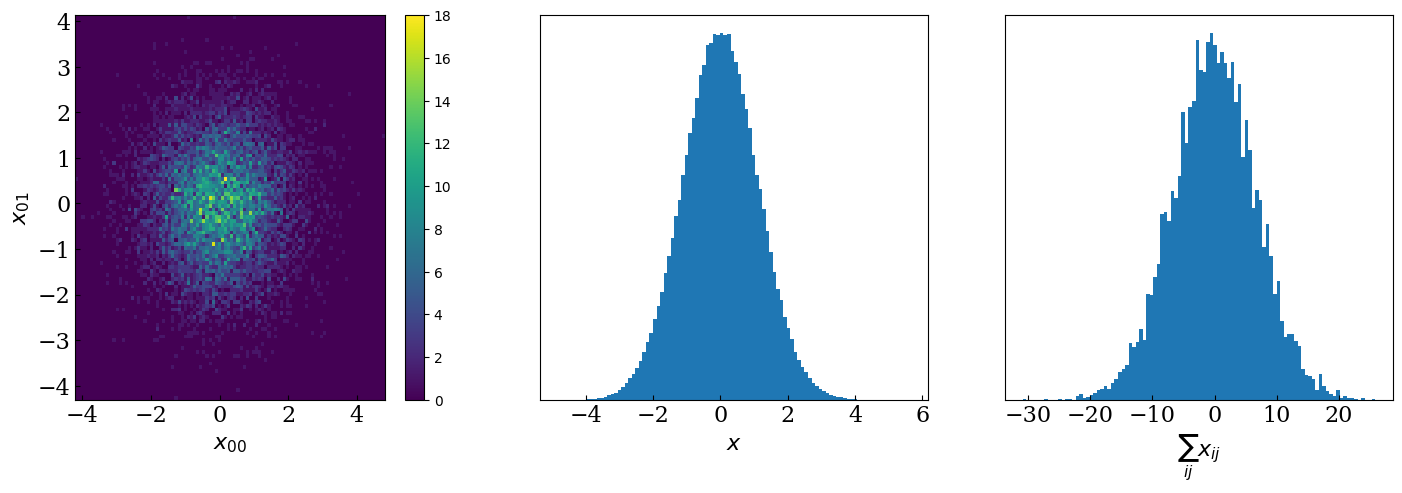

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(2.5)
xx3 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test continous x with nearest neighbor interactions

In [ ]:
class nn_harmonic_oscillator:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        K = self.lattice.Adj*beta
        self.K = torch.from_numpy(K).to(torch.float32)
        # w, v = eigh(self.K)    
        # offset = 0.1-w.min()
        # print("offset", offset)
        # self.K += np.eye(w.size)*offset
        # sign, logdet = np.linalg.slogdet(self.K)
        # self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        return -0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.K) * x.reshape(-1, self.nvars[0])).sum(dim=1)

    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()


In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
nn_oscillator = nn_harmonic_oscillator(6,2,0.1)
xx0 = nn_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.2)
xx1 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.25)
xx2 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

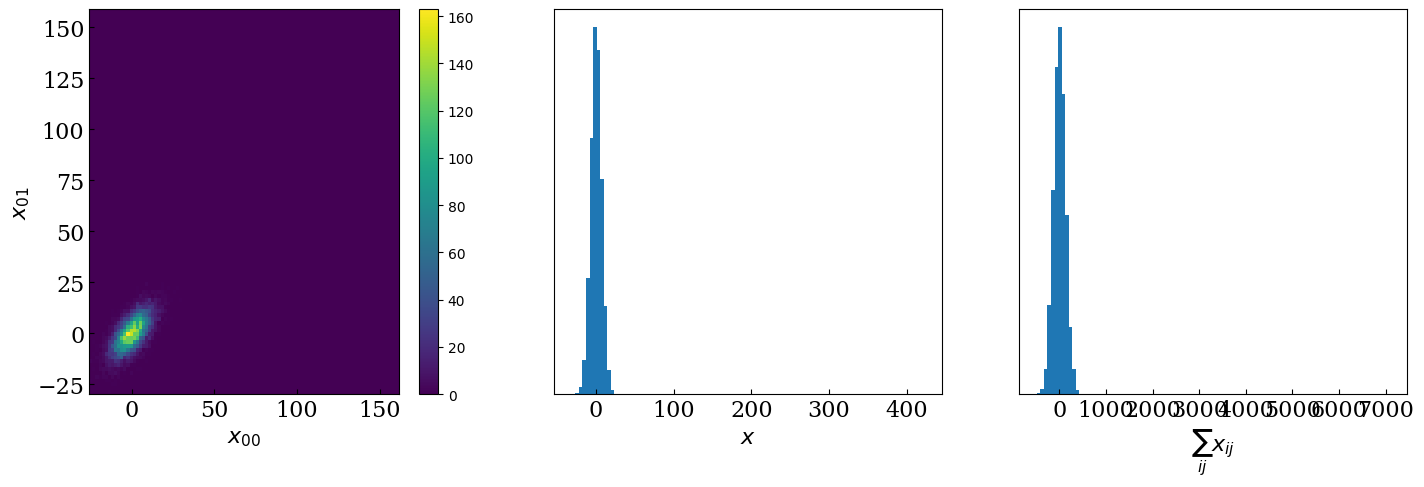

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.4)
xx3 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test the gaussian integral continuous Ising model
## Sample by annealing
$k_BT=\infty \rightarrow 10J\rightarrow 5J\rightarrow 4J\rightarrow 2.5J$

### $k_BT=\infty \rightarrow 10J$

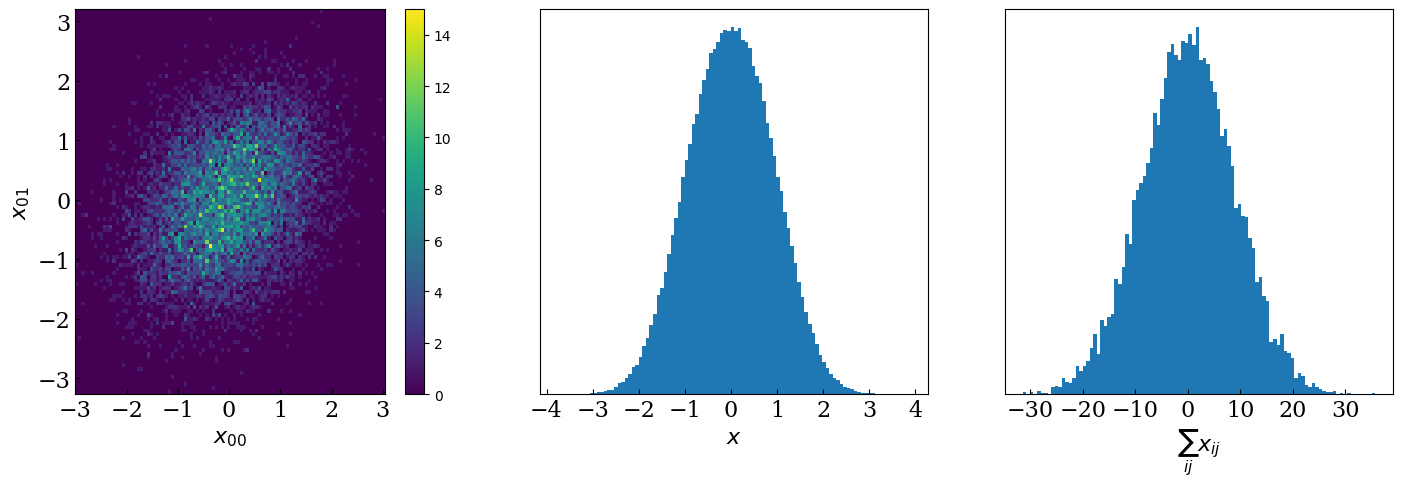

In [5]:
import torch

plt.rcParams['figure.figsize'] = (17, 5)
ising = Ising(6,2,0.1)
xx0 = ising.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

#### MSD

In [ ]:
x_t_list = []
x_t = xx0
ising = Ising(6,2,0.1)
for t in range(1000):
    x_t = ising.sample(1000, thermalSteps = 1, interSteps=10, initial=x_t)
    x_t_list.append(x_t.detach().numpy())
x_t_list = np.array(x_t_list)
MSD_t_list = []
for j in range(1, x_t_list.shape[0]):
    MSD_t_list.append(((x_t_list[j]-x_t_list[0])**2).mean(axis=1))
MSD_t_list = np.array(MSD_t_list)
plt.plot(MSD_t_list[::1,0])

In [ ]:
plt.plot(MSD_t_list[::10,0])

### $k_BT=10J \rightarrow 5J$

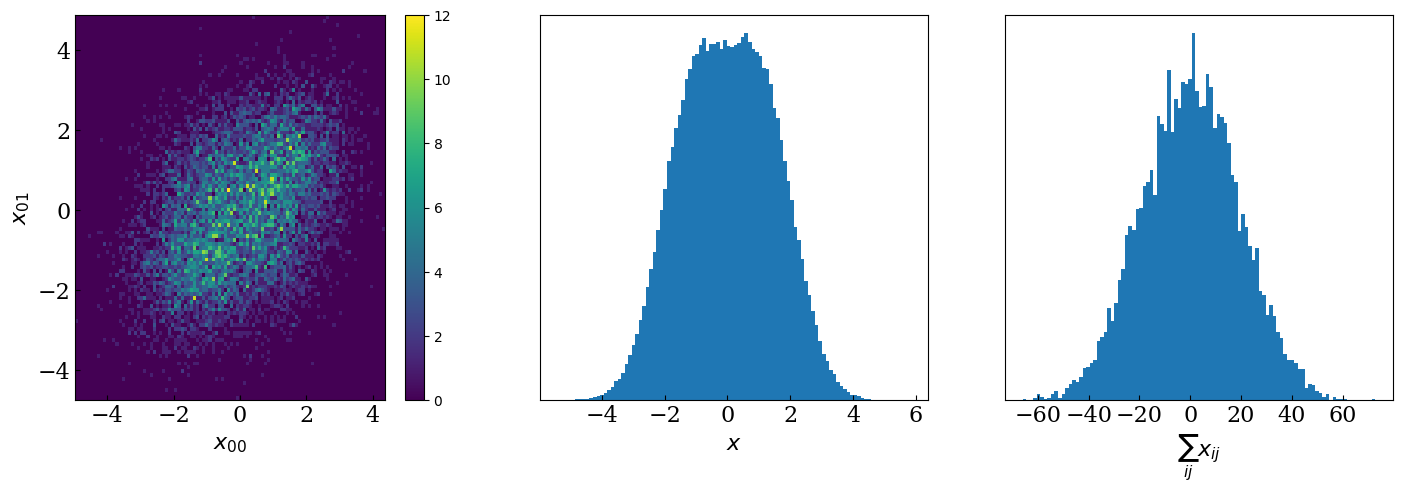

In [6]:
ising = Ising(6,2,0.2)
xx1 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=5J \rightarrow 4J$

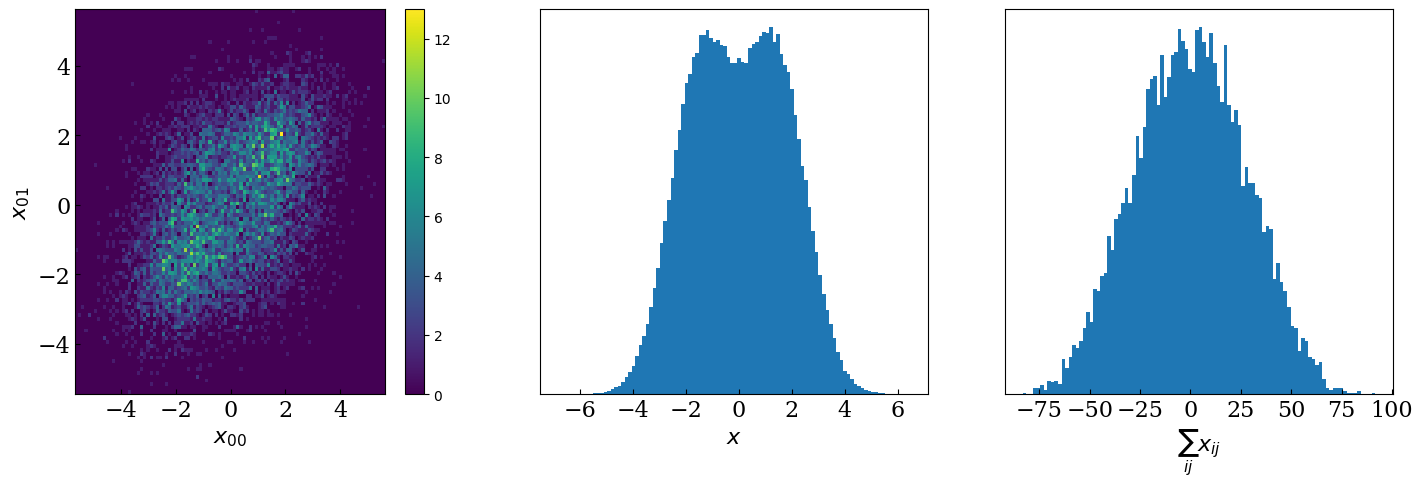

In [7]:
ising = Ising(6,2,0.25)
xx2 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=4J \rightarrow 2.5J$

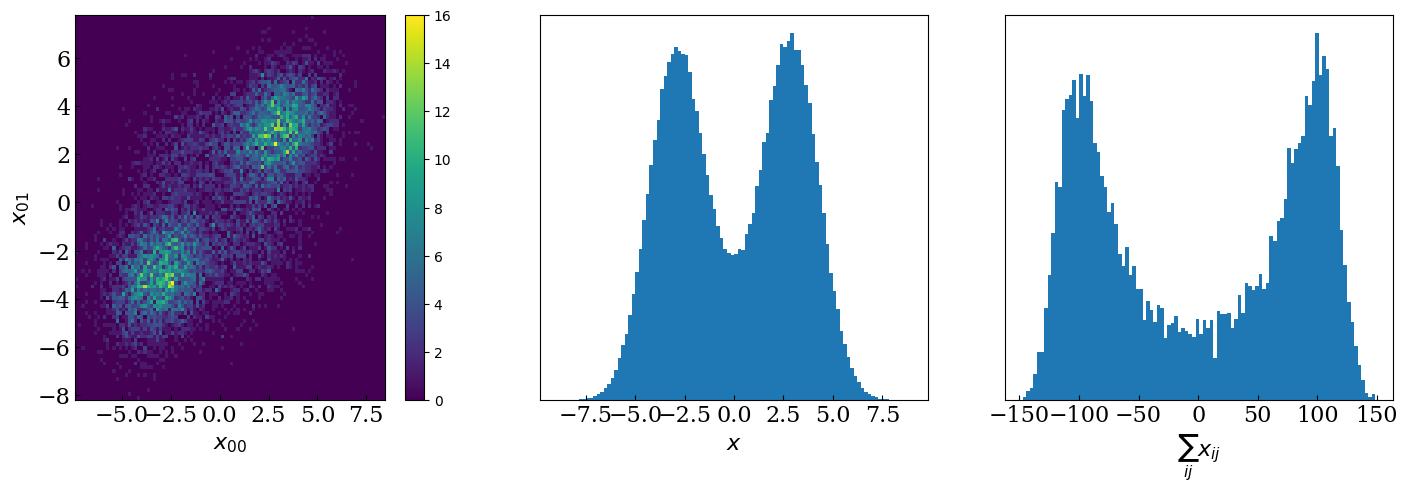

In [11]:
ising = Ising(6,2,0.4)
xx3 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

#### MSD

In [ ]:
x_t_list = []
x_t = xx3
ising = Ising(6,2,0.4)
for t in range(20000):
    x_t = ising.sample(1000, thermalSteps = 1, interSteps=1, initial=x_t)
    x_t_list.append(x_t.detach().numpy())
x_t_list = np.array(x_t_list)
MSD_t_list = []
for j in range(1, x_t_list.shape[0]):
    MSD_t_list.append(((x_t_list[j]-x_t_list[0])**2).mean(axis=0))
MSD_t_list = np.array(MSD_t_list)


In [ ]:
print(MSD_t_list.shape)

In [ ]:
from scipy.optimize import curve_fit
def slope(t,s,d0):
    return d0+s*t
popt_list = []
pcov_list = []
for i in range(36):
    trange = np.arange(5001,20000)
    popt, pcov = curve_fit(slope, trange, MSD_t_list[5000:,i])
    popt_list.append(popt)
    pcov_list.append(pcov)
    plt.figure()
    plt.plot(MSD_t_list[:,i])
    plt.plot(trange, slope(trange,*popt))
    plt.title("Site %d"%i)

In [ ]:
popt_list = np.array(popt_list)
D = popt_list.T[0]/0.1/2
print(popt_list.shape)
print(D)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[100].reshape(-1,36)[:,0], x_t_list[100].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[100].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[100].reshape(-1,36).sum(-1), bins=100)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[-1].reshape(-1,36)[:,0], x_t_list[-1].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[-1].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[-1].reshape(-1,36).sum(-1), bins=100)